In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [3]:
df = pd.read_csv("cloudburst.csv")
pd.set_option("display.max_columns", None)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [5]:
# Handle Missing Values
df.isnull().sum()*100/len(df)

Date                   0.000000
Location               0.000000
MinTemp                1.020899
MaxTemp                0.866905
Rainfall               2.241853
Evaporation           43.166506
Sunshine              48.009762
WindGustDir            7.098859
WindGustSpeed          7.055548
WindDir9am             7.263853
WindDir3pm             2.906641
WindSpeed9am           1.214767
WindSpeed3pm           2.105046
Humidity9am            1.824557
Humidity3pm            3.098446
Pressure9am           10.356799
Pressure3pm           10.331363
Cloud9am              38.421559
Cloud3pm              40.807095
Temp9am                1.214767
Temp3pm                2.481094
CloudBurst Today       2.241853
CloudBurstTomorrow     2.245978
dtype: float64

In [6]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [7]:
def randomsampleimputation(df, variable):
    df[variable]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [8]:
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

In [9]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


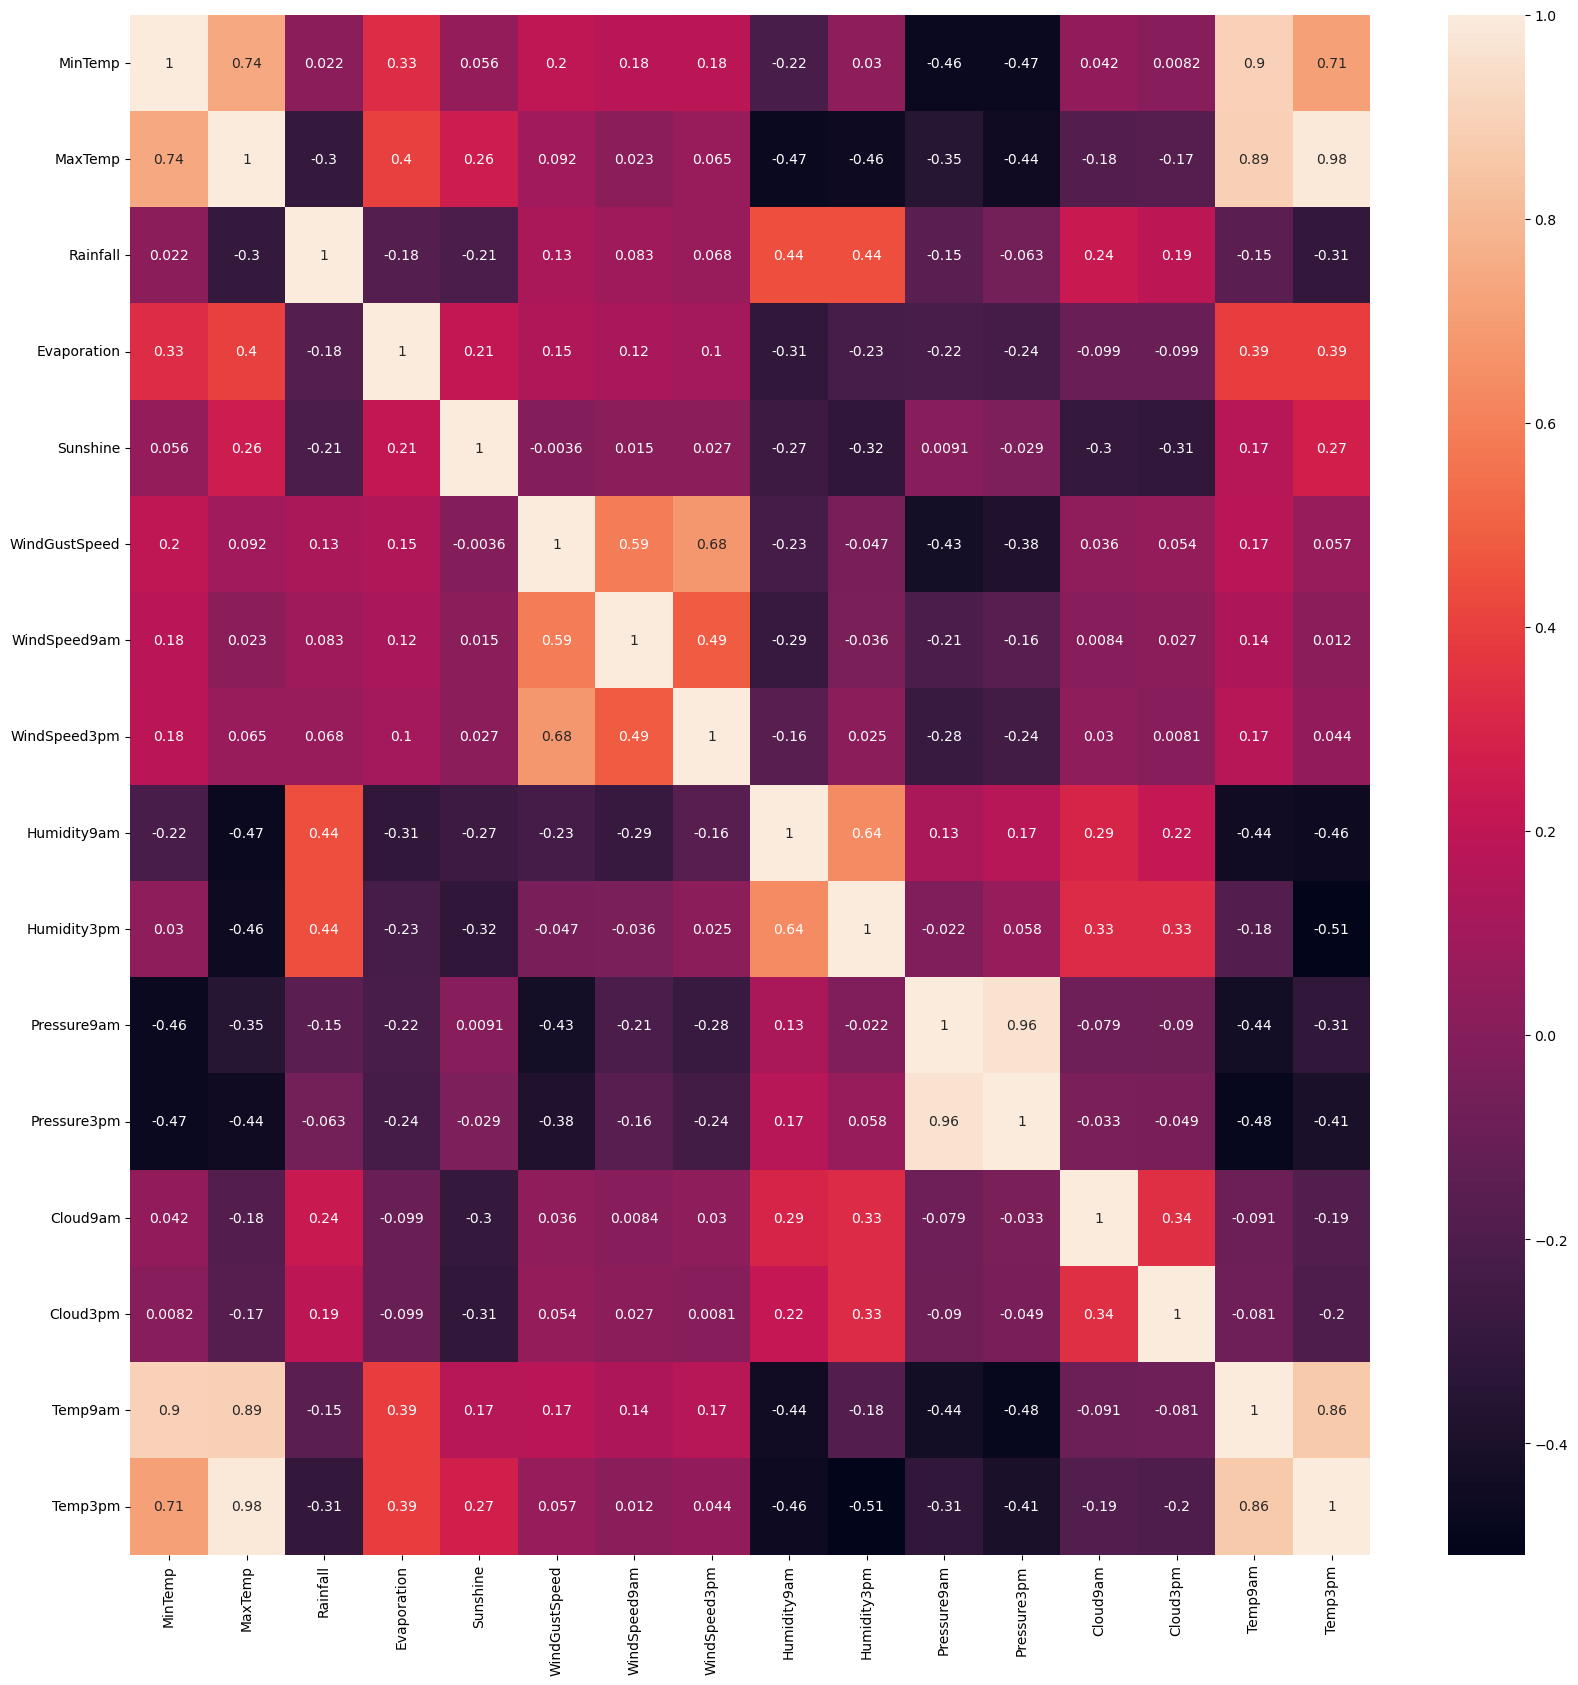

In [10]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


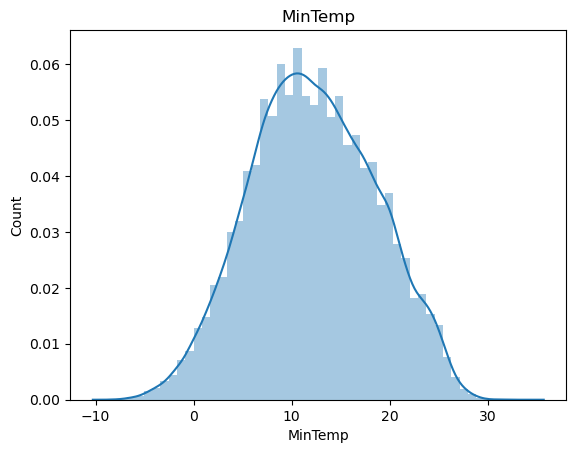

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


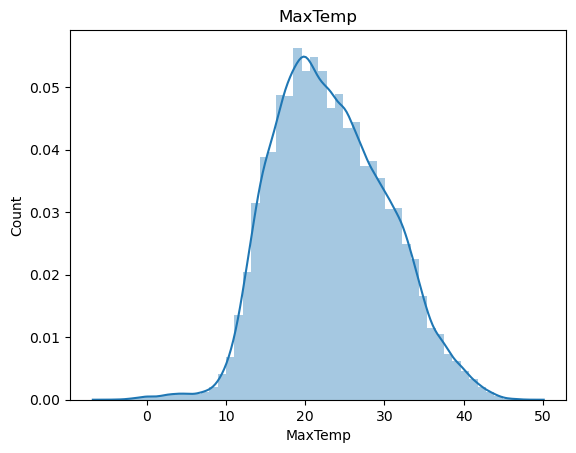

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


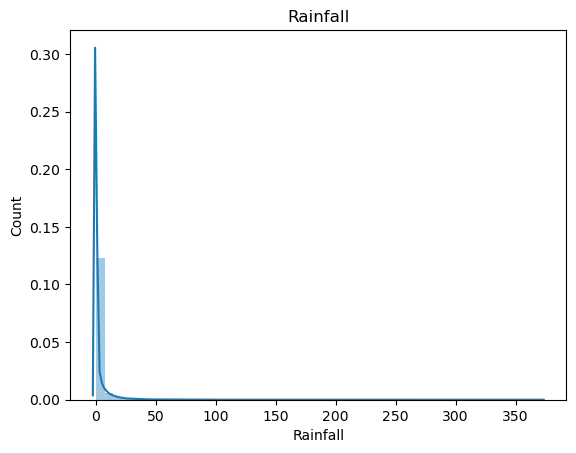

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


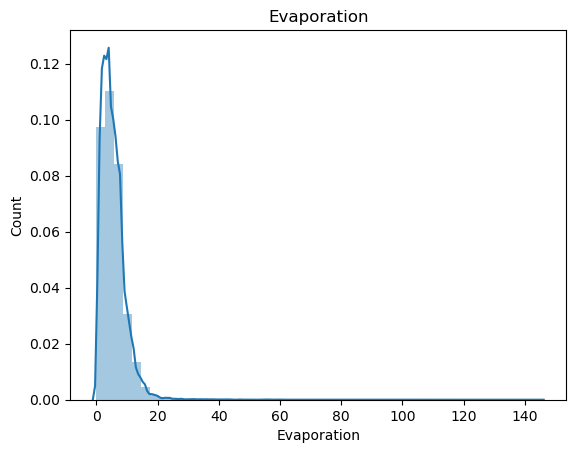

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


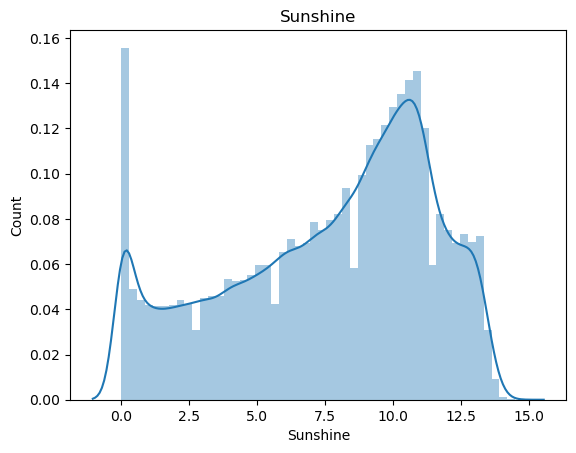

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


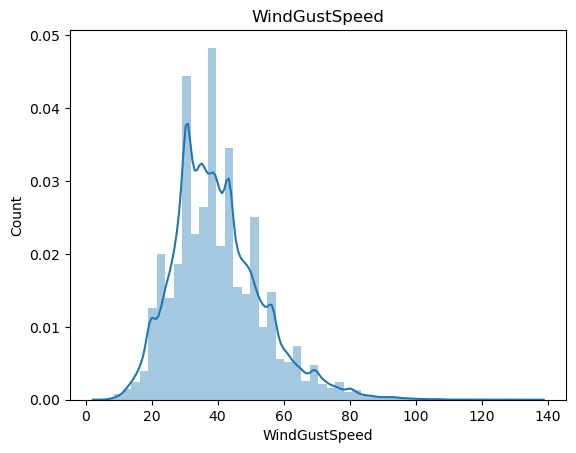

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


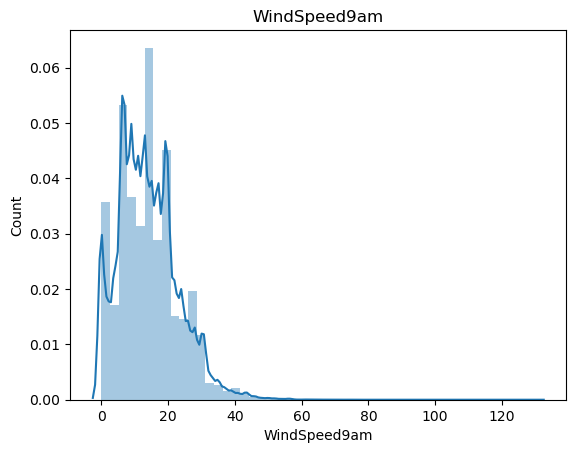

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


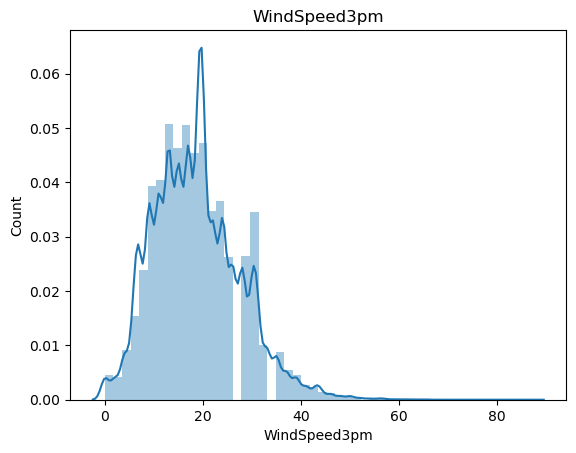

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


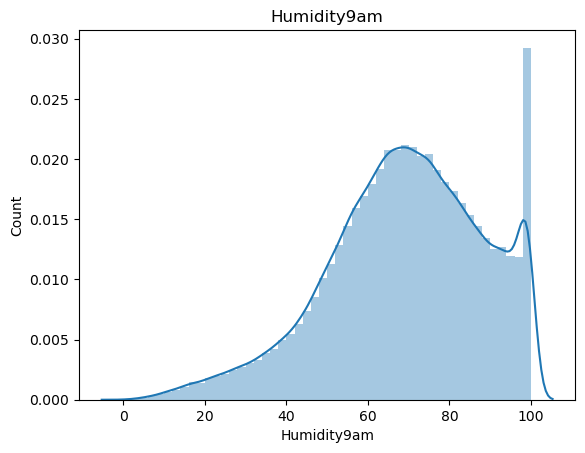

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


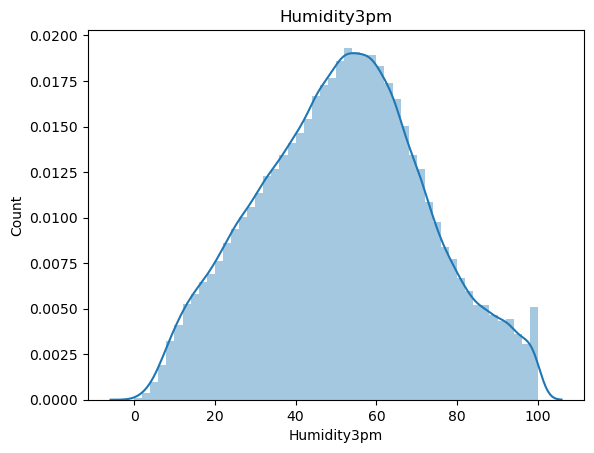

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


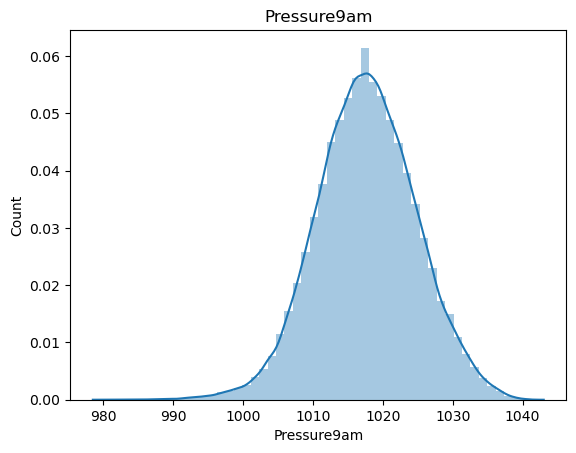

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


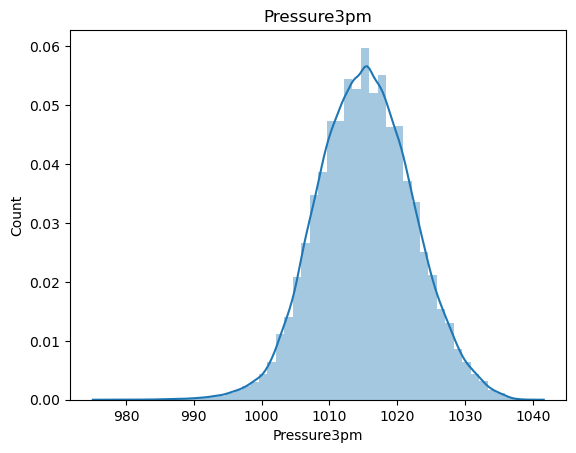

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


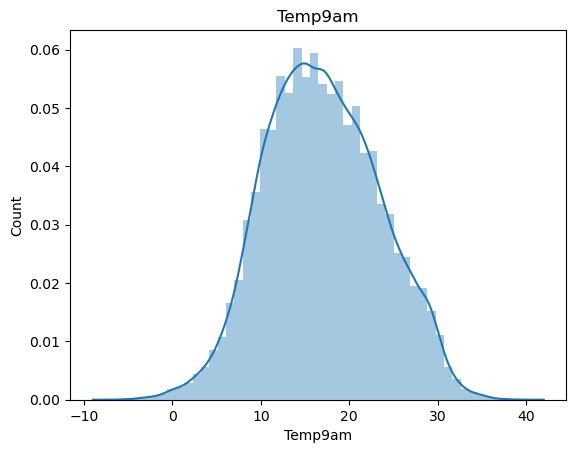

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


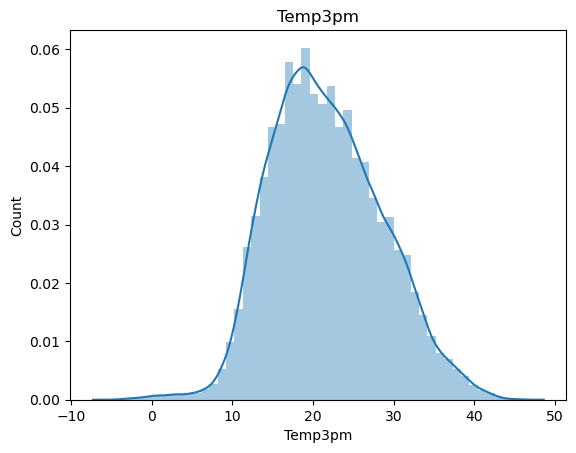

<Figure size 1500x1500 with 0 Axes>

In [11]:
for feature in continuous_feature:
    data=df.copy()
    sns.distplot(df[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zeel sh

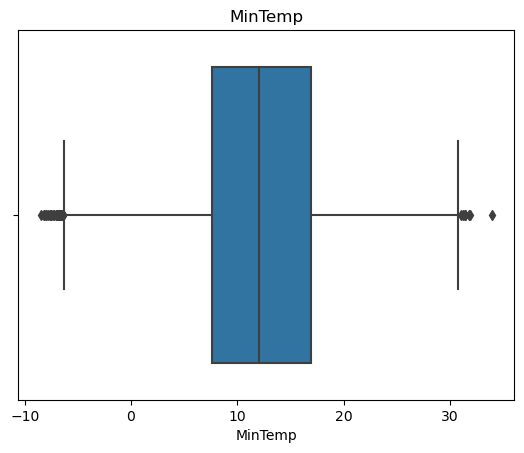

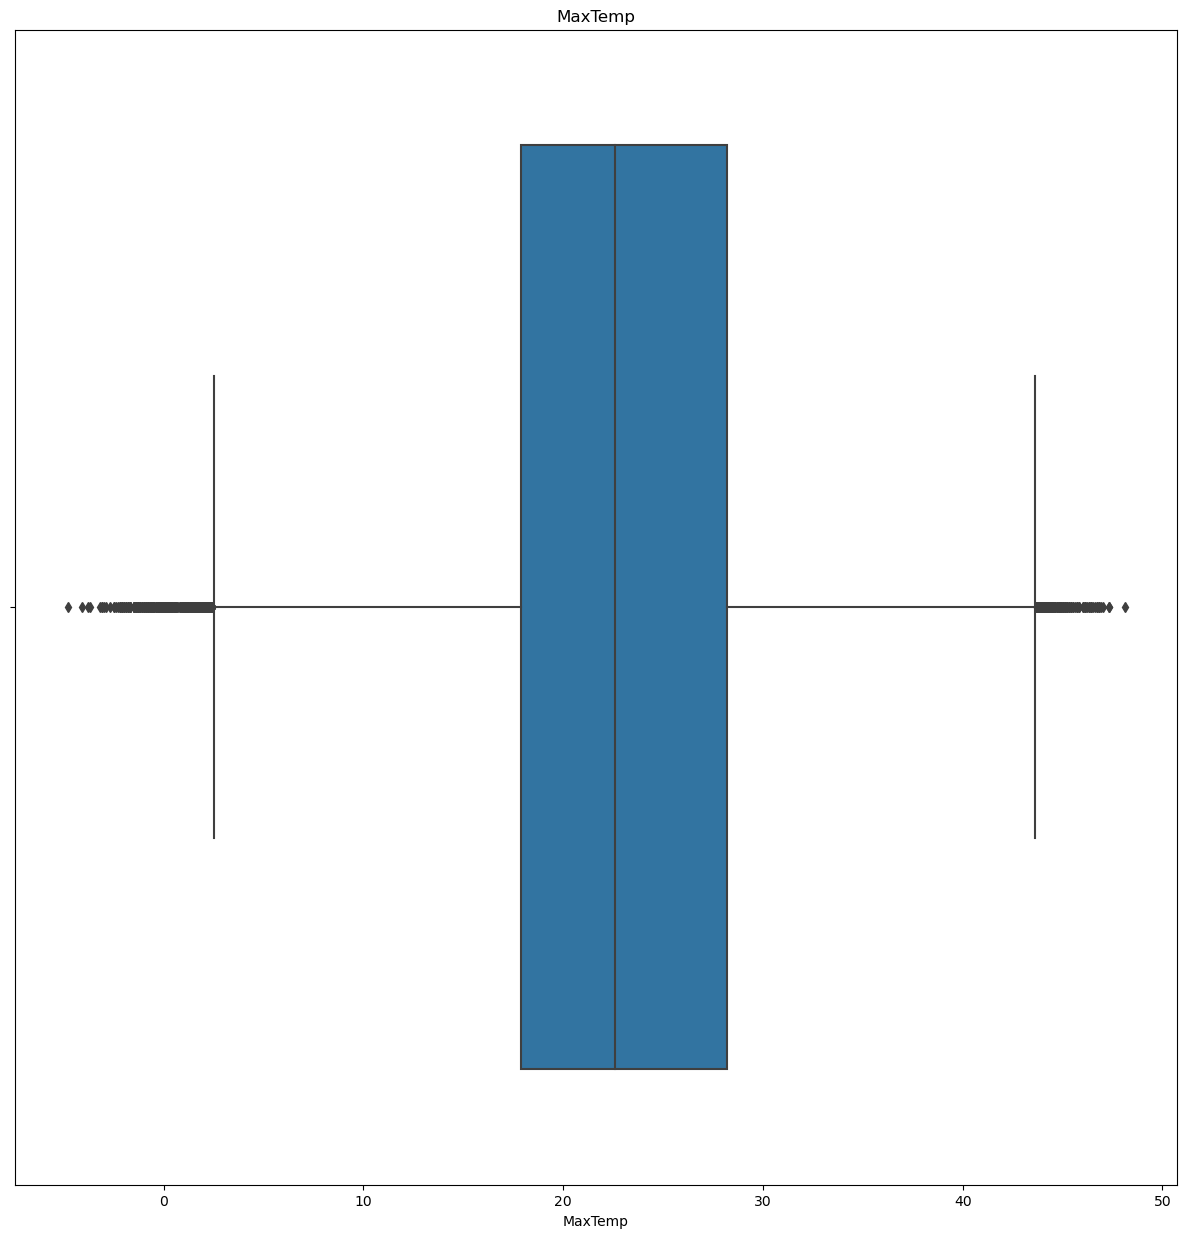

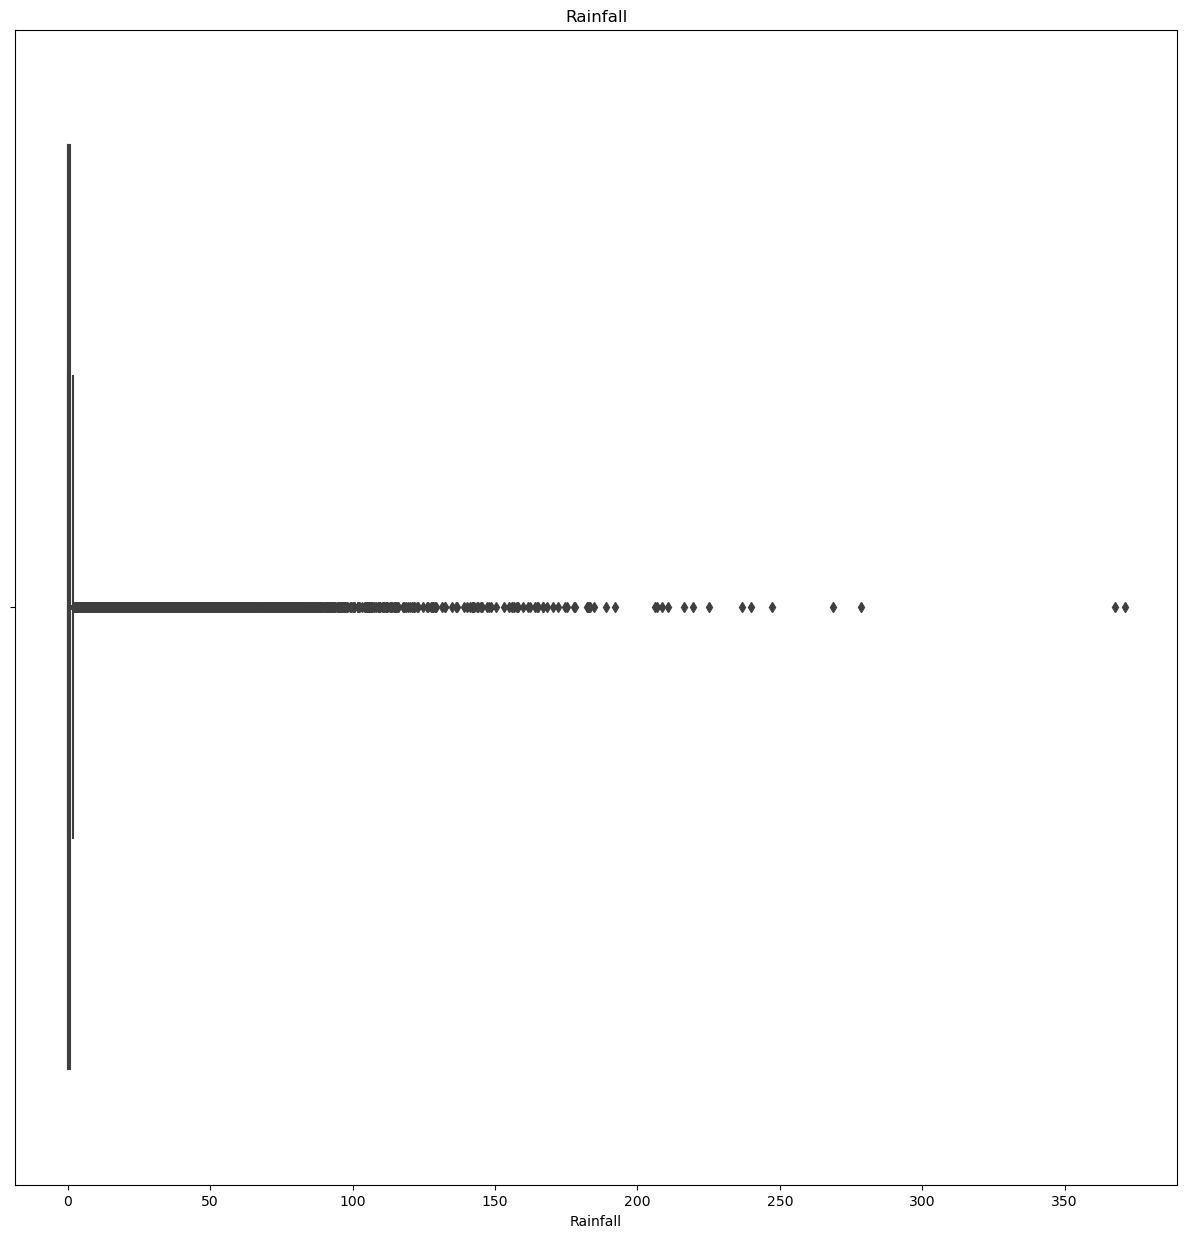

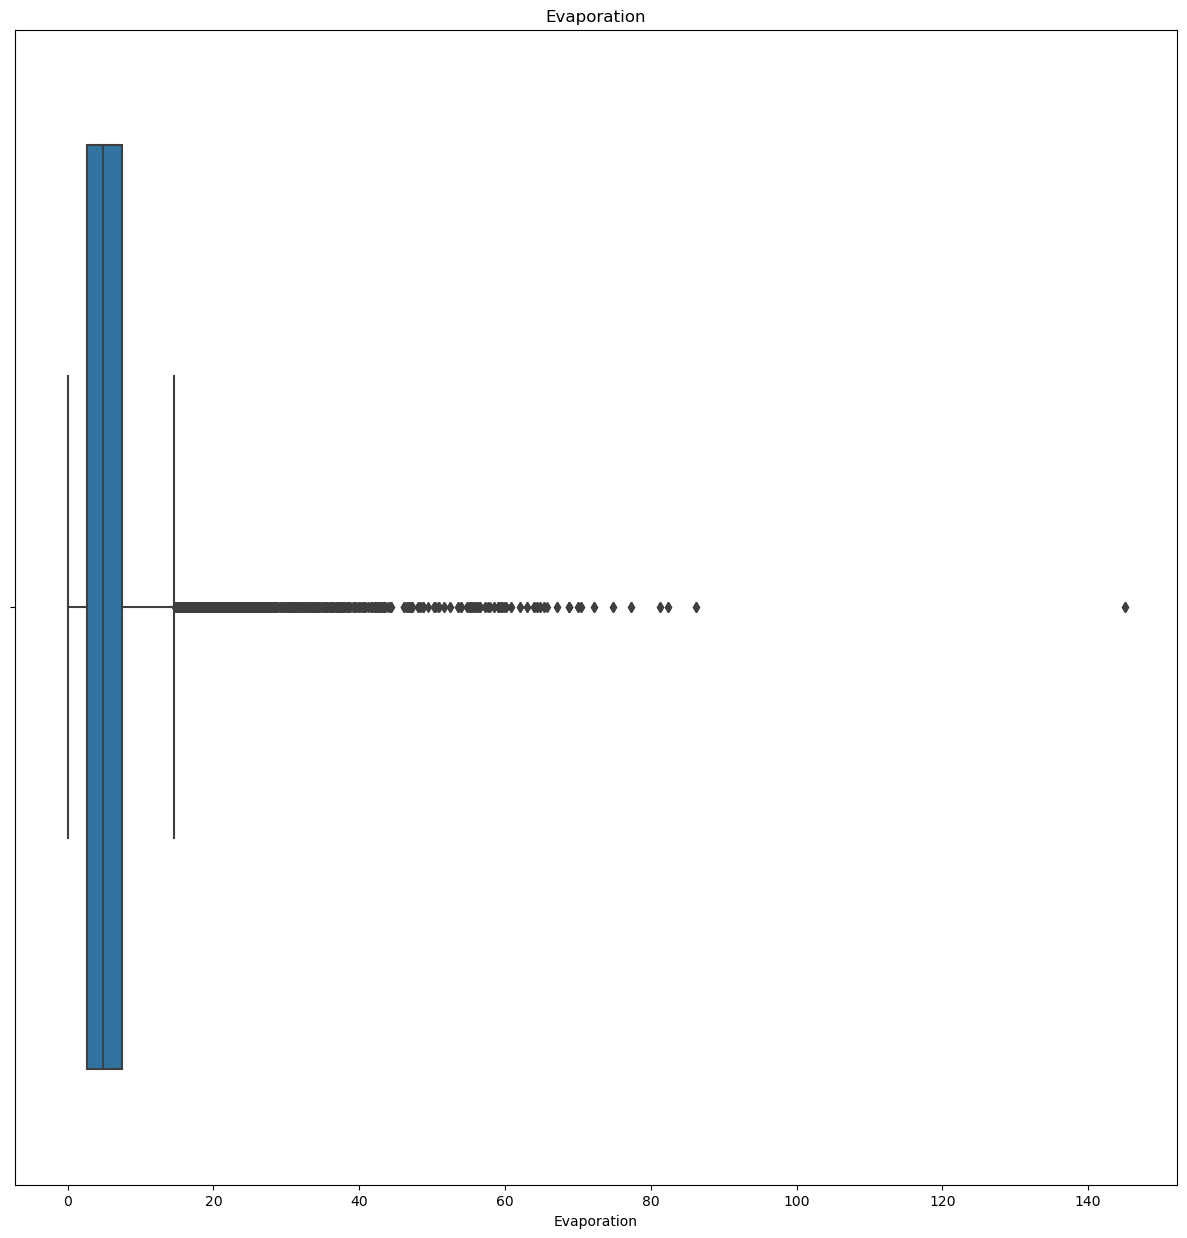

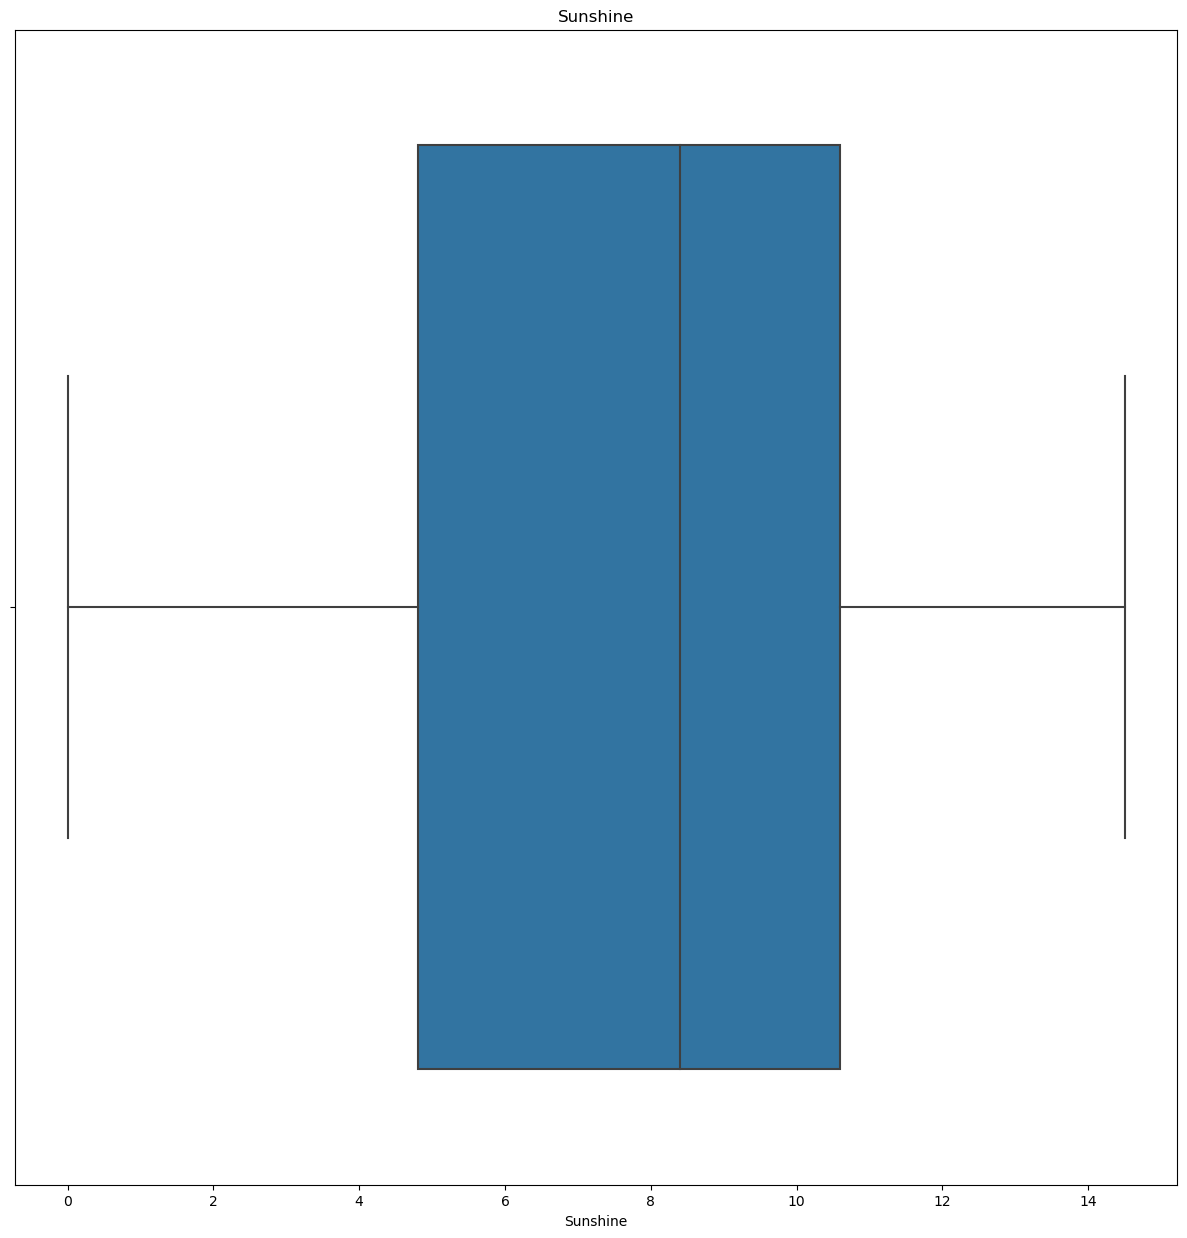

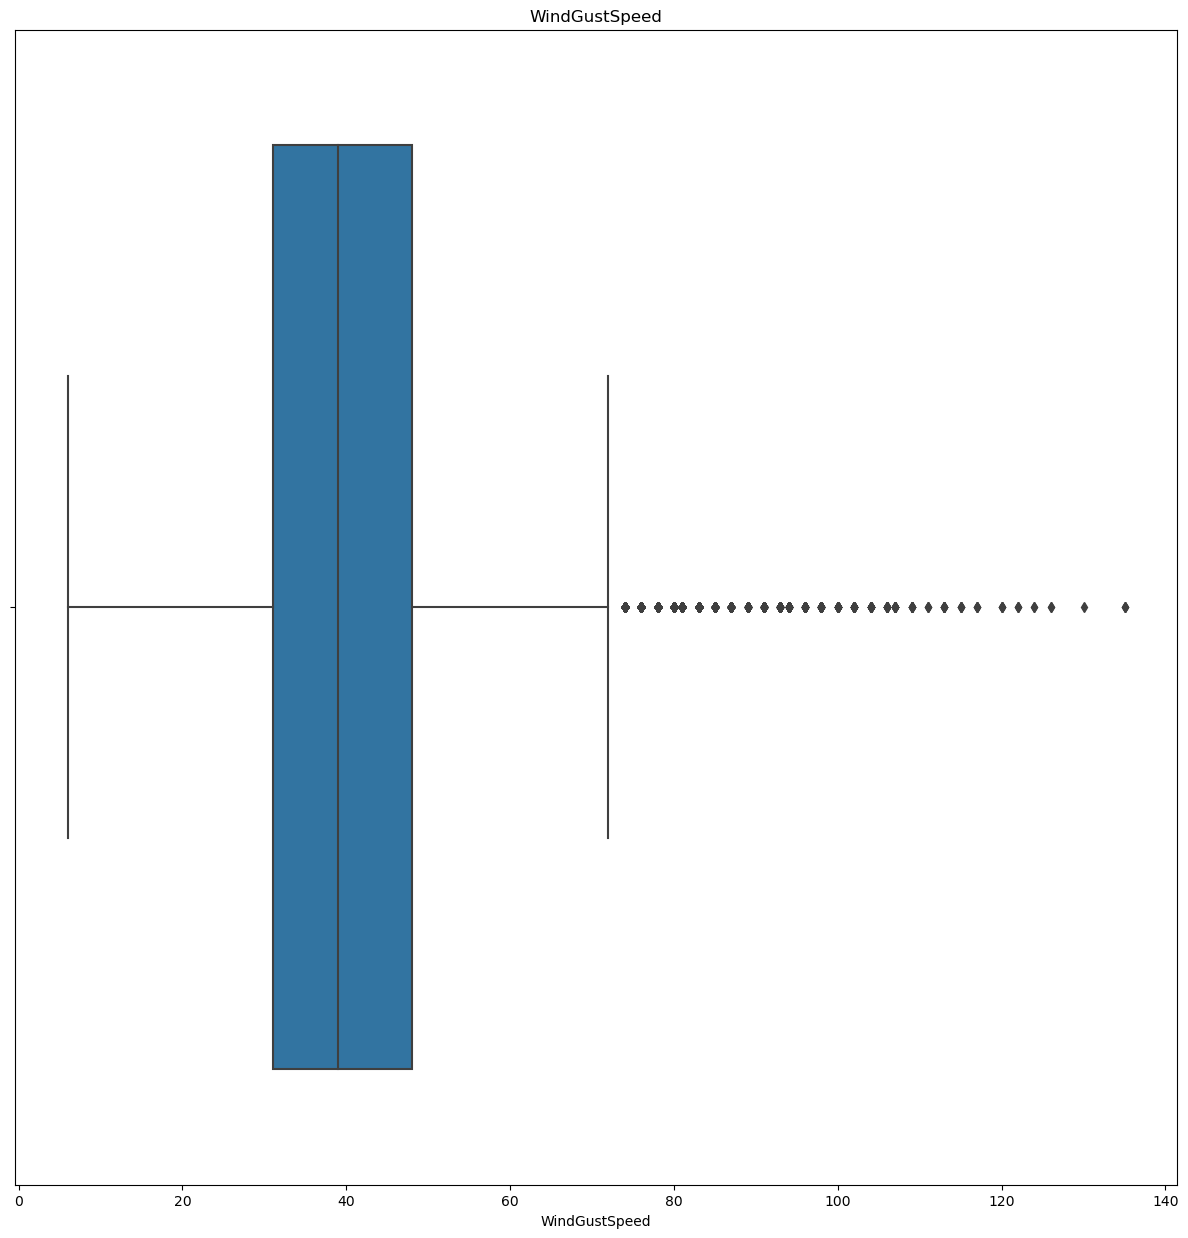

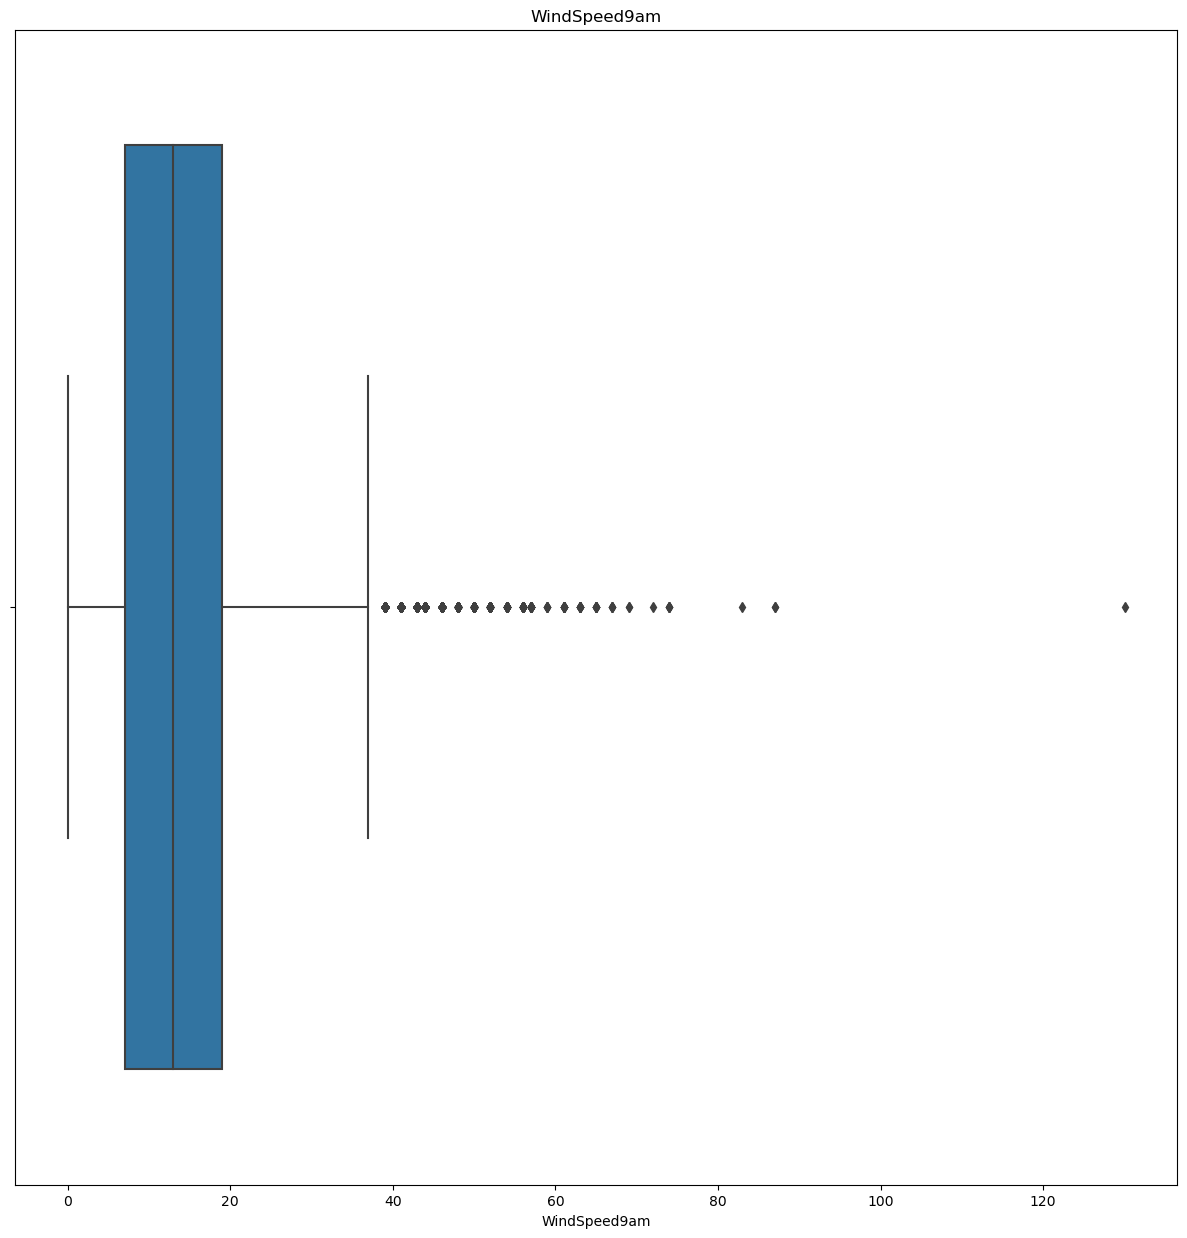

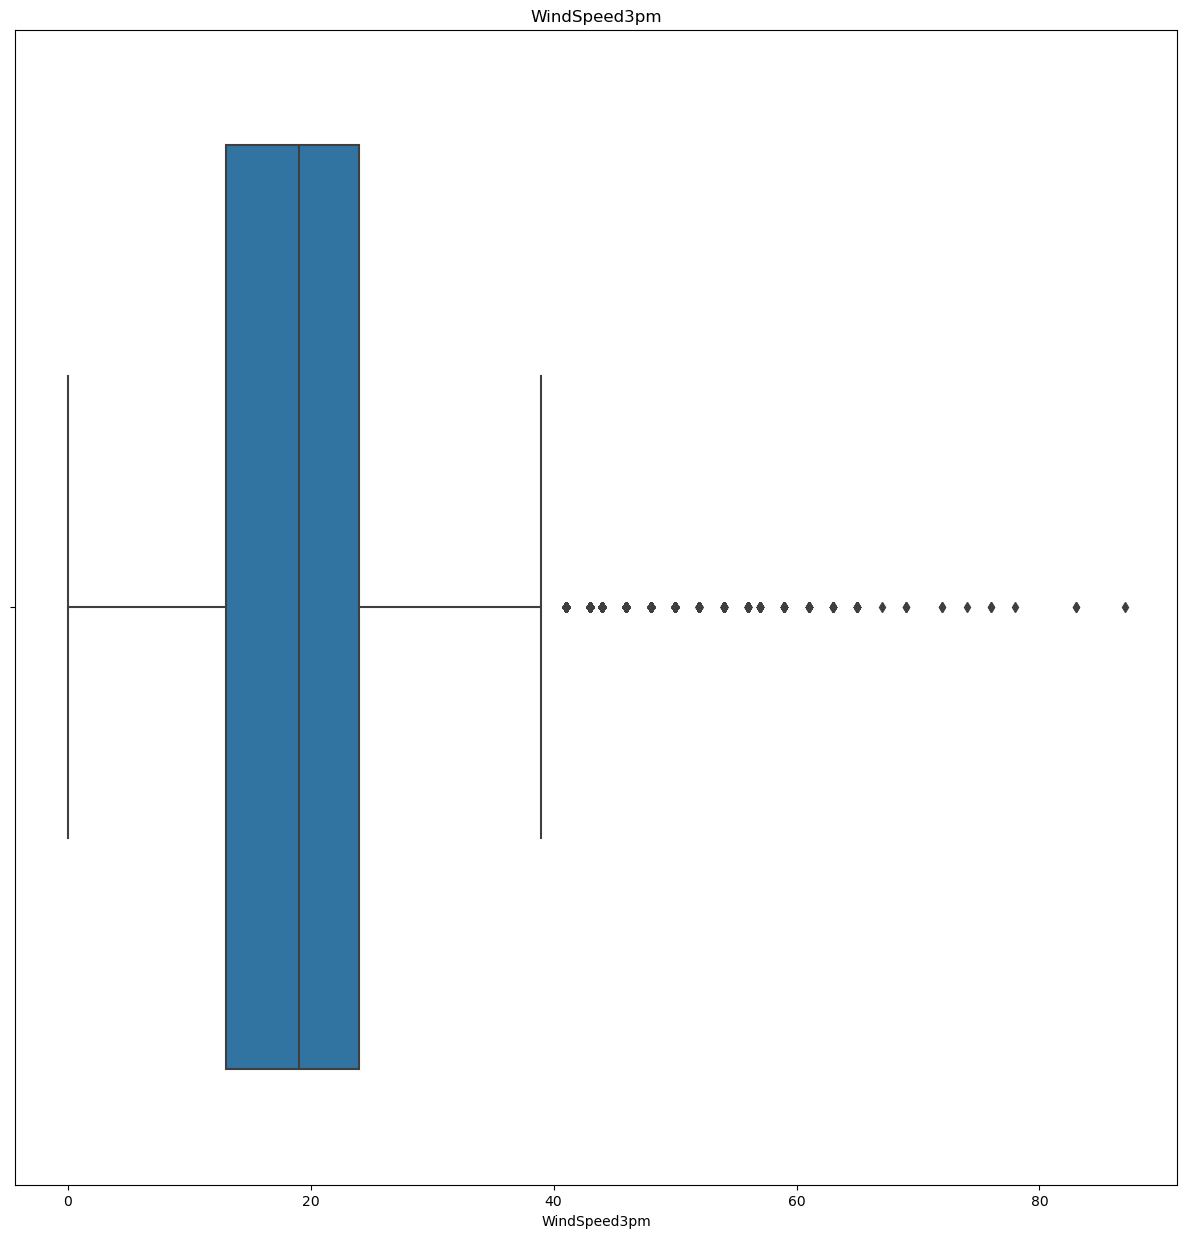

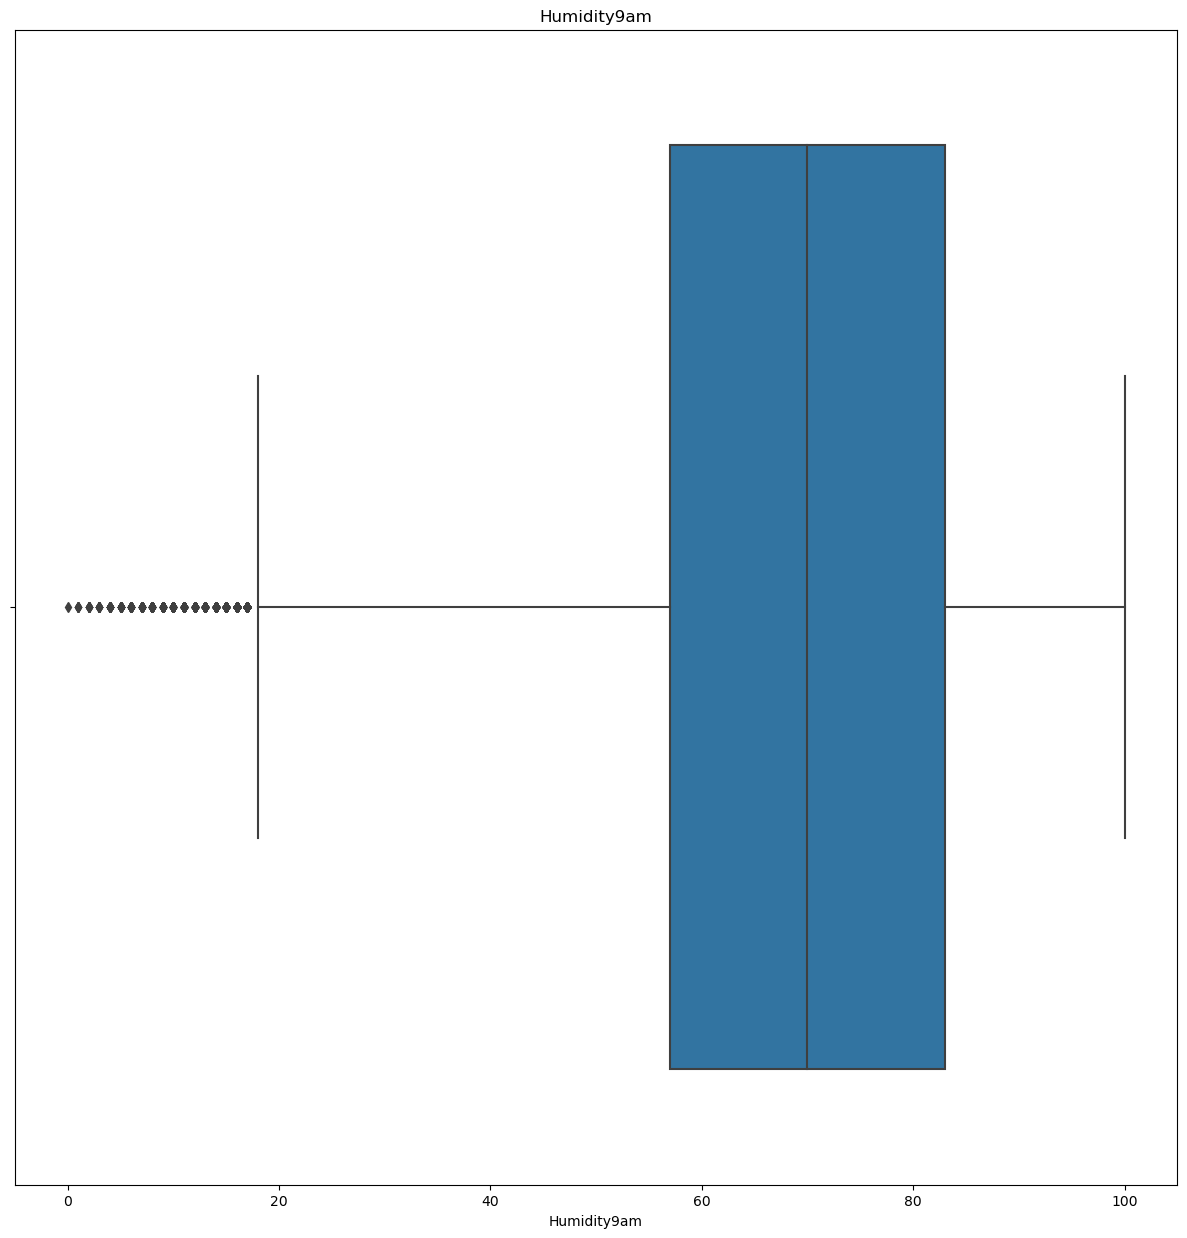

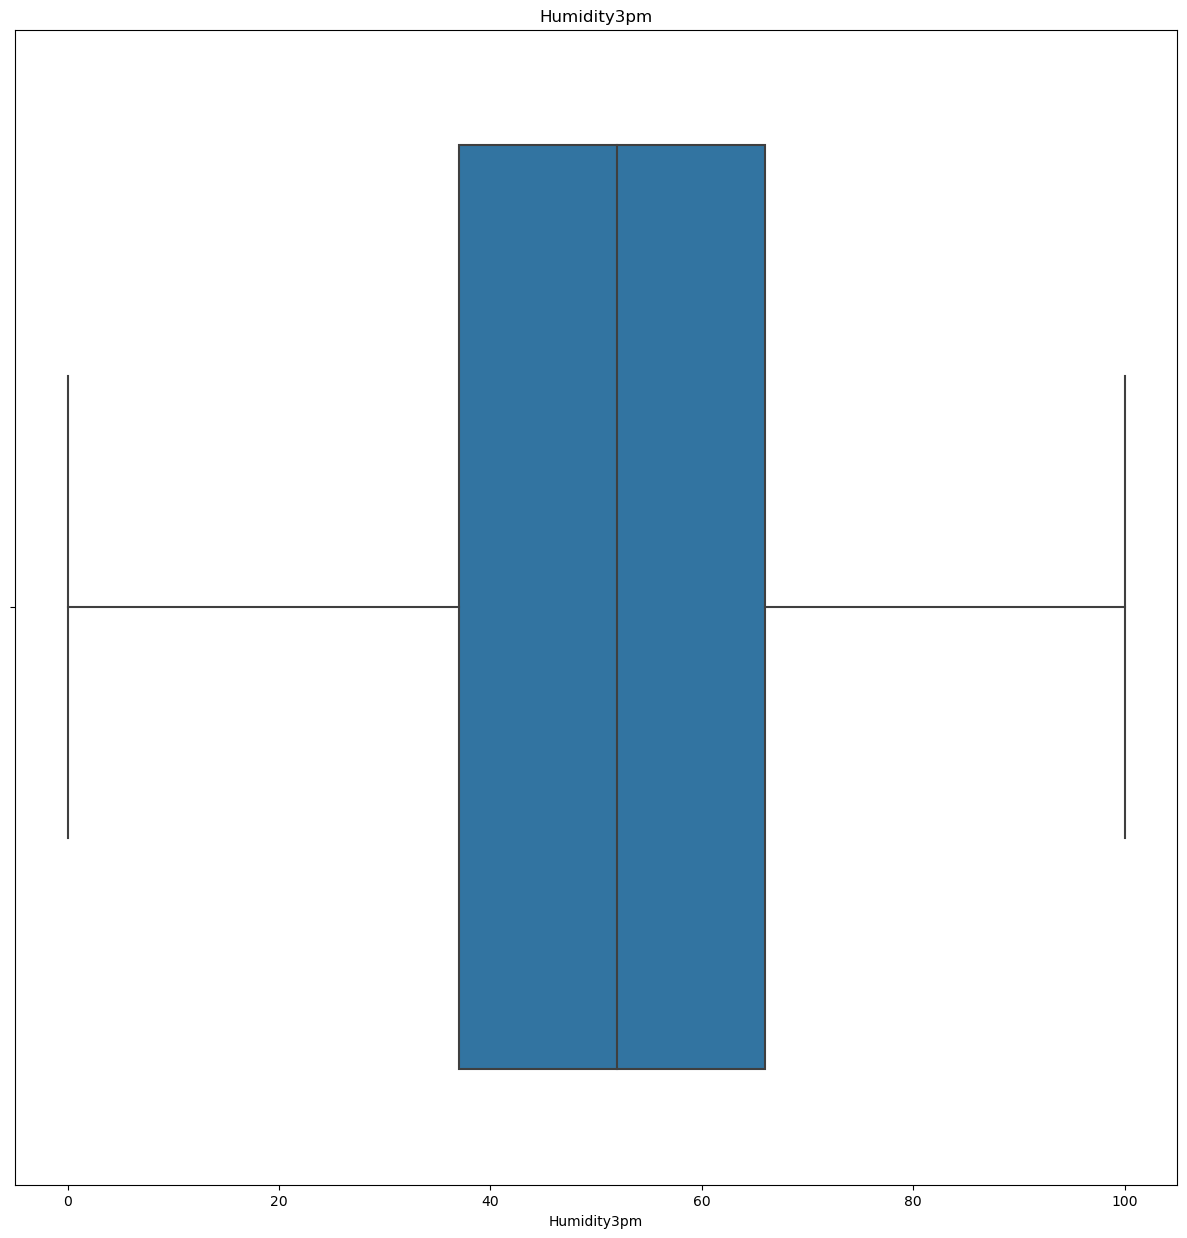

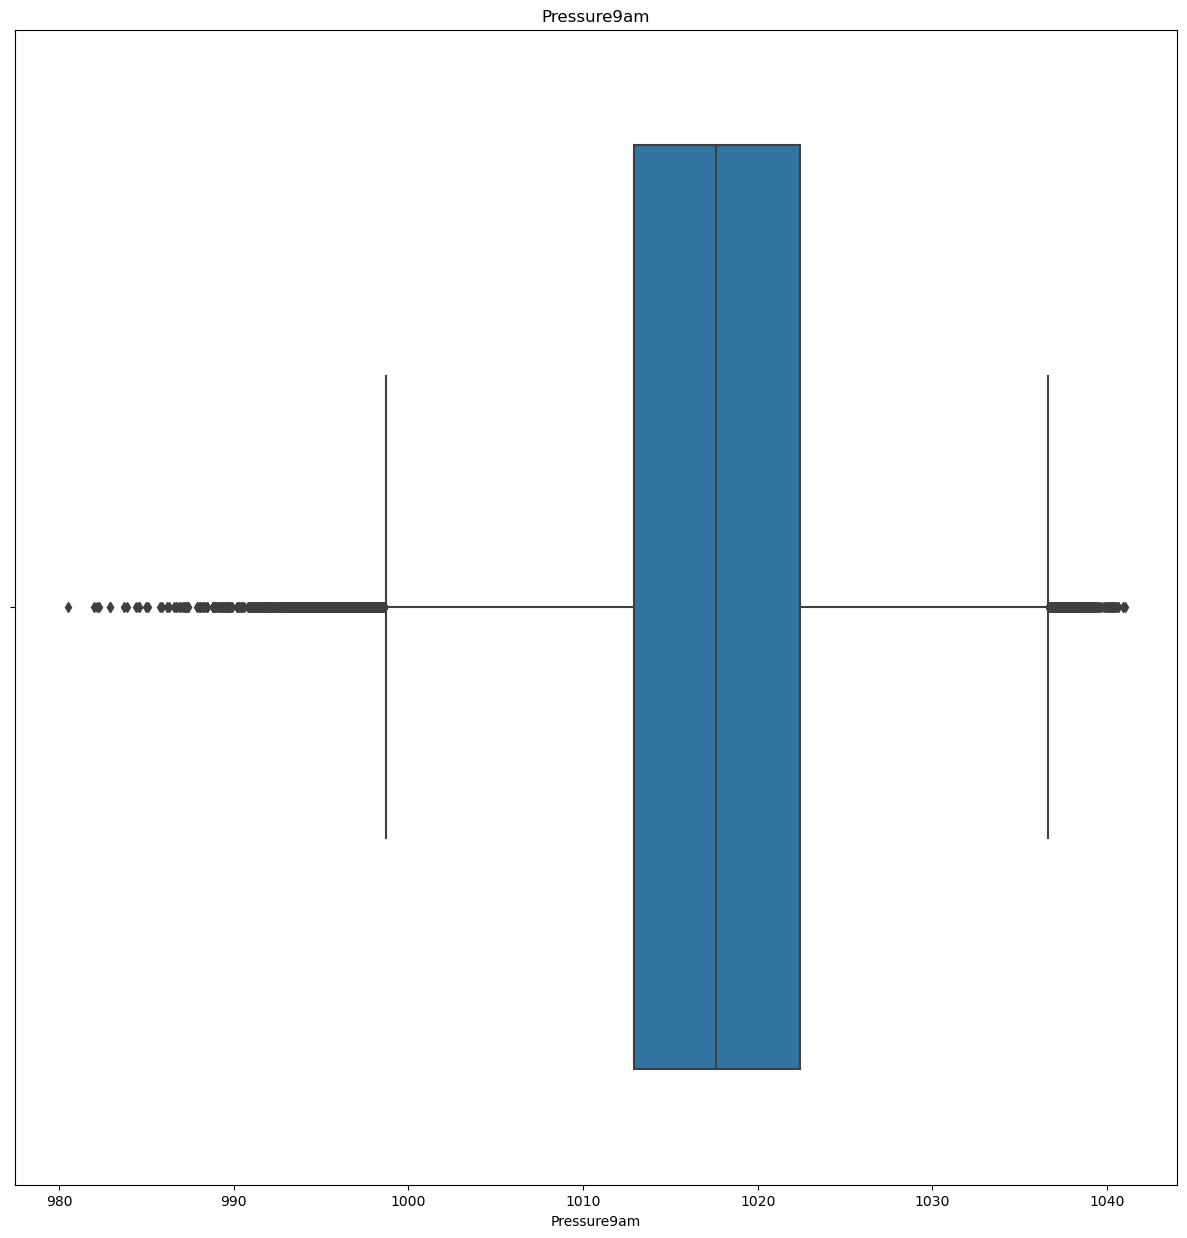

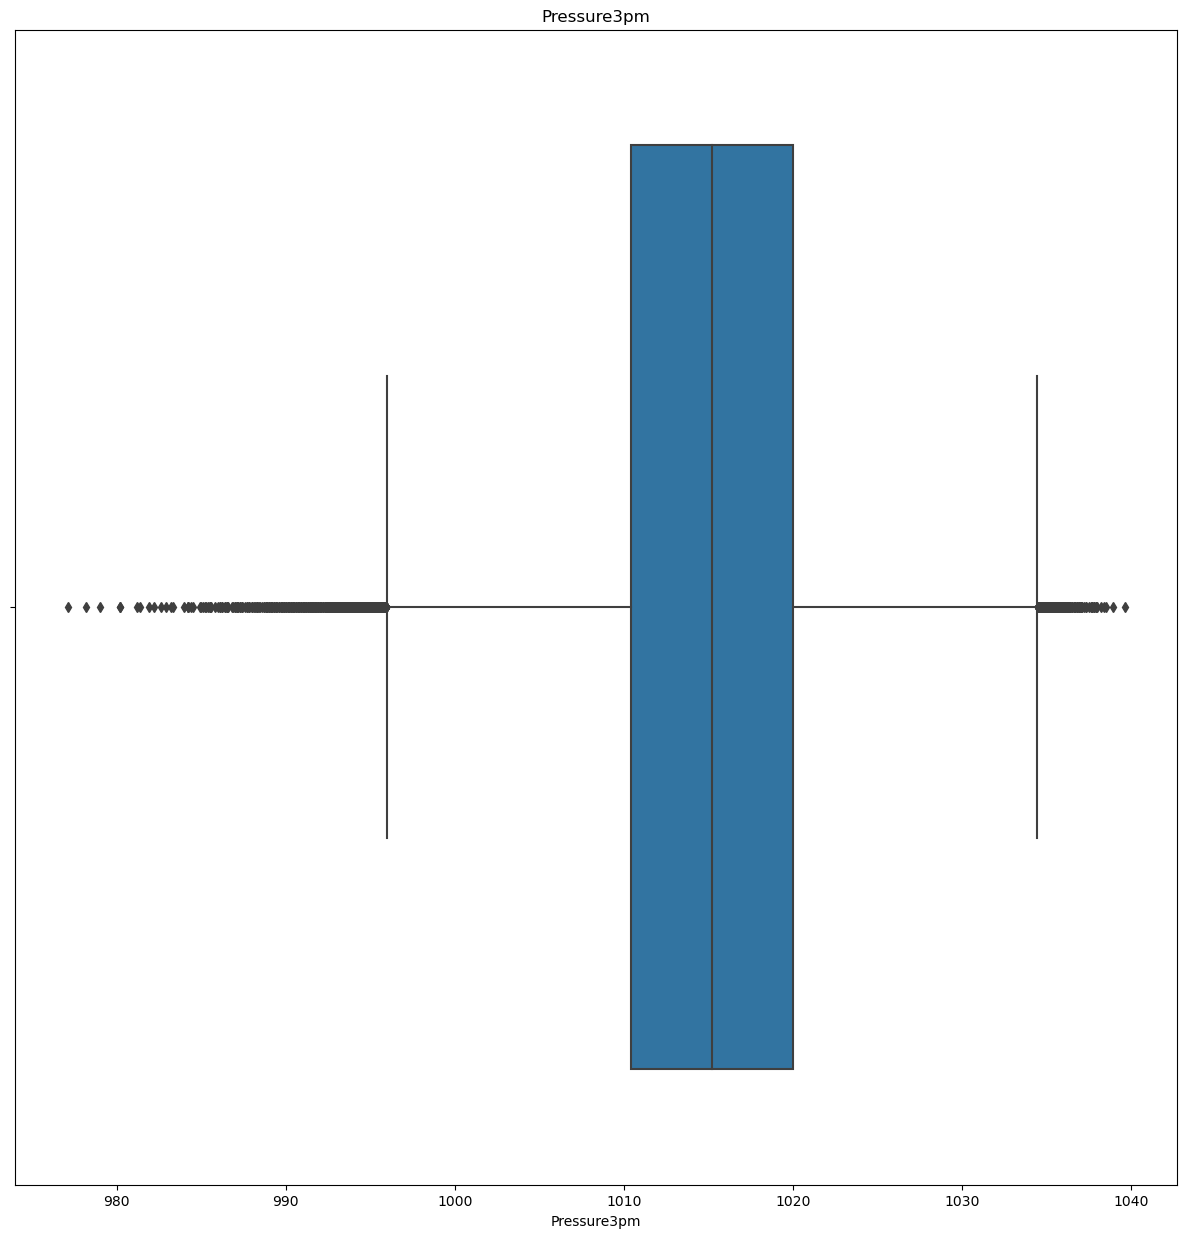

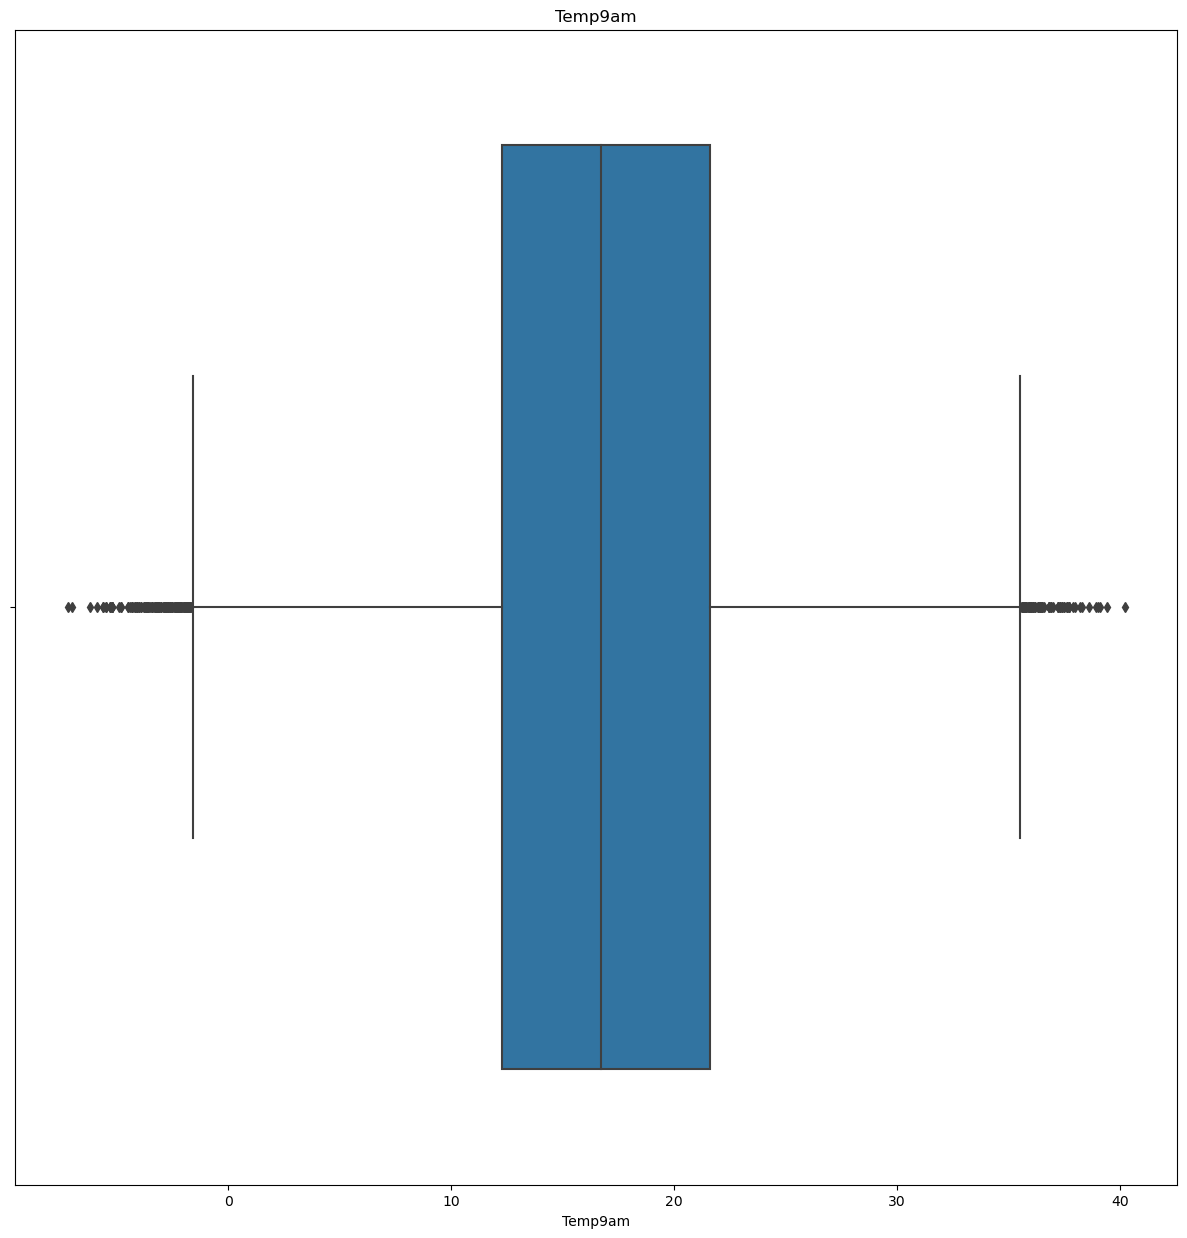

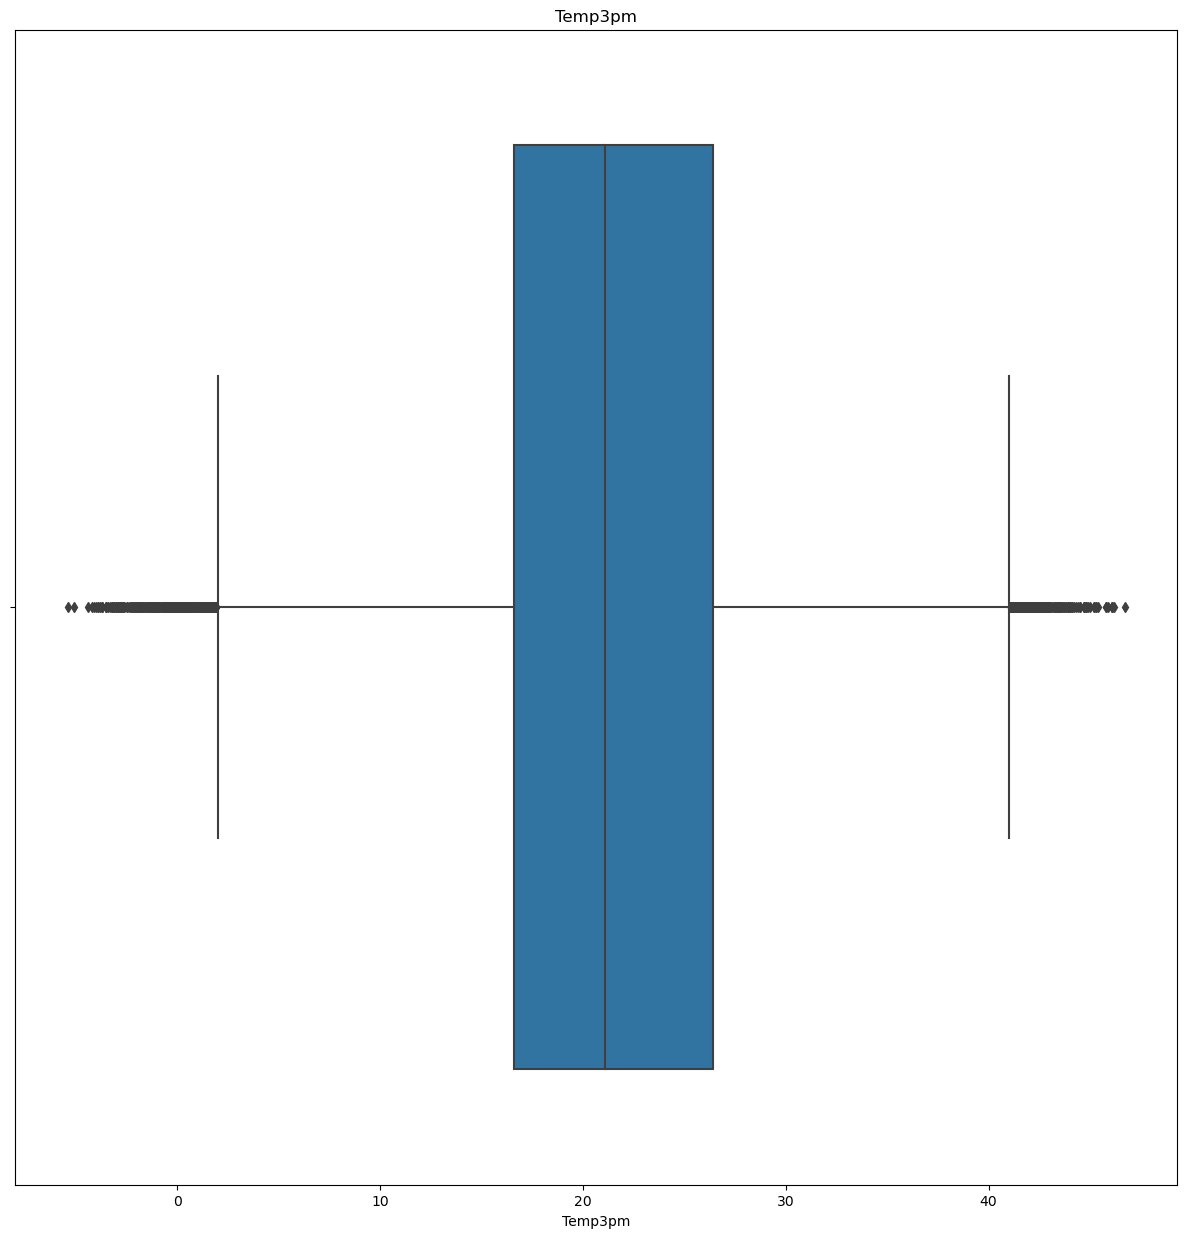

<Figure size 1500x1500 with 0 Axes>

In [12]:
#A for loop is used to plot a boxplot for all the continuous features to see the outliers
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [13]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [14]:
df.isnull().sum()*100/len(df)

Date                  0.000000
Location              0.000000
MinTemp               0.000000
MaxTemp               0.000000
Rainfall              0.000000
Evaporation           0.000000
Sunshine              0.000000
WindGustDir           7.098859
WindGustSpeed         0.000000
WindDir9am            7.263853
WindDir3pm            2.906641
WindSpeed9am          0.000000
WindSpeed3pm          0.000000
Humidity9am           0.000000
Humidity3pm           0.000000
Pressure9am           0.000000
Pressure3pm           0.000000
Cloud9am              0.000000
Cloud3pm              0.000000
Temp9am               0.000000
Temp3pm               0.000000
CloudBurst Today      2.241853
CloudBurstTomorrow    2.245978
dtype: float64

In [15]:
discrete_feature

['Cloud9am', 'Cloud3pm']

In [16]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

In [19]:
df["CloudBurst Today"] = pd.get_dummies(df["CloudBurst Today"], drop_first = True)
df["CloudBurstTomorrow"] = pd.get_dummies(df["CloudBurstTomorrow"], drop_first = True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,02-12-2008,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,03-12-2008,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,04-12-2008,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,05-12-2008,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,22-06-2017,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,23-06-2017,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,24-06-2017,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [21]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["CloudBurstTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['19-12-2007', '30-01-2008', '24-12-2007', '13-04-2008', '19-06-2008',
       '02-11-2007', '03-11-2007', '20-12-2007', '03-12-2007', '21-12-2007',
       ...
       '29-04-2008', '25-04-2008', '14-01-2008', '14-02-2008', '19-08-2008',
       '29-03-2008', '29-02-2008', '08-03-2008', '19-07-2008', '01-01-2008'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'NorfolkIsland',
       'MountGambier', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'MountGinini',
       'NorahHead', 'Darwin', 'Sydney', 'SydneyAirport', 'Ballarat',
       'GoldCoast', 'Watsonia', 'Newcastle', 'Hobart', 'Wollongong',
       'Williamtown', 'Launceston', 'Brisbane', 'MelbourneAirport', 'Adelaide',
       'Sale', 'Albury', 'Perth', 'Melbourne', 'Nuriootpa', 'Penrith',
       'BadgerysCreek', 'PerthAirport', 'Tuggeranong', 'Richmond', 'Bendigo',
       'Canberra', 'WaggaWagga', 'Townsville', 'Katherine', 'PearceRAAF',
       'SalmonGums', 'Nhil', 

In [22]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)

In [23]:
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])

In [24]:
df.isnull().sum()*100/len(df)

Date                  0.0
Location              0.0
MinTemp               0.0
MaxTemp               0.0
Rainfall              0.0
Evaporation           0.0
Sunshine              0.0
WindGustDir           0.0
WindGustSpeed         0.0
WindDir9am            0.0
WindDir3pm            0.0
WindSpeed9am          0.0
WindSpeed3pm          0.0
Humidity9am           0.0
Humidity3pm           0.0
Pressure9am           0.0
Pressure3pm           0.0
Cloud9am              0.0
Cloud3pm              0.0
Temp9am               0.0
Temp3pm               0.0
CloudBurst Today      0.0
CloudBurstTomorrow    0.0
dtype: float64

In [25]:
df1 = df.groupby(["Location"])["CloudBurstTomorrow"].value_counts().sort_values().unstack()

In [26]:
df1

CloudBurstTomorrow,0,1
Location,,
Adelaide,2505,688
Albany,2138,902
Albury,2422,618
AliceSprings,2796,244
BadgerysCreek,2426,583
Ballarat,2259,781
Bendigo,2478,562
Brisbane,2484,709
Cairns,2090,950


In [27]:
df1[1].sort_values(ascending = False)

Location
Portland            1095
Cairns               950
Walpole              949
Dartmoor             922
MountGambier         920
NorfolkIsland        919
Albany               902
Witchcliffe          879
CoffsHarbour         869
Sydney               865
Darwin               852
MountGinini          819
NorahHead            808
Ballarat             781
GoldCoast            775
SydneyAirport        774
Hobart               761
Watsonia             738
Newcastle            731
Wollongong           713
Brisbane             709
Williamtown          700
Launceston           699
Adelaide             688
MelbourneAirport     653
Perth                645
Sale                 643
Melbourne            636
Canberra             629
Albury               618
Penrith              595
Nuriootpa            592
BadgerysCreek        583
Tuggeranong          568
PerthAirport         567
Bendigo              562
Richmond             560
WaggaWagga           536
Townsville           519
PearceRAAF      

In [28]:
df1[1].sort_values(ascending = False).index

Index(['Portland', 'Cairns', 'Walpole', 'Dartmoor', 'MountGambier',
       'NorfolkIsland', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'Sydney',
       'Darwin', 'MountGinini', 'NorahHead', 'Ballarat', 'GoldCoast',
       'SydneyAirport', 'Hobart', 'Watsonia', 'Newcastle', 'Wollongong',
       'Brisbane', 'Williamtown', 'Launceston', 'Adelaide', 'MelbourneAirport',
       'Perth', 'Sale', 'Melbourne', 'Canberra', 'Albury', 'Penrith',
       'Nuriootpa', 'BadgerysCreek', 'Tuggeranong', 'PerthAirport', 'Bendigo',
       'Richmond', 'WaggaWagga', 'Townsville', 'PearceRAAF', 'SalmonGums',
       'Moree', 'Cobar', 'Mildura', 'Katherine', 'AliceSprings', 'Nhil',
       'Woomera', 'Uluru'],
      dtype='object', name='Location')

In [29]:
len(df1[1].sort_values(ascending = False).index)

49

In [30]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}
df["Location"] = df["Location"].map(location)

In [31]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [32]:
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [33]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow,Date_month,Date_day
0,NaT,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,NaN,NaN
1,NaT,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,NaN,NaN
2,NaT,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,NaN,NaN
3,NaT,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,NaN,NaN
4,NaT,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,NaT,49,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,NaN,NaN
145456,NaT,49,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,NaN,NaN
145457,NaT,49,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,NaN,NaN
145458,NaT,49,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,NaN,NaN


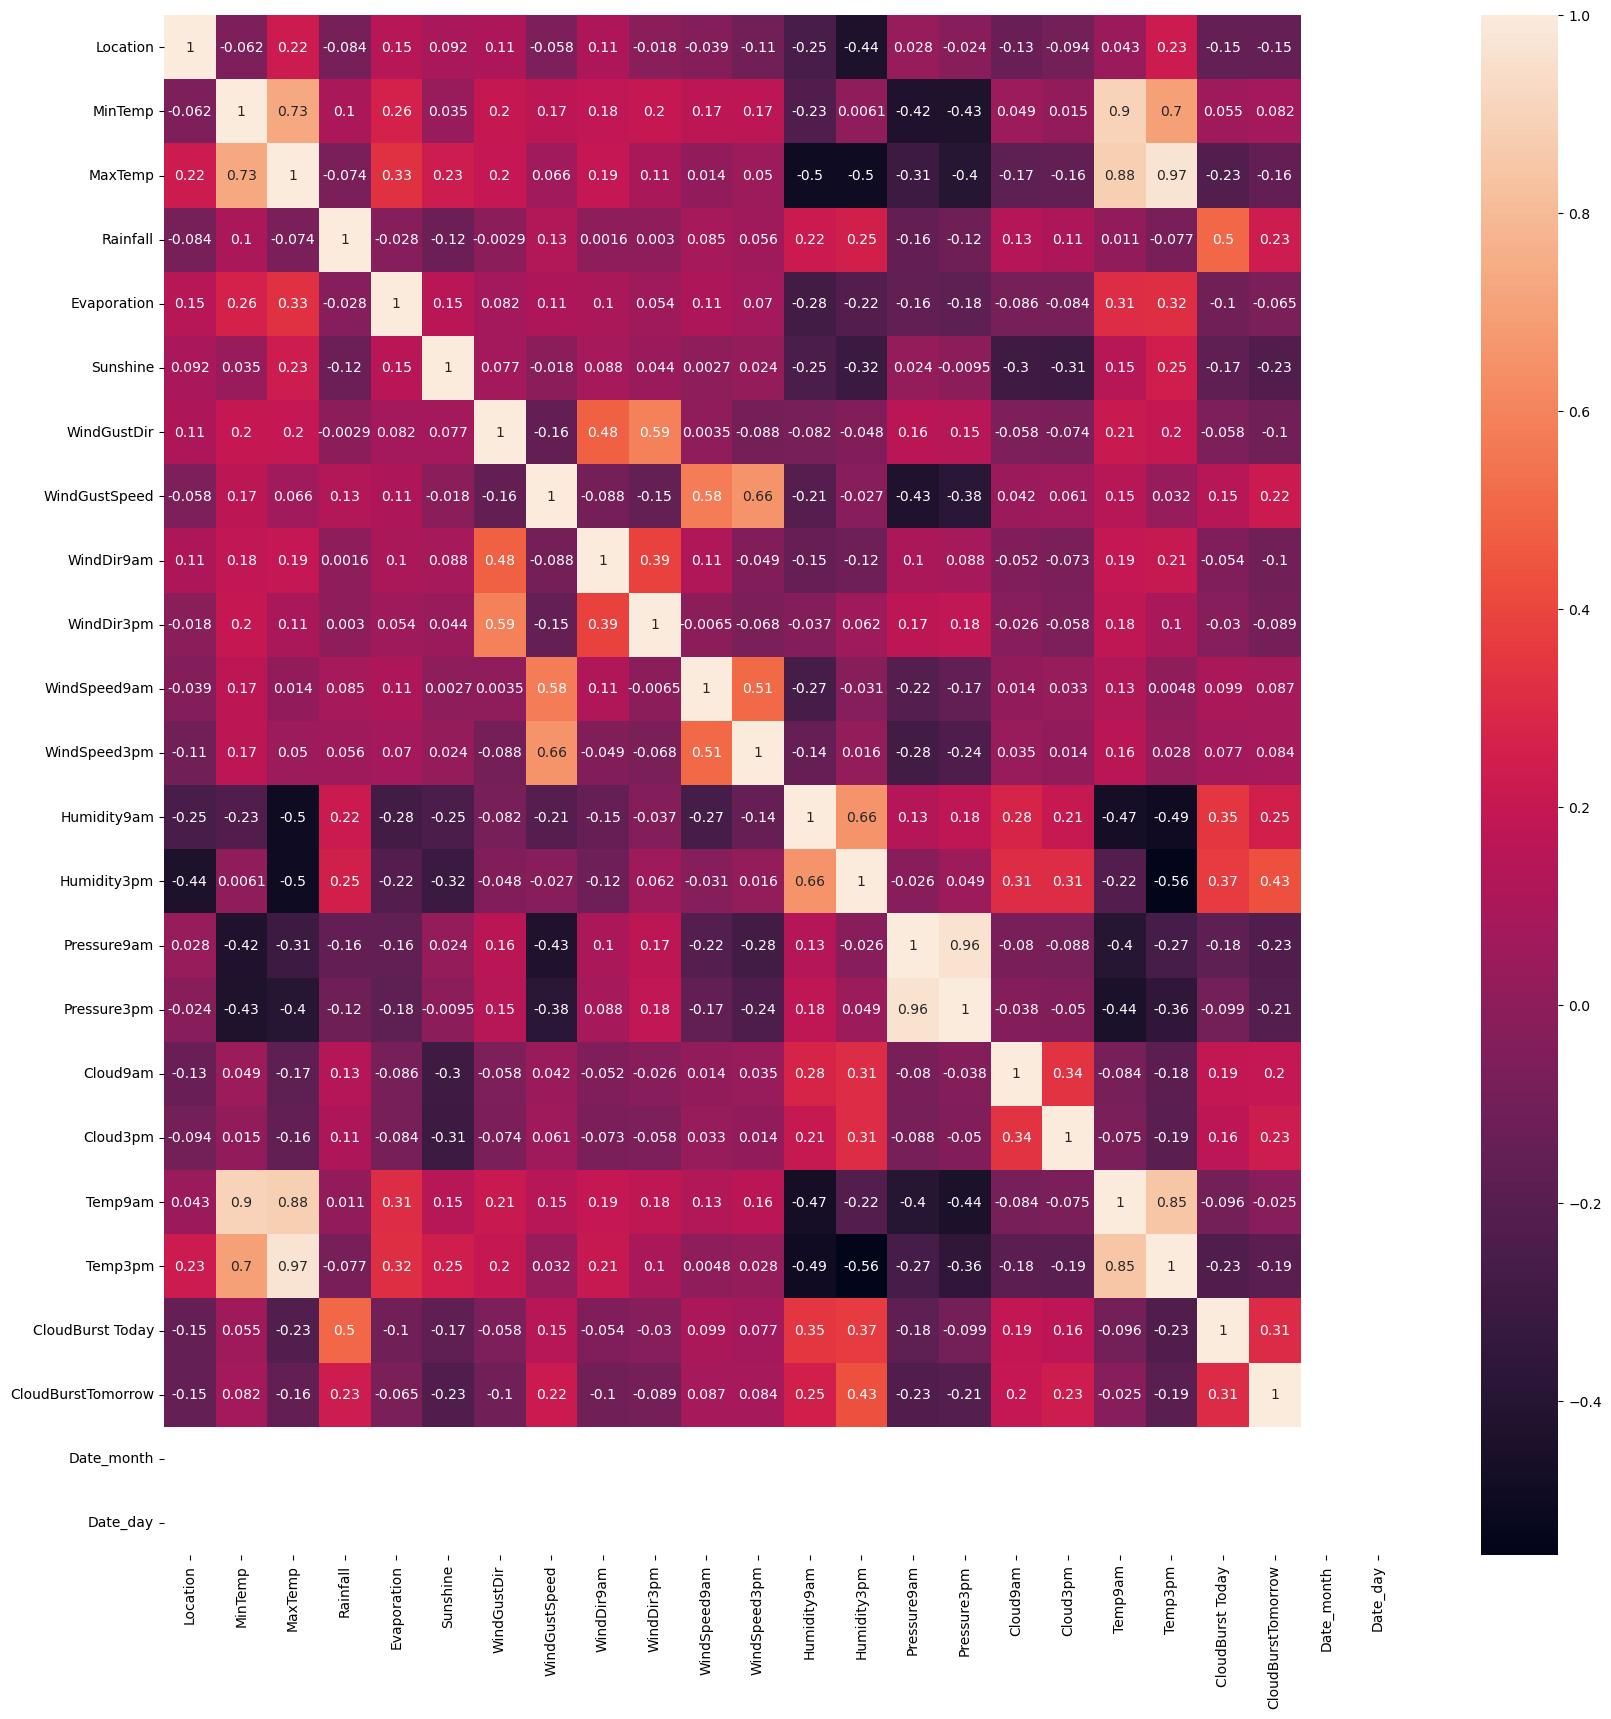

In [34]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CloudBurstTomorrow', ylabel='count'>

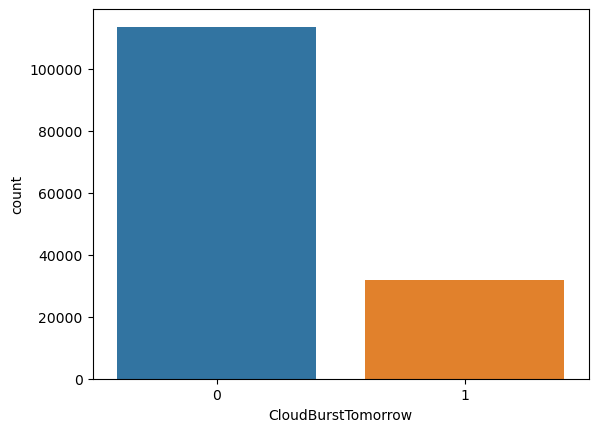

In [35]:
sns.countplot(df["CloudBurstTomorrow"])

In [36]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow,Date_month,Date_day
0,NaT,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,NaN,NaN
1,NaT,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,NaN,NaN
2,NaT,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,NaN,NaN
3,NaT,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,NaN,NaN
4,NaT,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,NaT,49,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,NaN,NaN
145456,NaT,49,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,NaN,NaN
145457,NaT,49,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,NaN,NaN
145458,NaT,49,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,NaN,NaN


C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zeel sh

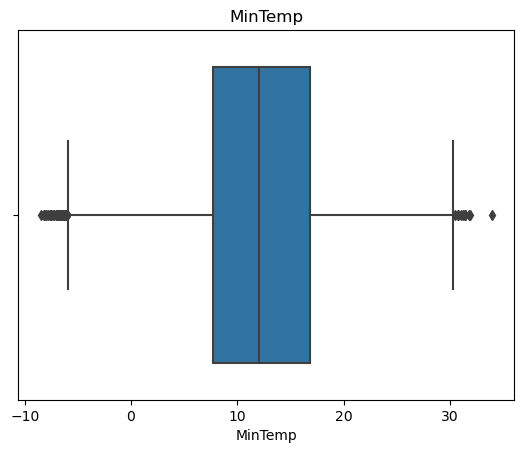

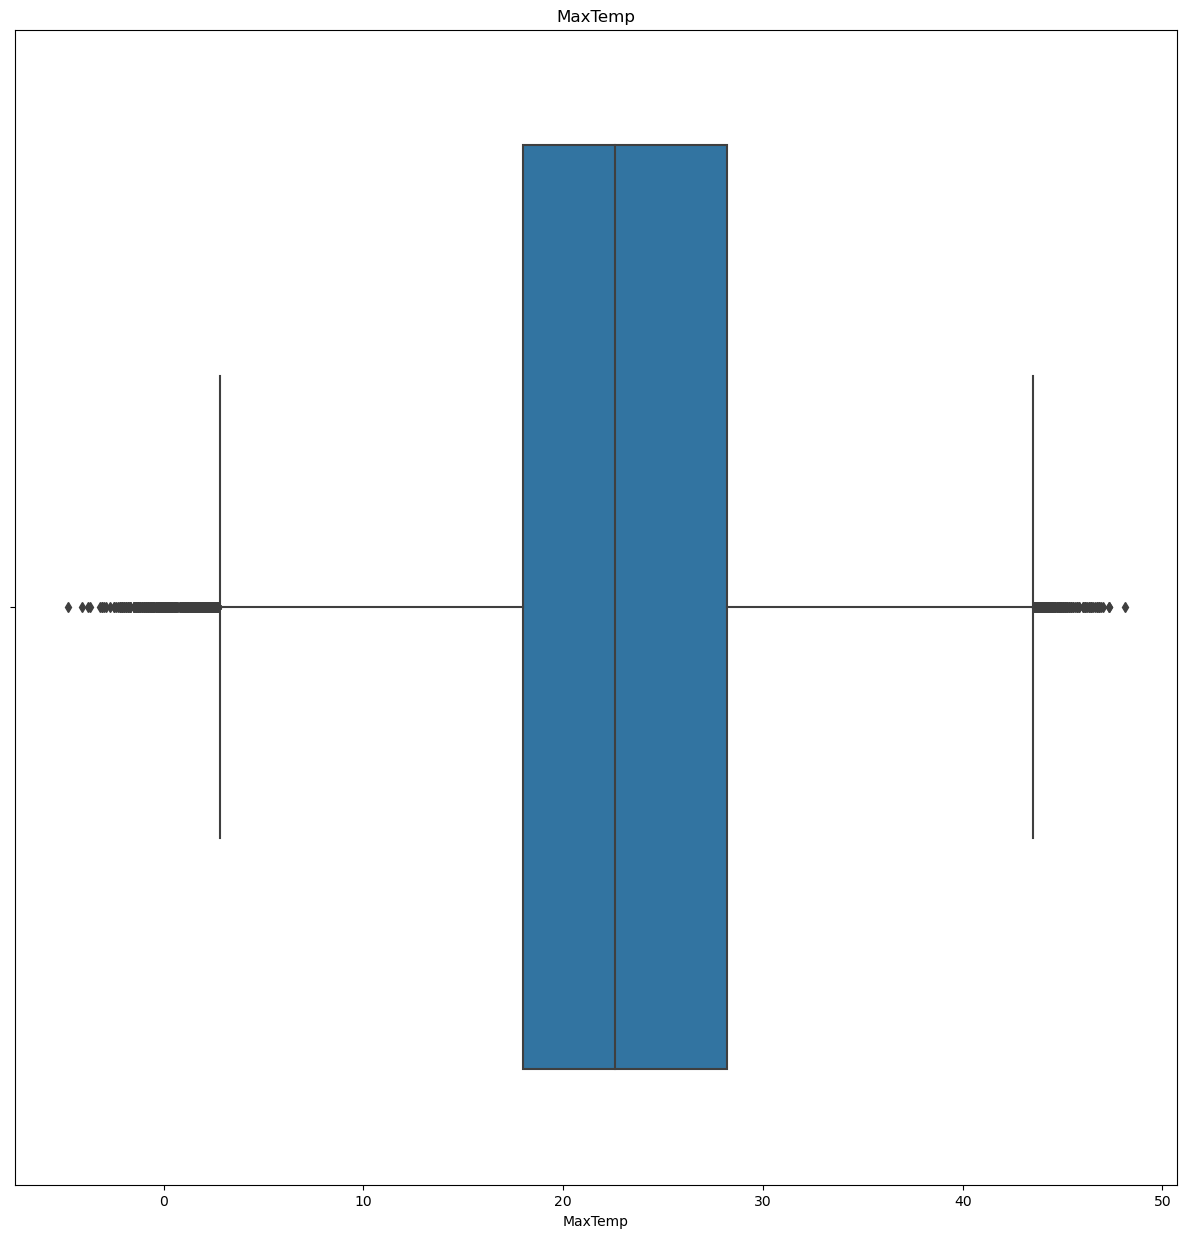

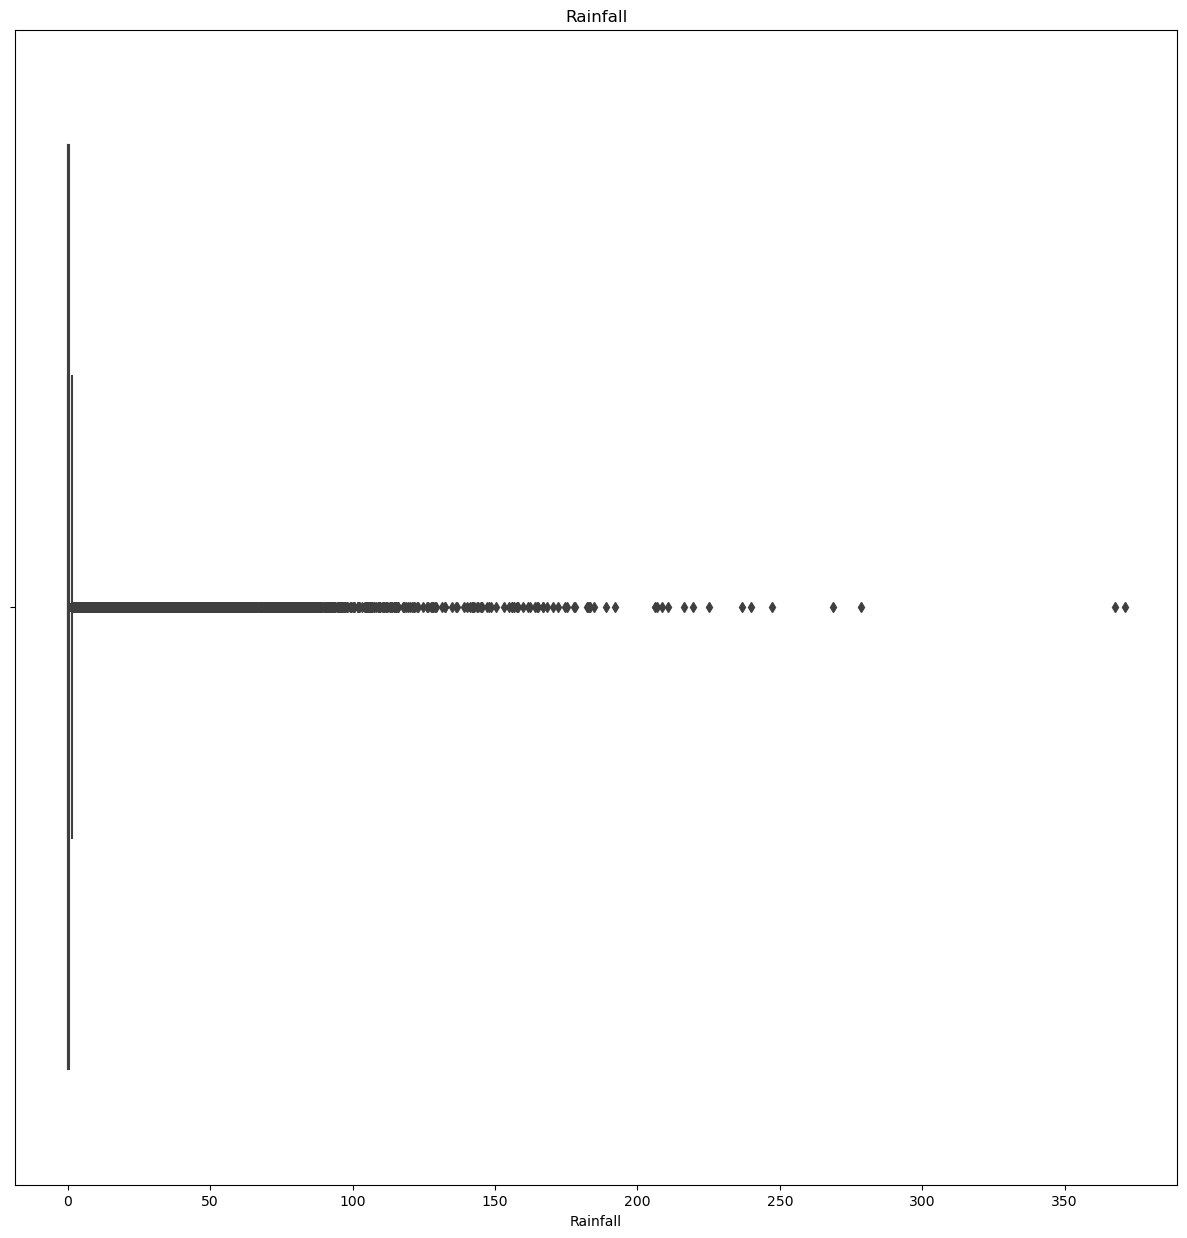

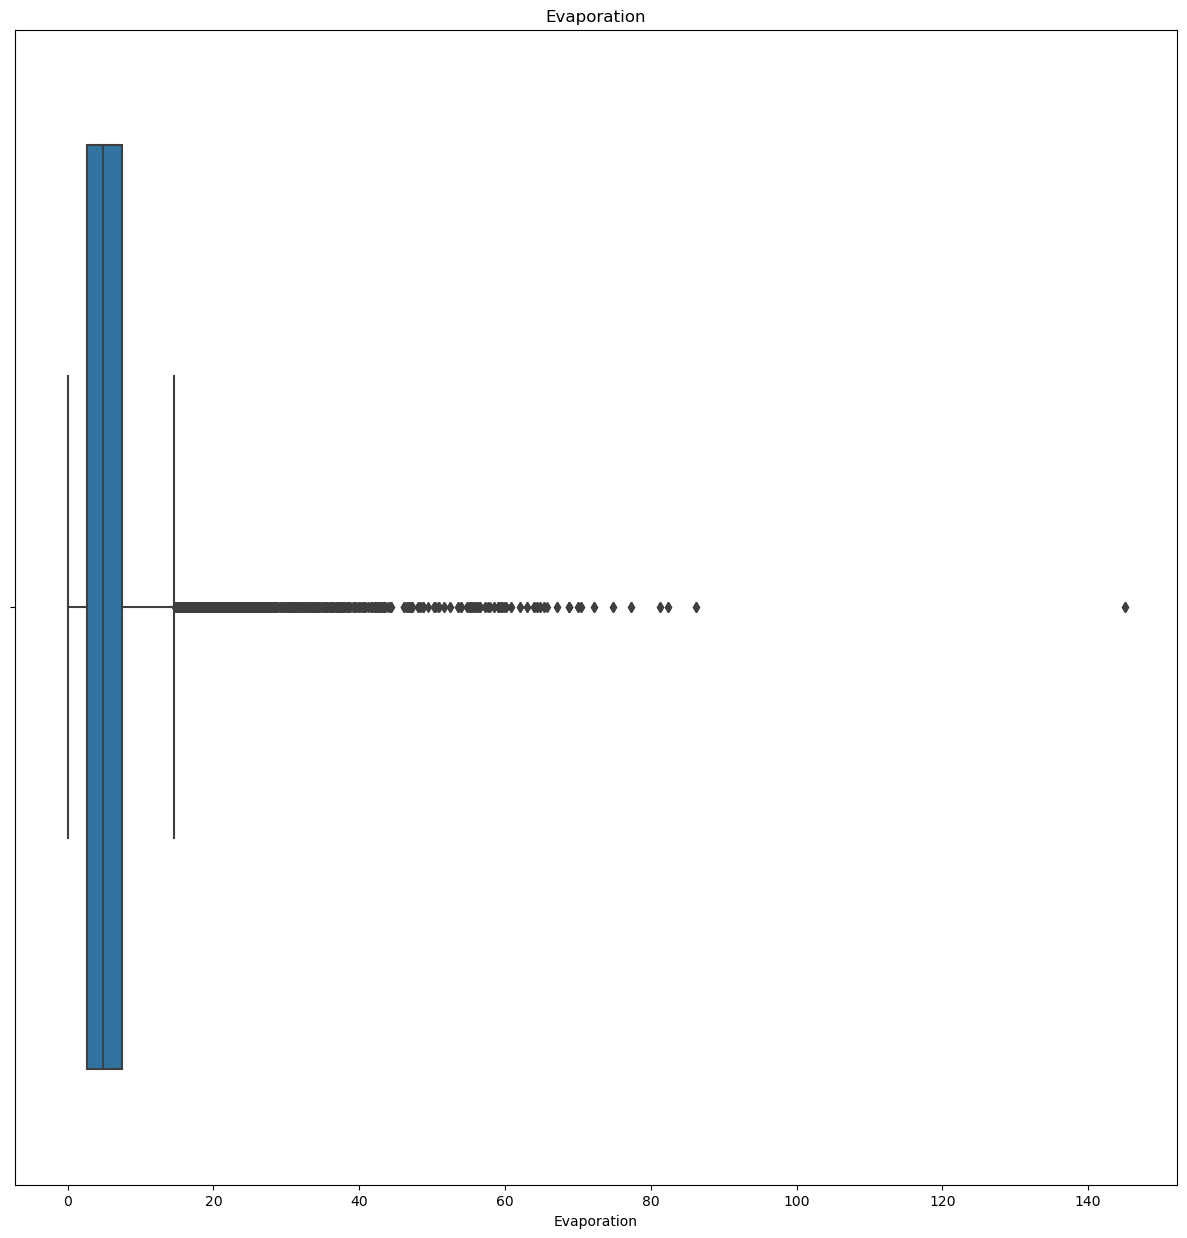

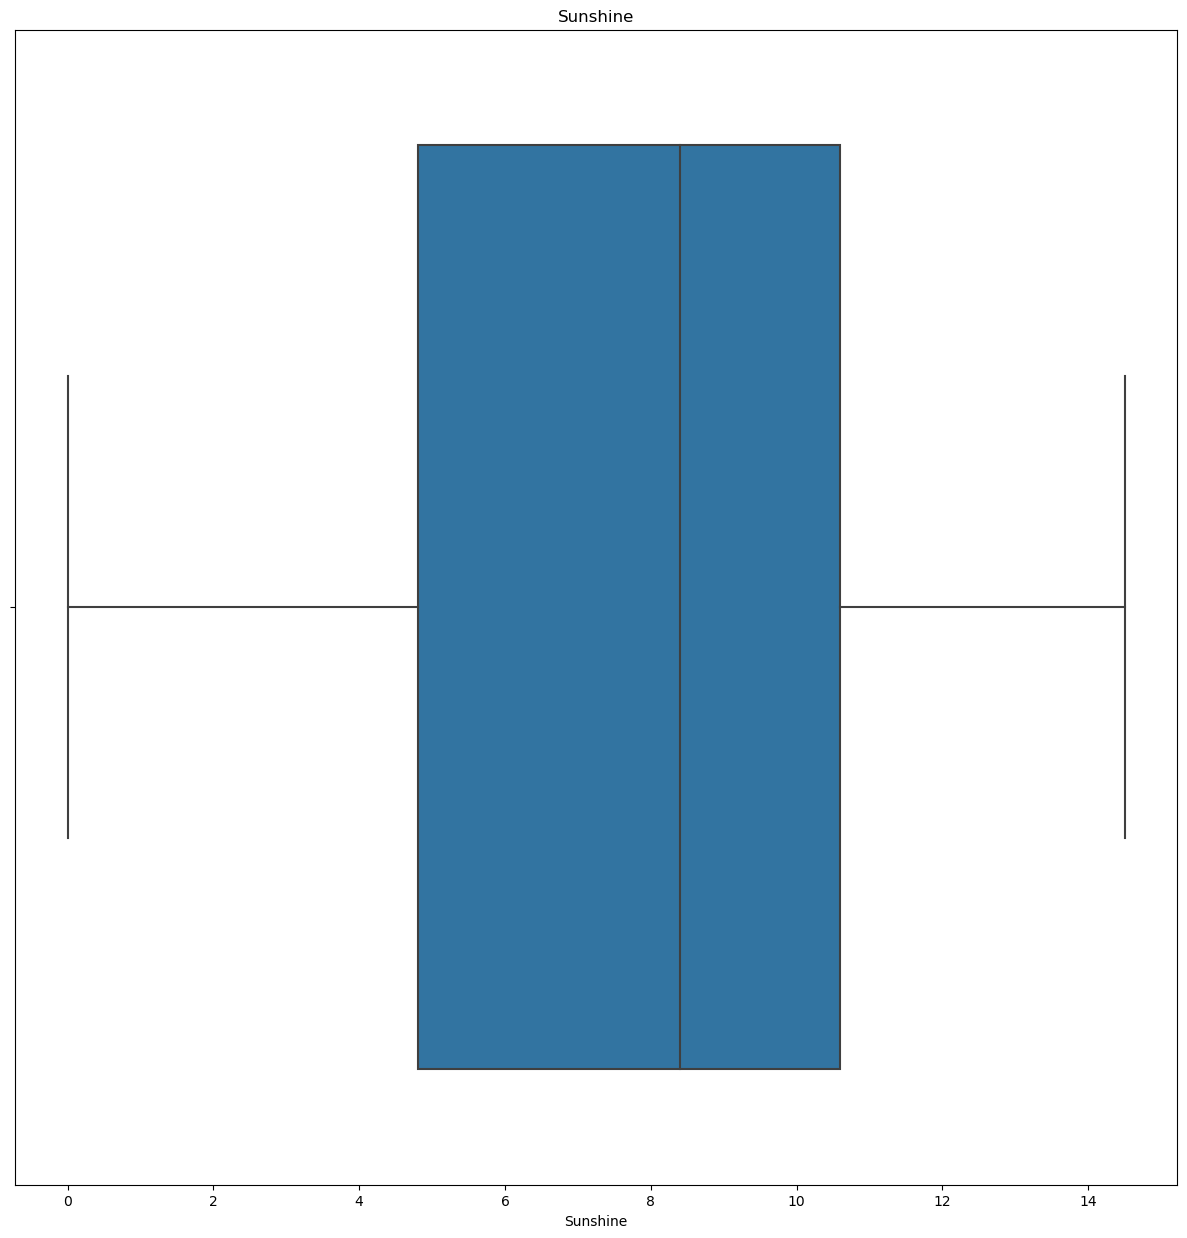

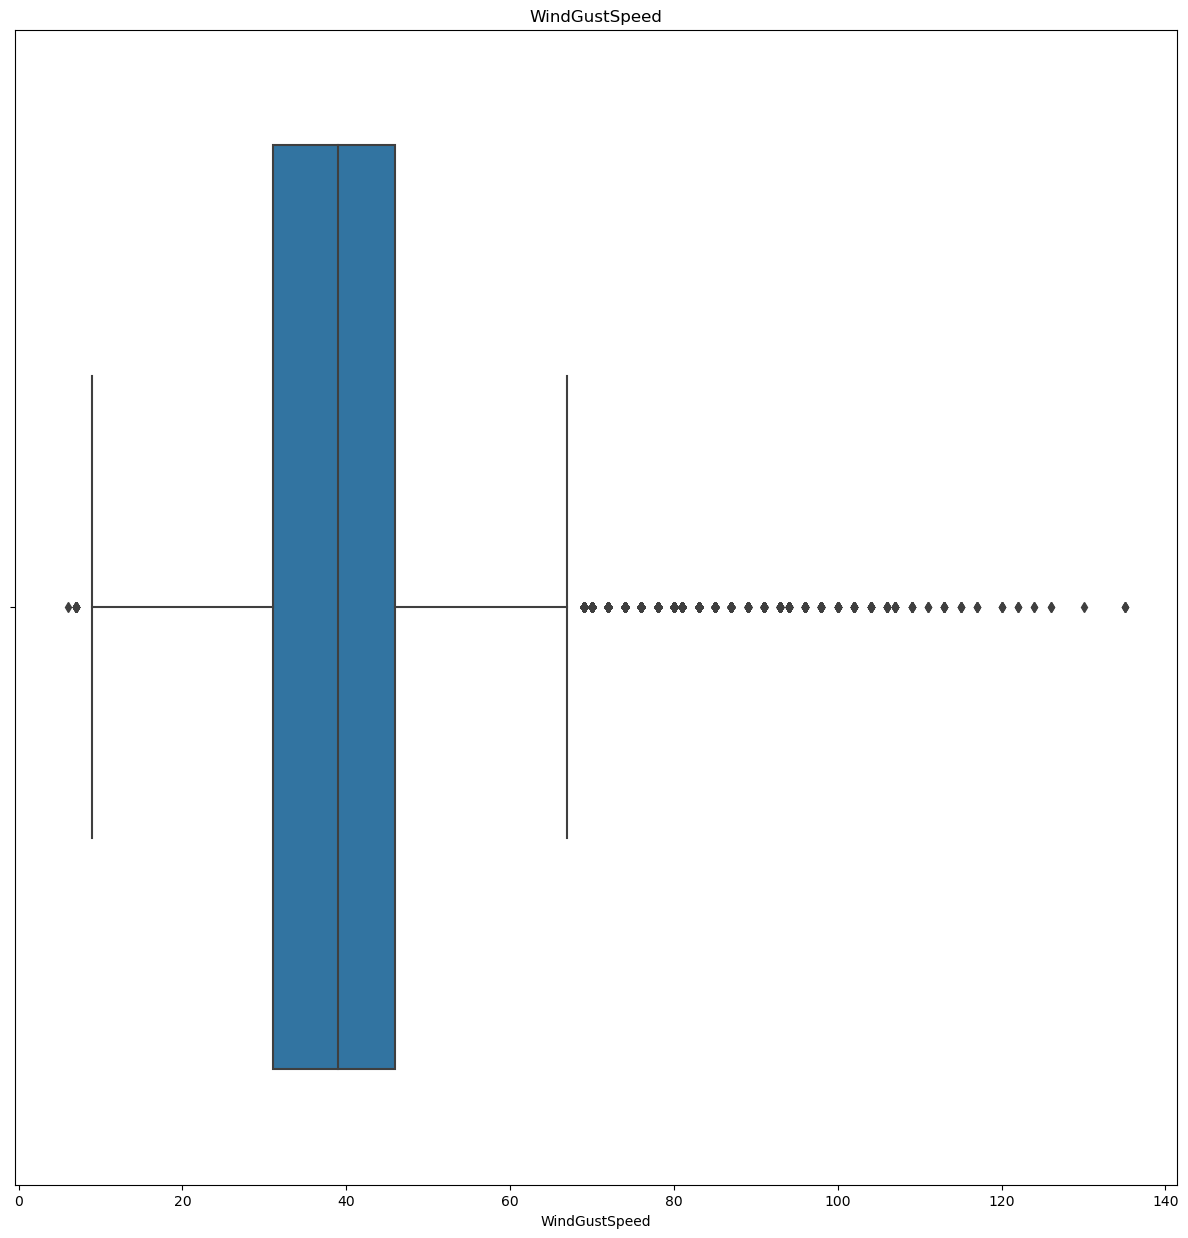

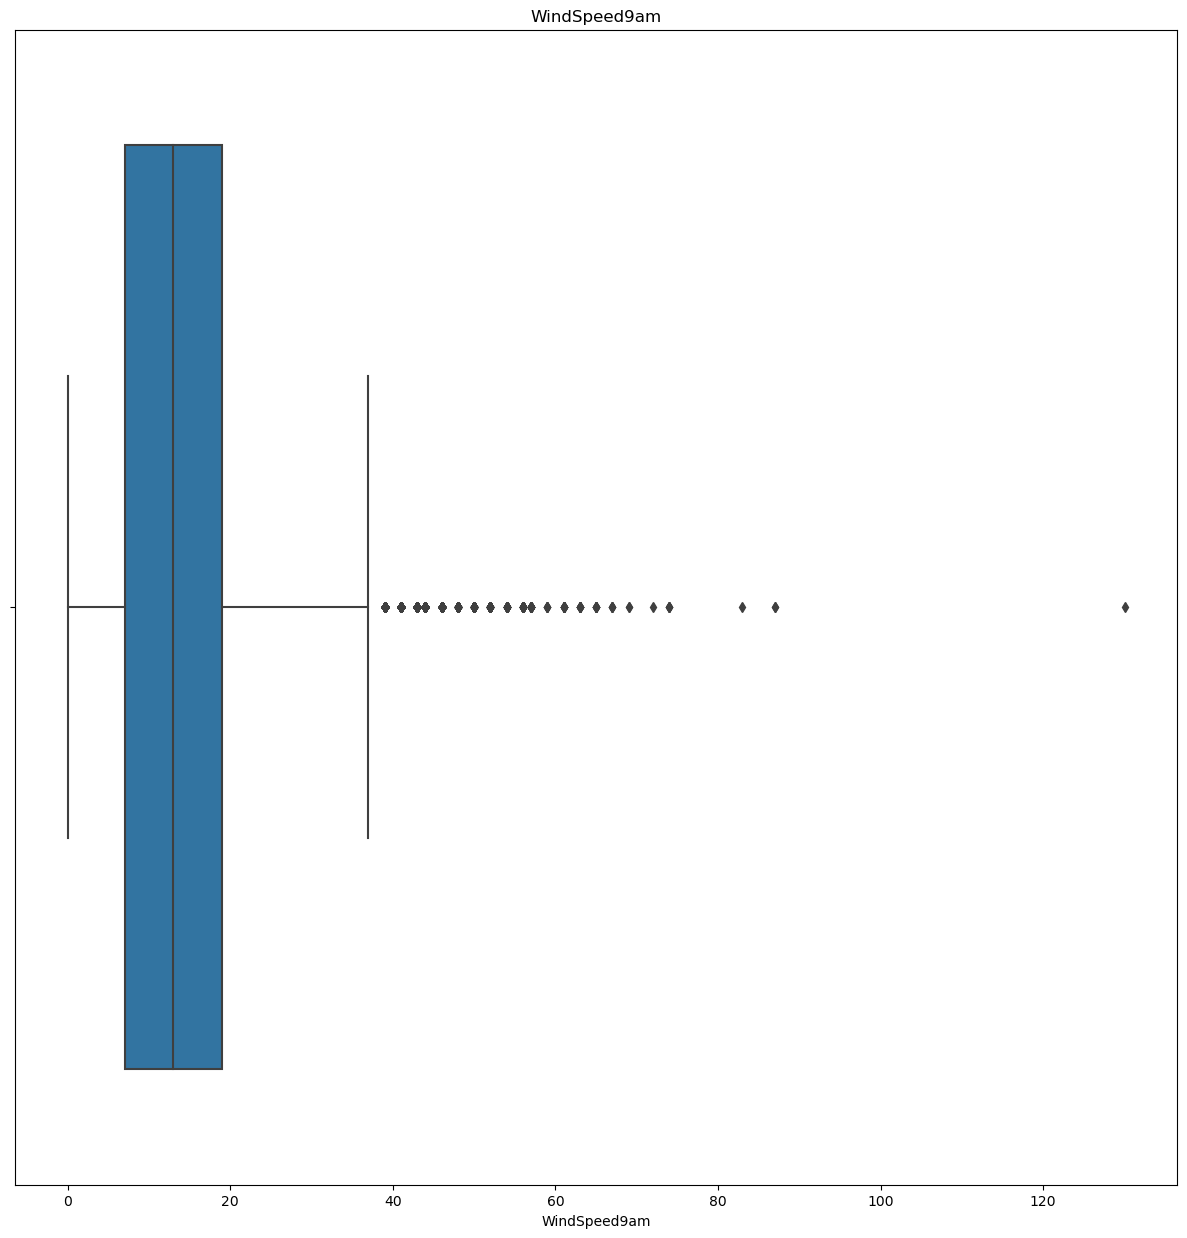

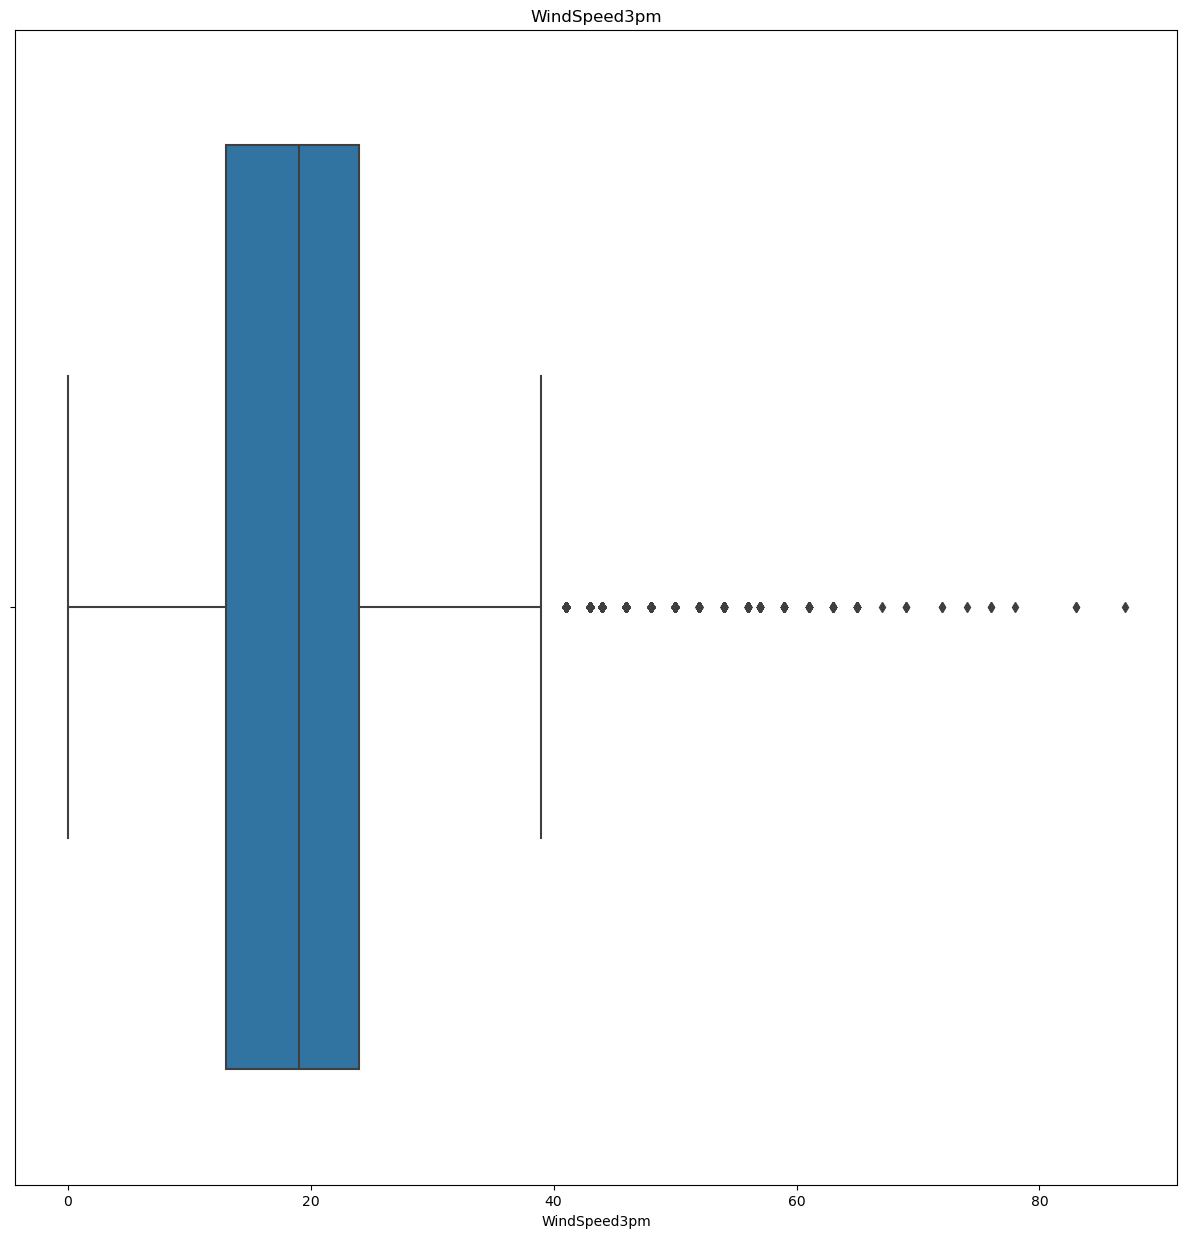

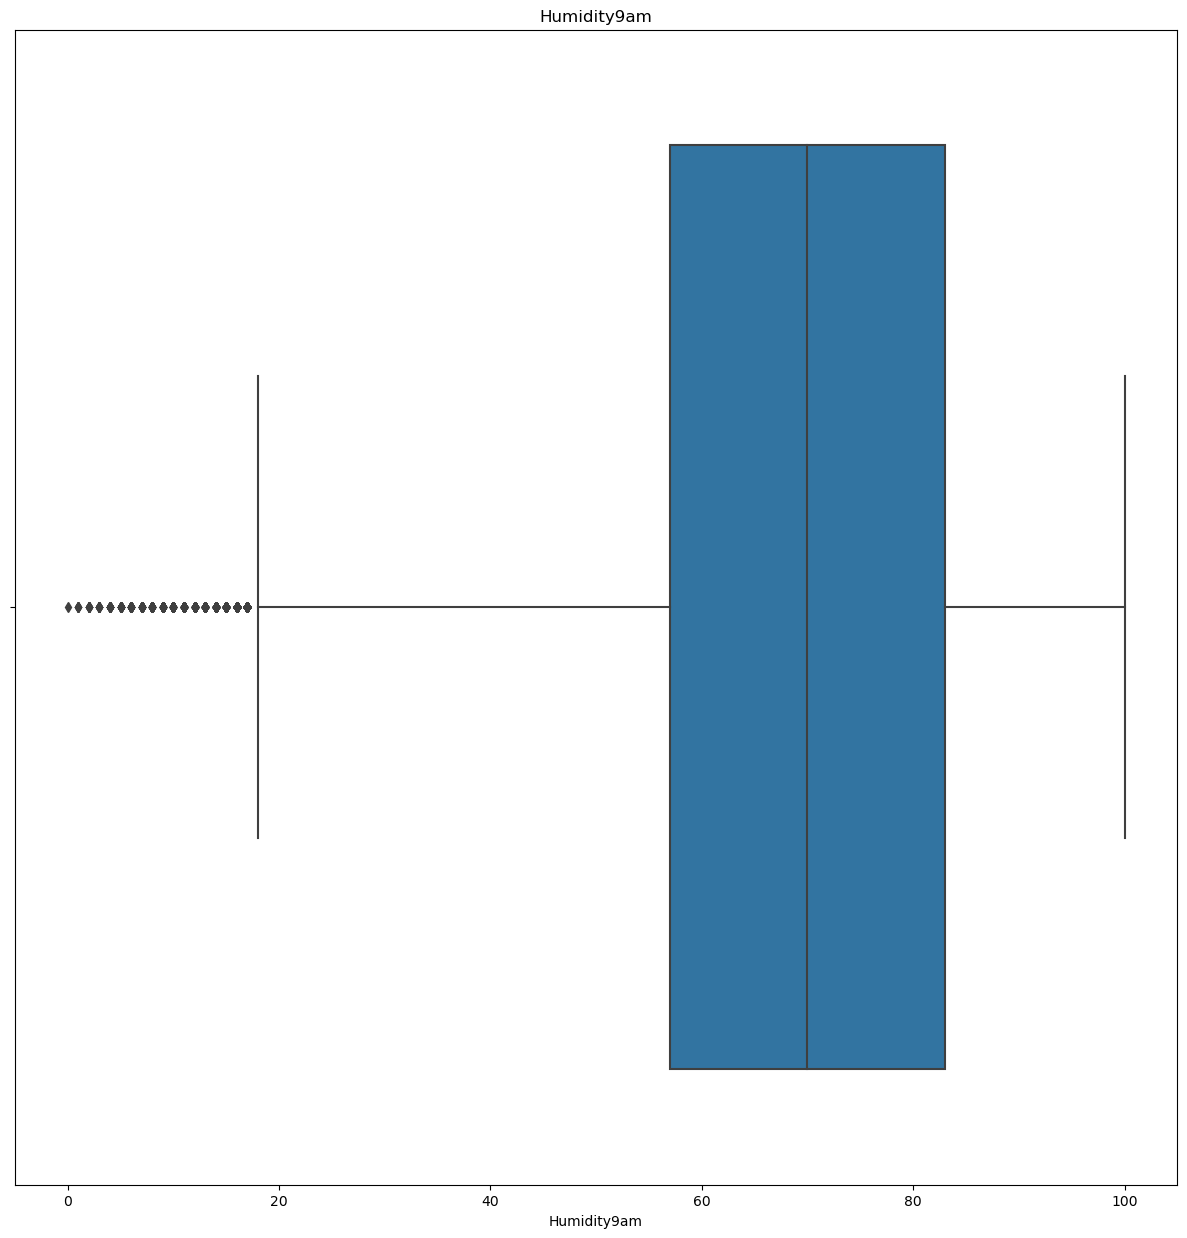

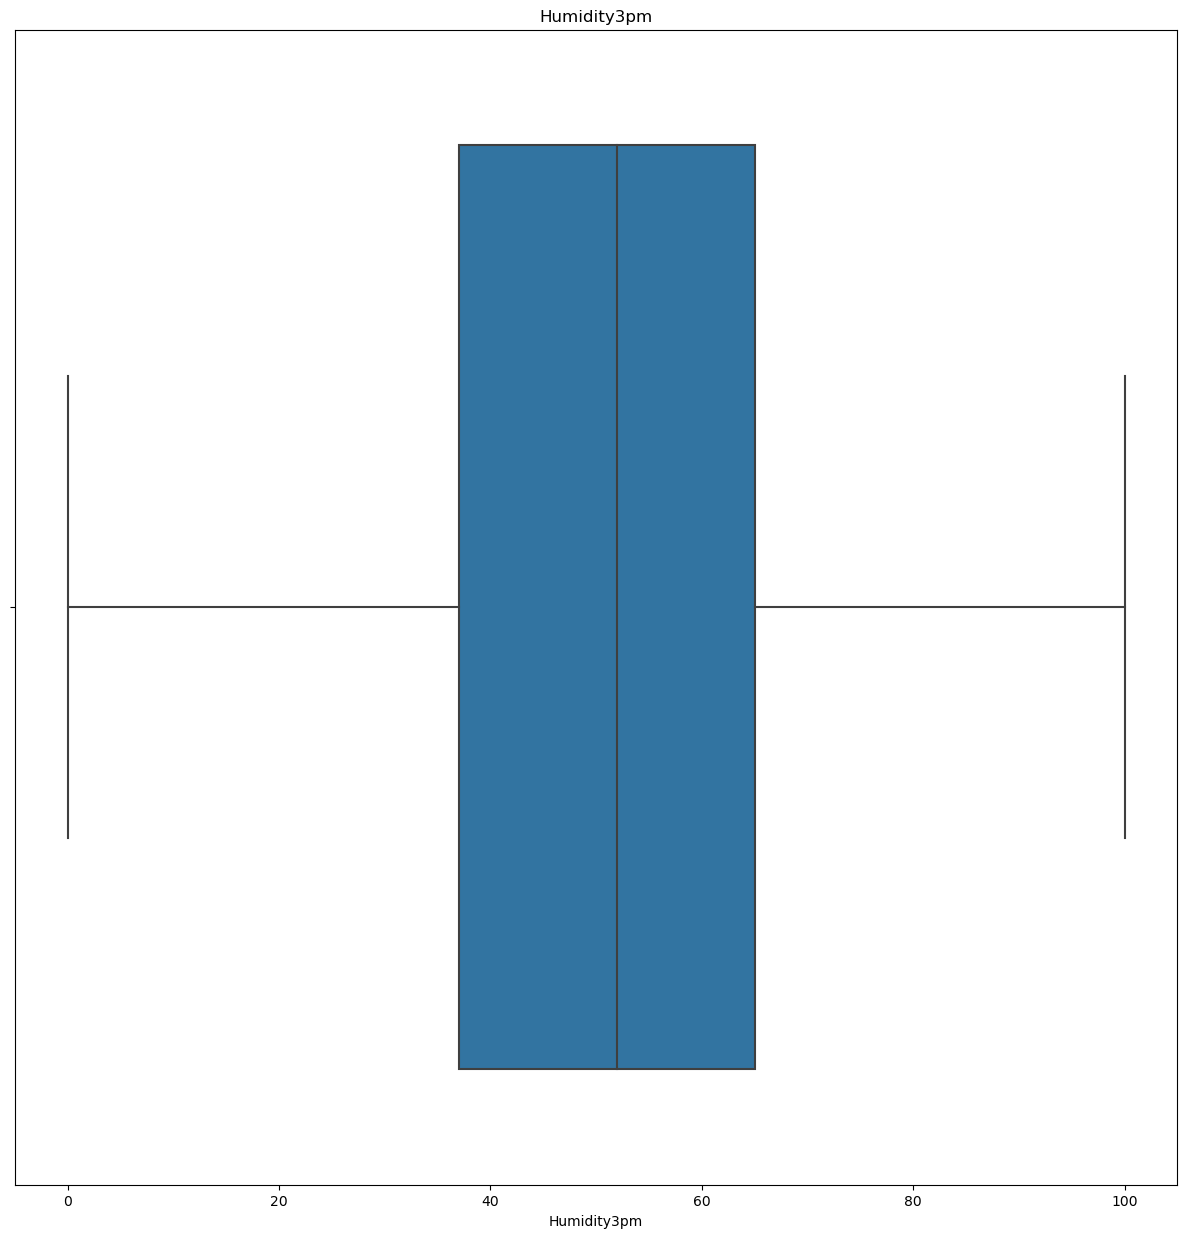

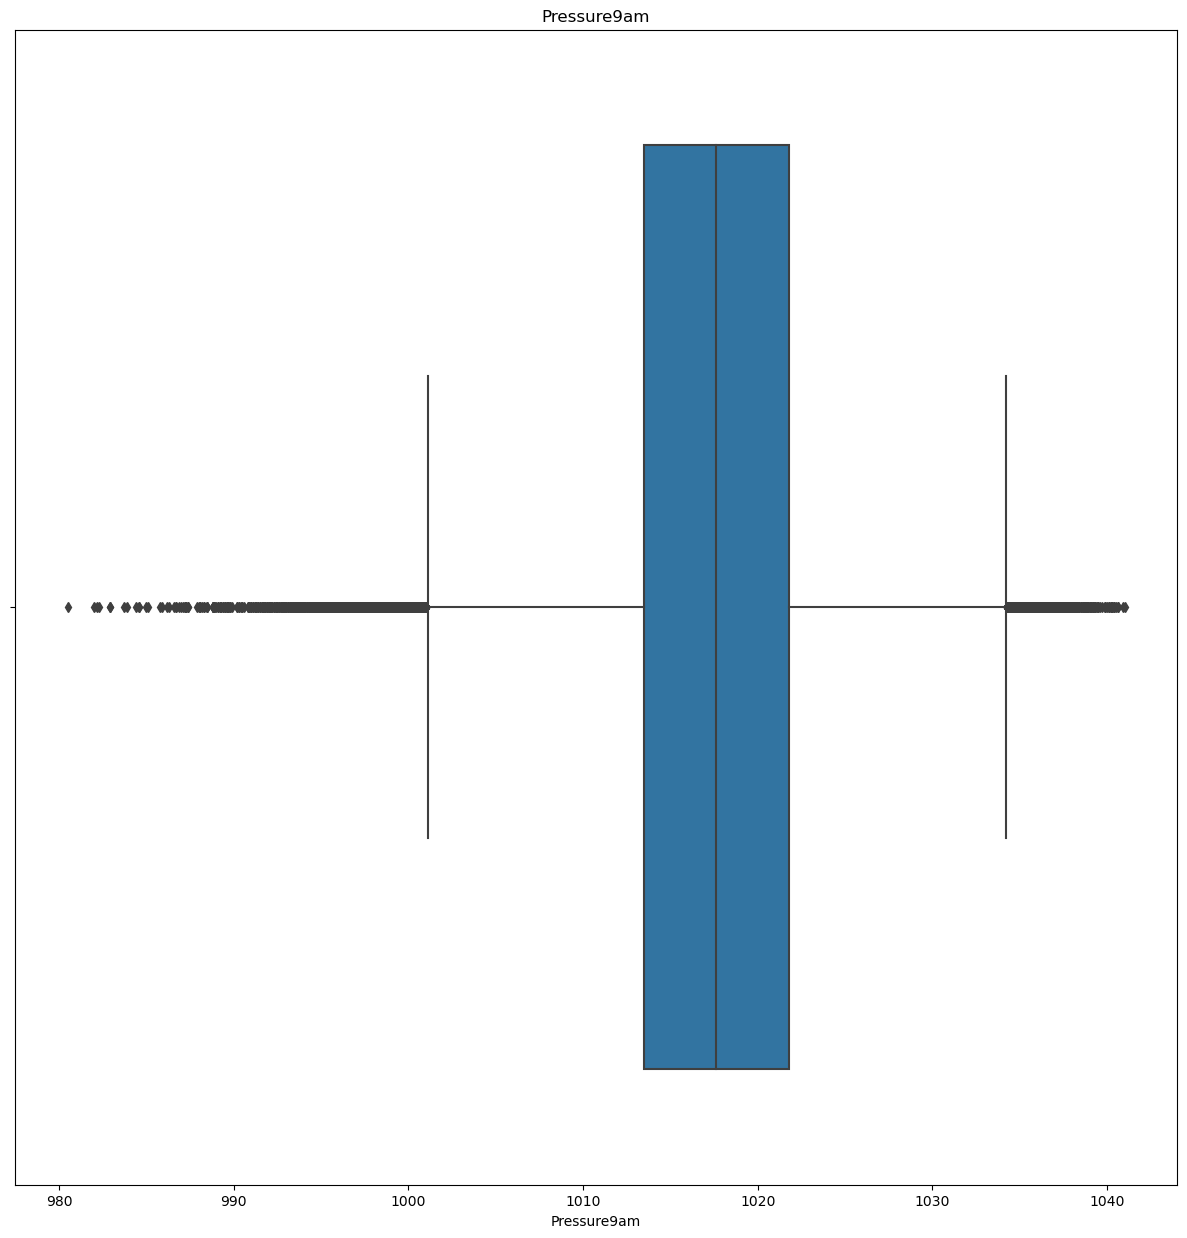

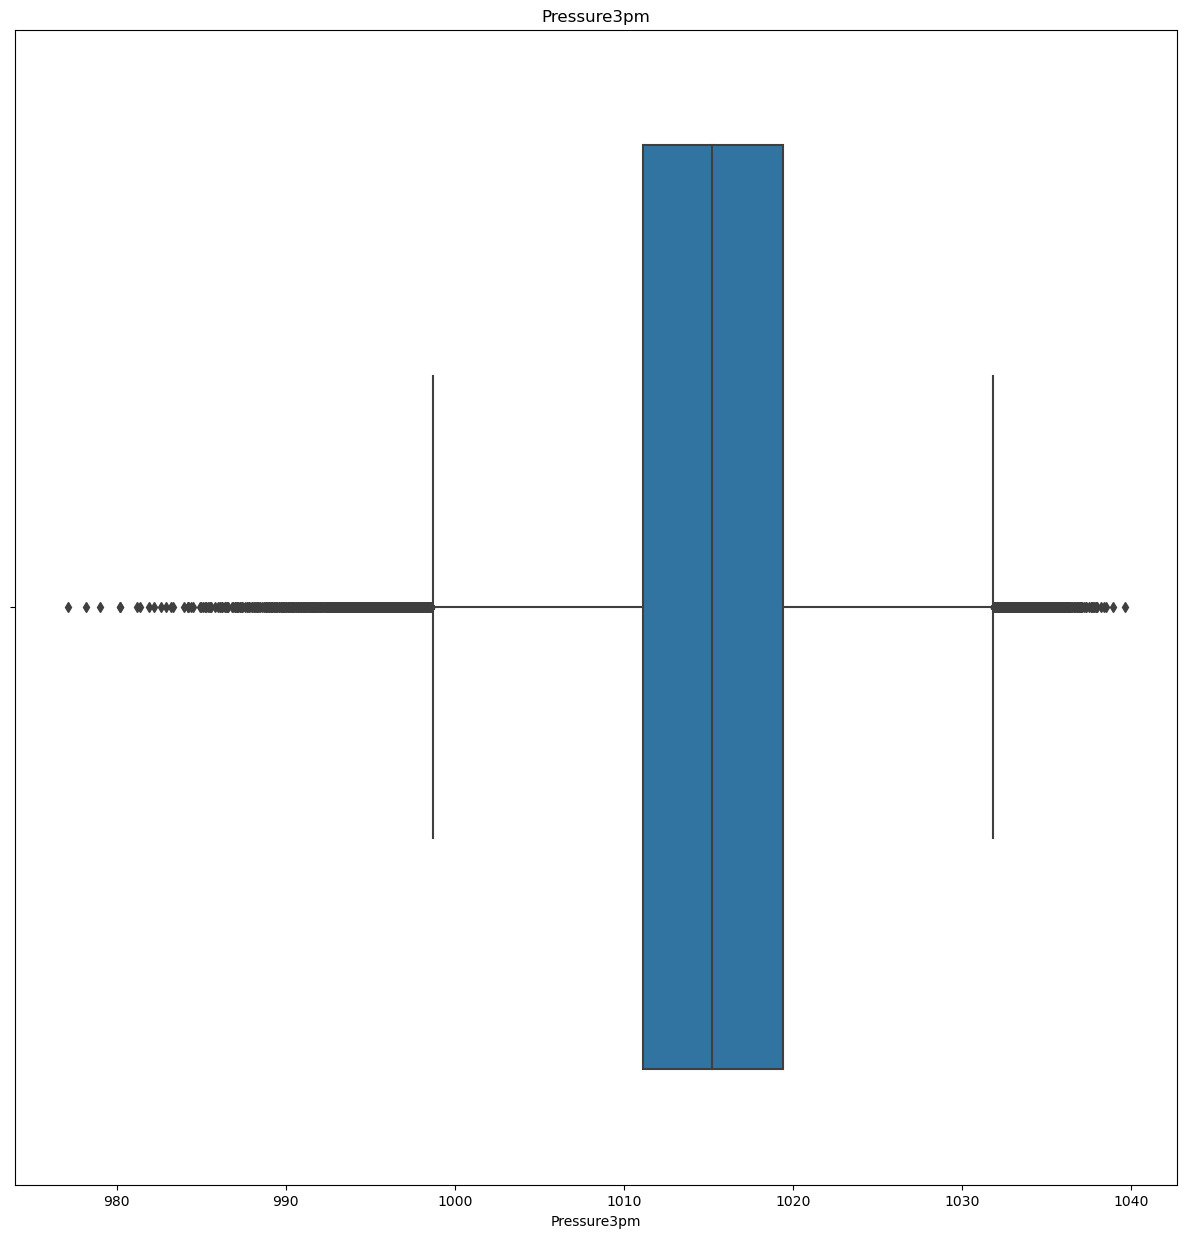

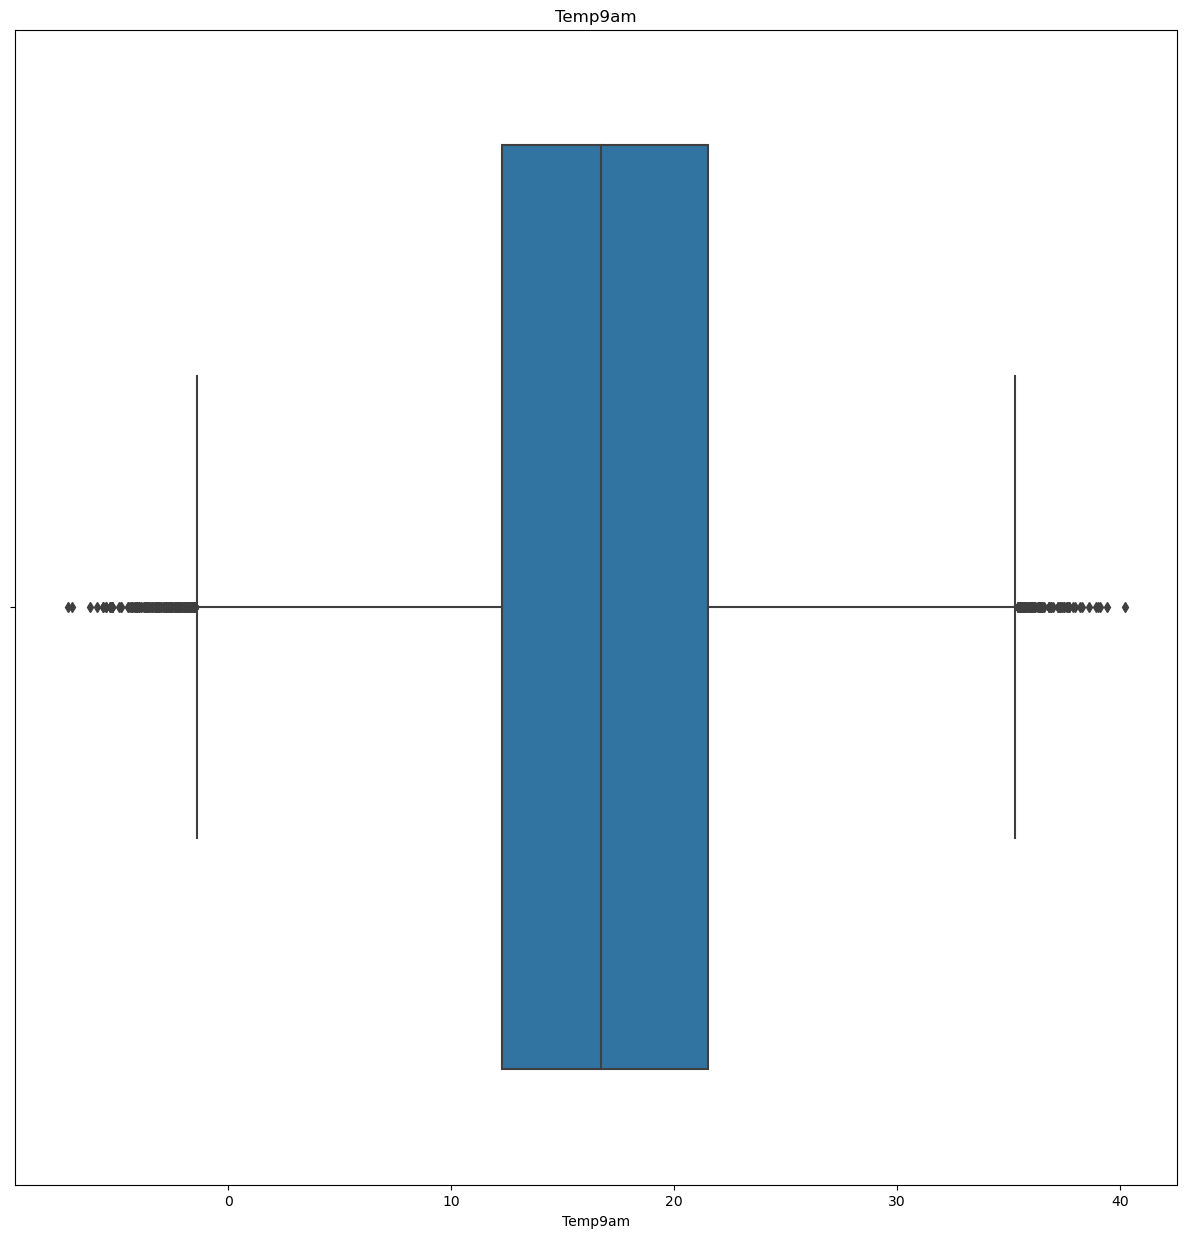

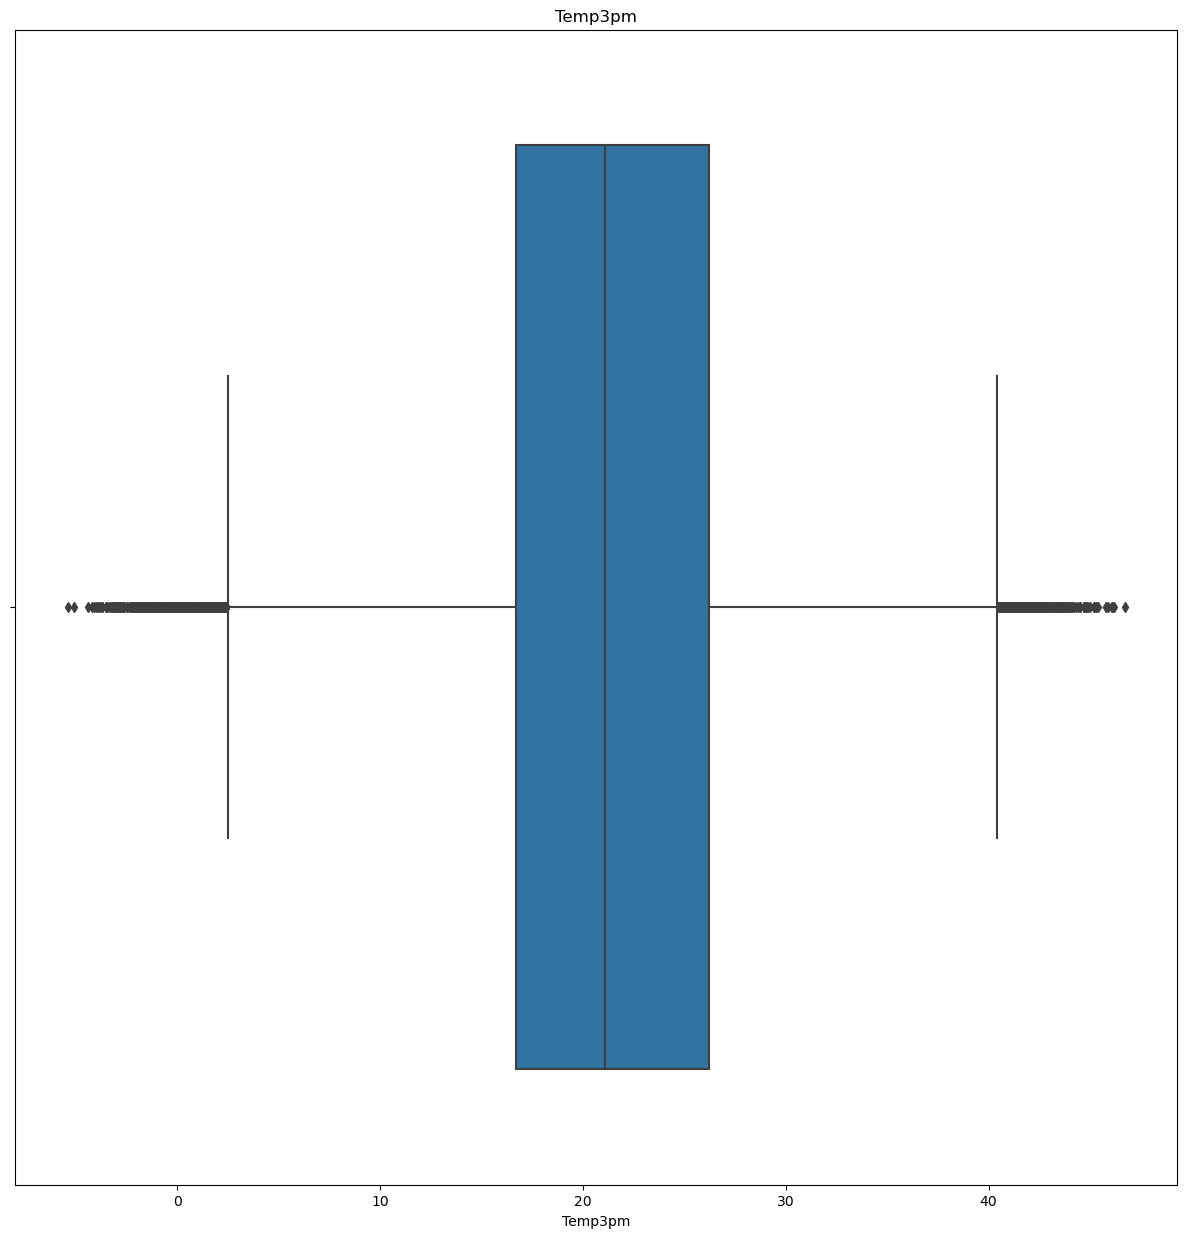

<Figure size 1500x1500 with 0 Axes>

In [37]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [38]:
for feature in continuous_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm


In [39]:
IQR=df.MinTemp.quantile(0.75)-df.MinTemp.quantile(0.25)
lower_bridge=df.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-5.950000000000002 30.450000000000003


In [40]:
df.loc[df['MinTemp']>=30.45,'MinTemp']=30.45
df.loc[df['MinTemp']<=-5.95,'MinTemp']=-5.95

In [41]:
IQR=df.MaxTemp.quantile(0.75)-df.MaxTemp.quantile(0.25)
lower_bridge=df.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.700000000000001 43.5


In [42]:
df.loc[df['MaxTemp']>=43.5,'MaxTemp']=43.5
df.loc[df['MaxTemp']<=2.7,'MaxTemp']=2.7

In [43]:
IQR=df.Rainfall.quantile(0.75)-df.Rainfall.quantile(0.25)
lower_bridge=df.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-0.8999999999999999 1.5


In [44]:
df.loc[df['Rainfall']>=1.5,'Rainfall']=1.5
df.loc[df['Rainfall']<=-0.89,'Rainfall']=-0.89

In [45]:
IQR=df.Evaporation.quantile(0.75)-df.Evaporation.quantile(0.25)
lower_bridge=df.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-4.600000000000001 14.600000000000001


In [46]:
df.loc[df['Evaporation']>=14.6,'Evaporation']=14.6
df.loc[df['Evaporation']<=-4.6,'Evaporation']=-4.6

In [47]:
IQR=df.WindGustSpeed.quantile(0.75)-df.WindGustSpeed.quantile(0.25)
lower_bridge=df.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

8.5 68.5


In [48]:
df.loc[df['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
df.loc[df['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [49]:
IQR=df.WindSpeed9am.quantile(0.75)-df.WindSpeed9am.quantile(0.25)
lower_bridge=df.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-11.0 37.0


In [50]:
df.loc[df['WindSpeed9am']>=37,'WindSpeed9am']=37
df.loc[df['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [51]:
IQR=df.WindSpeed3pm.quantile(0.75)-df.WindSpeed3pm.quantile(0.25)
lower_bridge=df.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-3.5 40.5


In [52]:
df.loc[df['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
df.loc[df['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [53]:
IQR=df.Humidity9am.quantile(0.75)-df.Humidity9am.quantile(0.25)
lower_bridge=df.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

18.0 122.0


In [54]:
df.loc[df['Humidity9am']>=122,'Humidity9am']=122
df.loc[df['Humidity9am']<=18,'Humidity9am']=18

In [55]:
IQR=df.Pressure9am.quantile(0.75)-df.Pressure9am.quantile(0.25)
lower_bridge=df.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1001.0500000000001 1034.25


In [56]:
df.loc[df['Pressure9am']>=1034.25,'Pressure9am']=1034.25
df.loc[df['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [57]:
IQR=df.Pressure3pm.quantile(0.75)-df.Pressure3pm.quantile(0.25)
lower_bridge=df.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

998.6500000000001 1031.85


In [58]:
df.loc[df['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
df.loc[df['Pressure3pm']<=998.65,'Pressure3pm']=998.65

In [59]:
IQR=df.Temp9am.quantile(0.75)-df.Temp9am.quantile(0.25)
lower_bridge=df.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.4999999999999982 35.3


In [60]:
df.loc[df['Temp9am']>=35.3,'Temp9am']=35.3
df.loc[df['Temp9am']<=-1.49,'Temp9am']=-1.49

In [61]:
IQR=df.Temp3pm.quantile(0.75)-df.Temp3pm.quantile(0.25)
lower_bridge=df.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.4499999999999993 40.45


In [62]:
df.loc[df['Temp3pm']>=40.45,'Temp3pm']=40.45
df.loc[df['Temp3pm']<=2.45,'Temp3pm']=2.45

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zeel sh

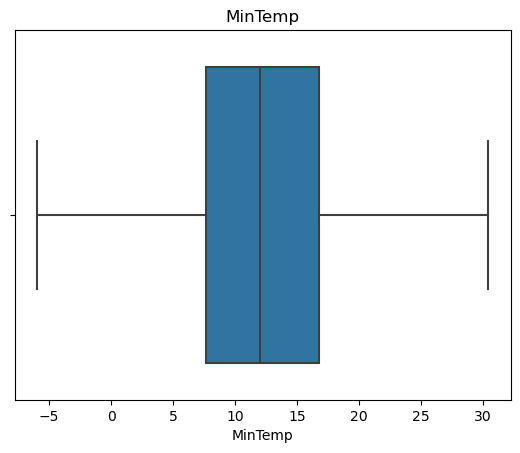

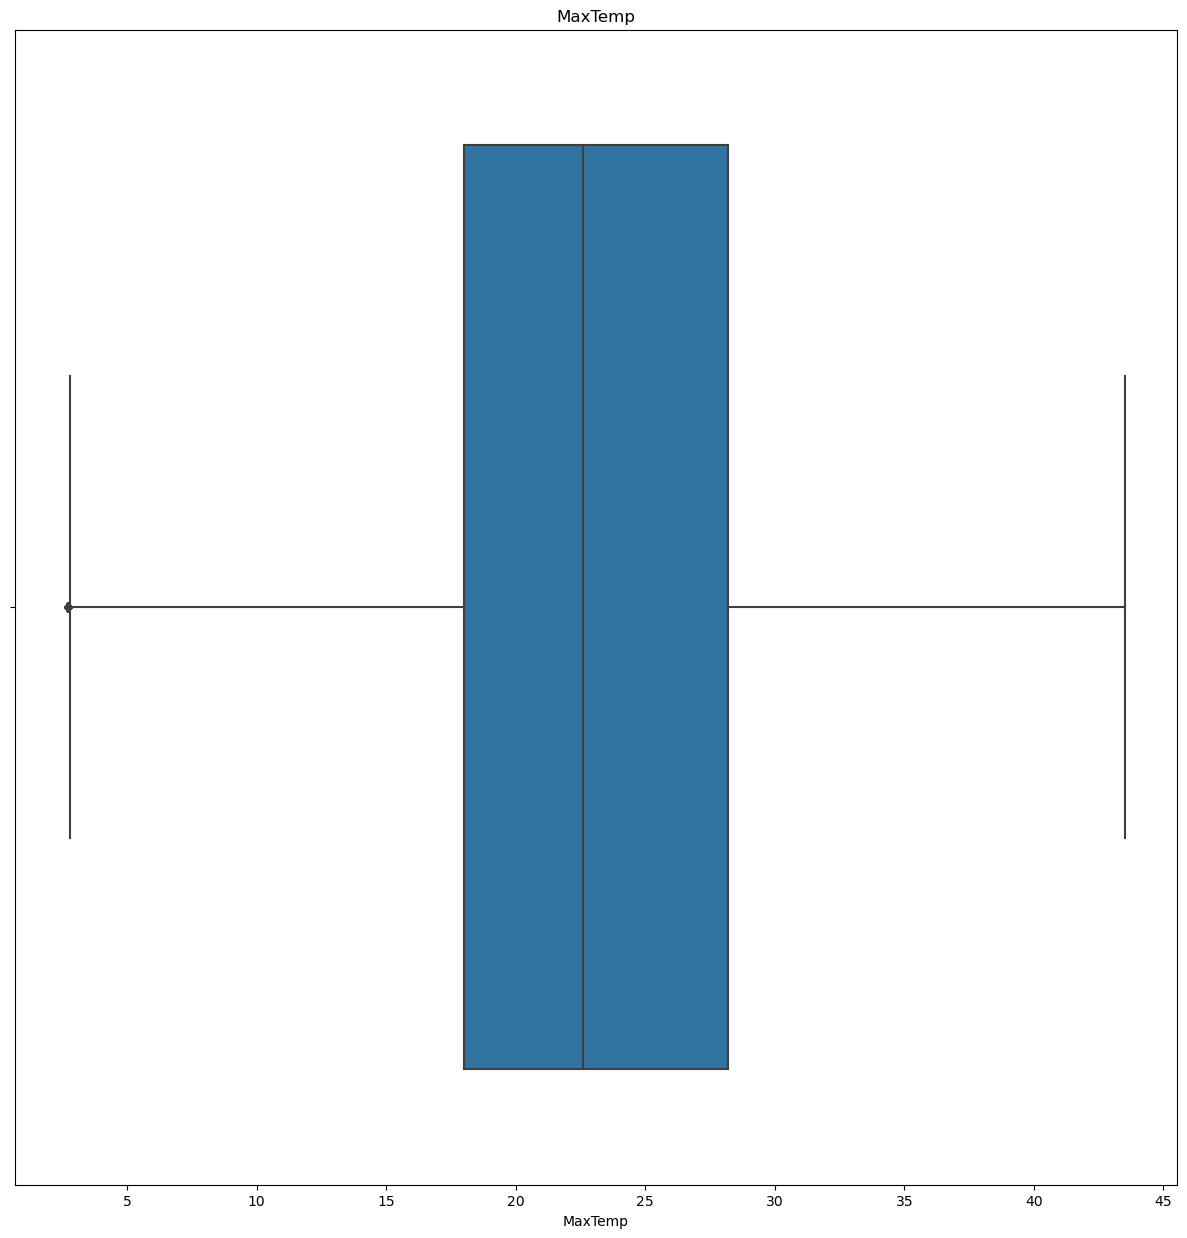

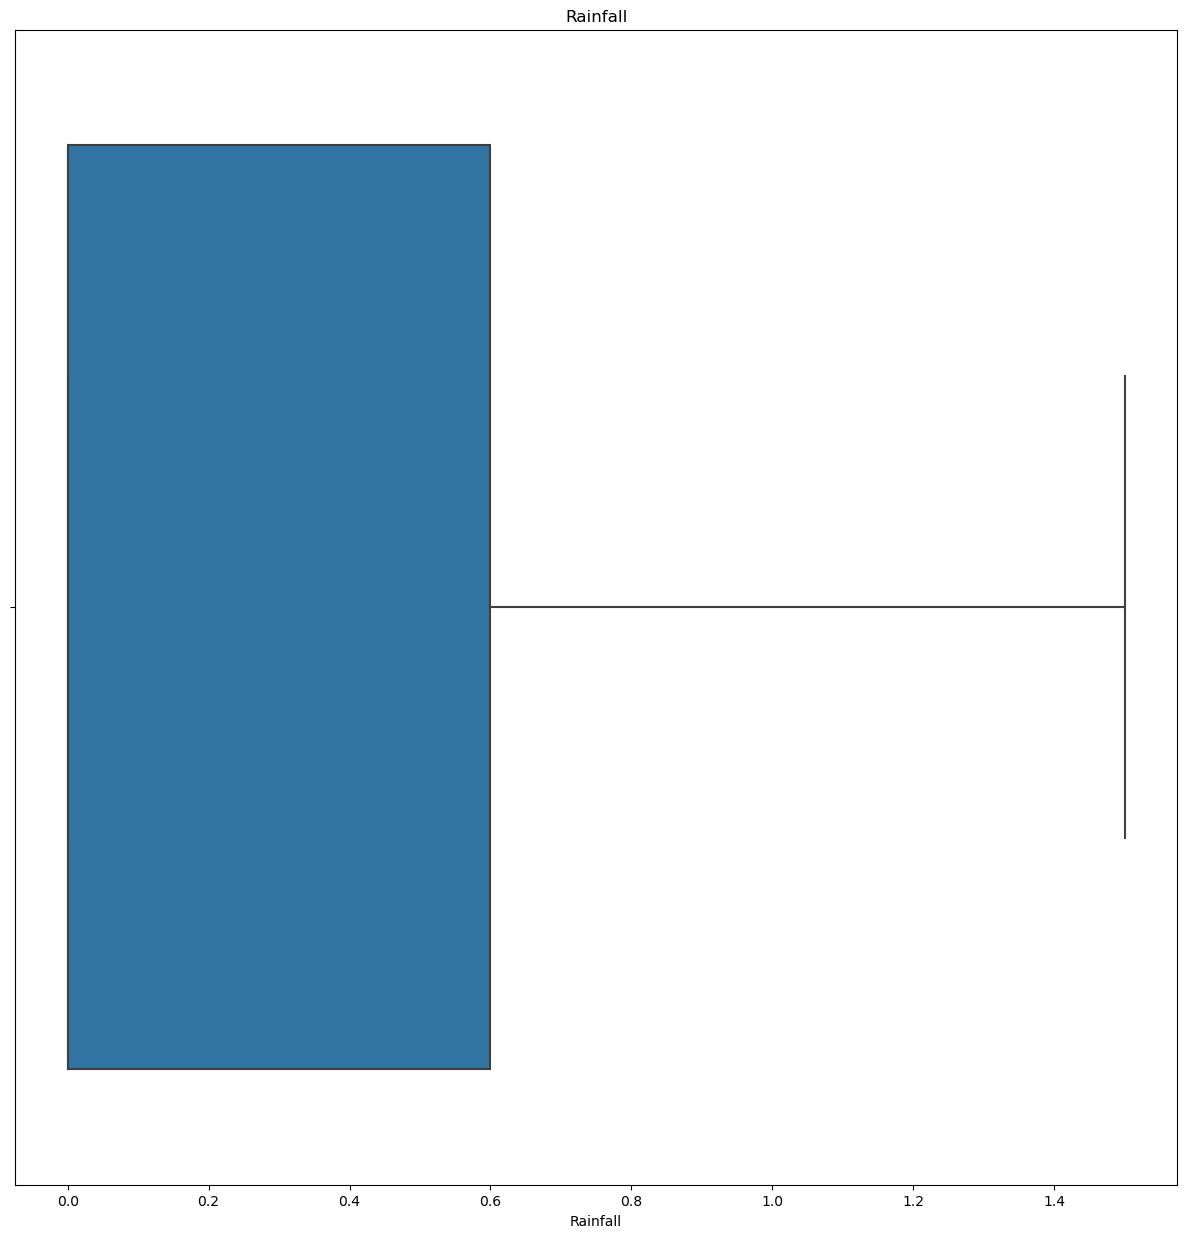

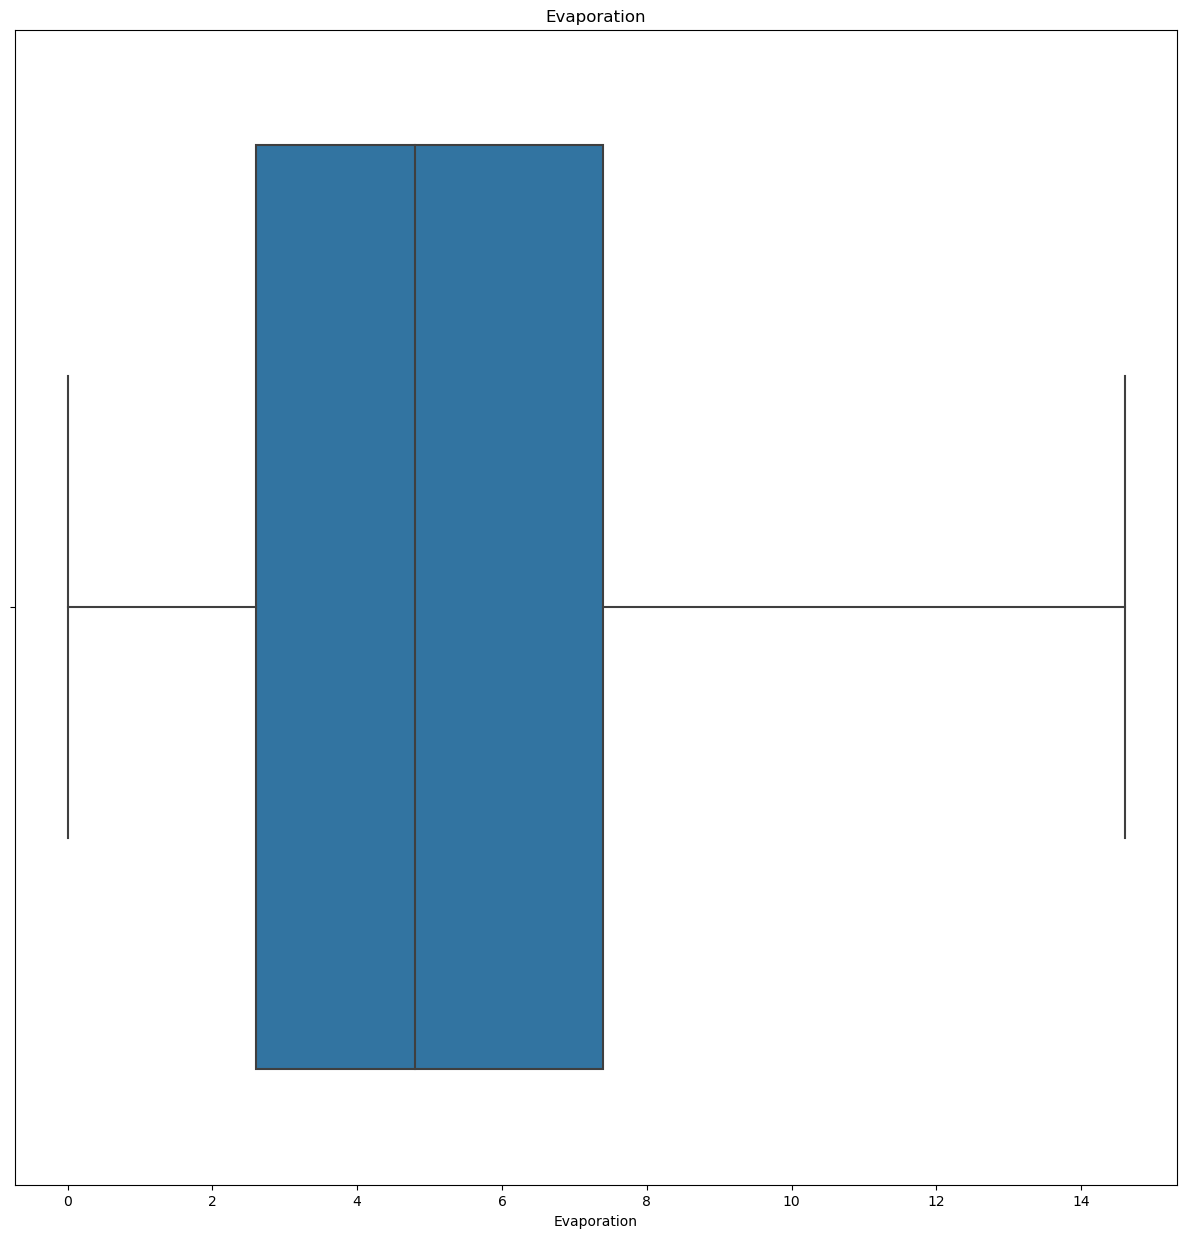

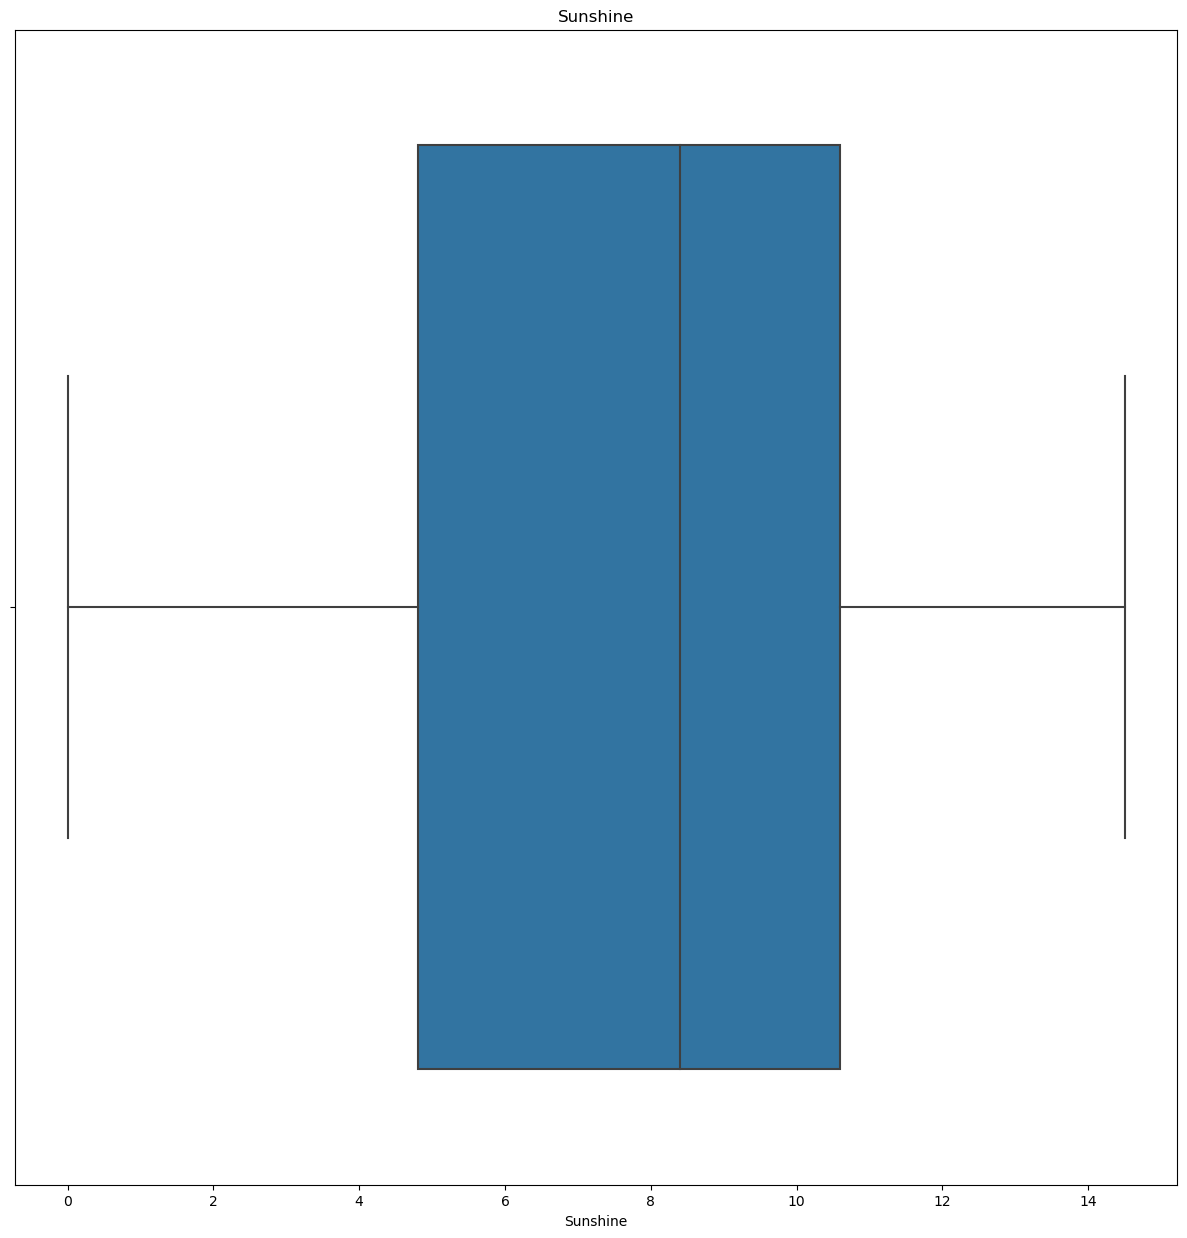

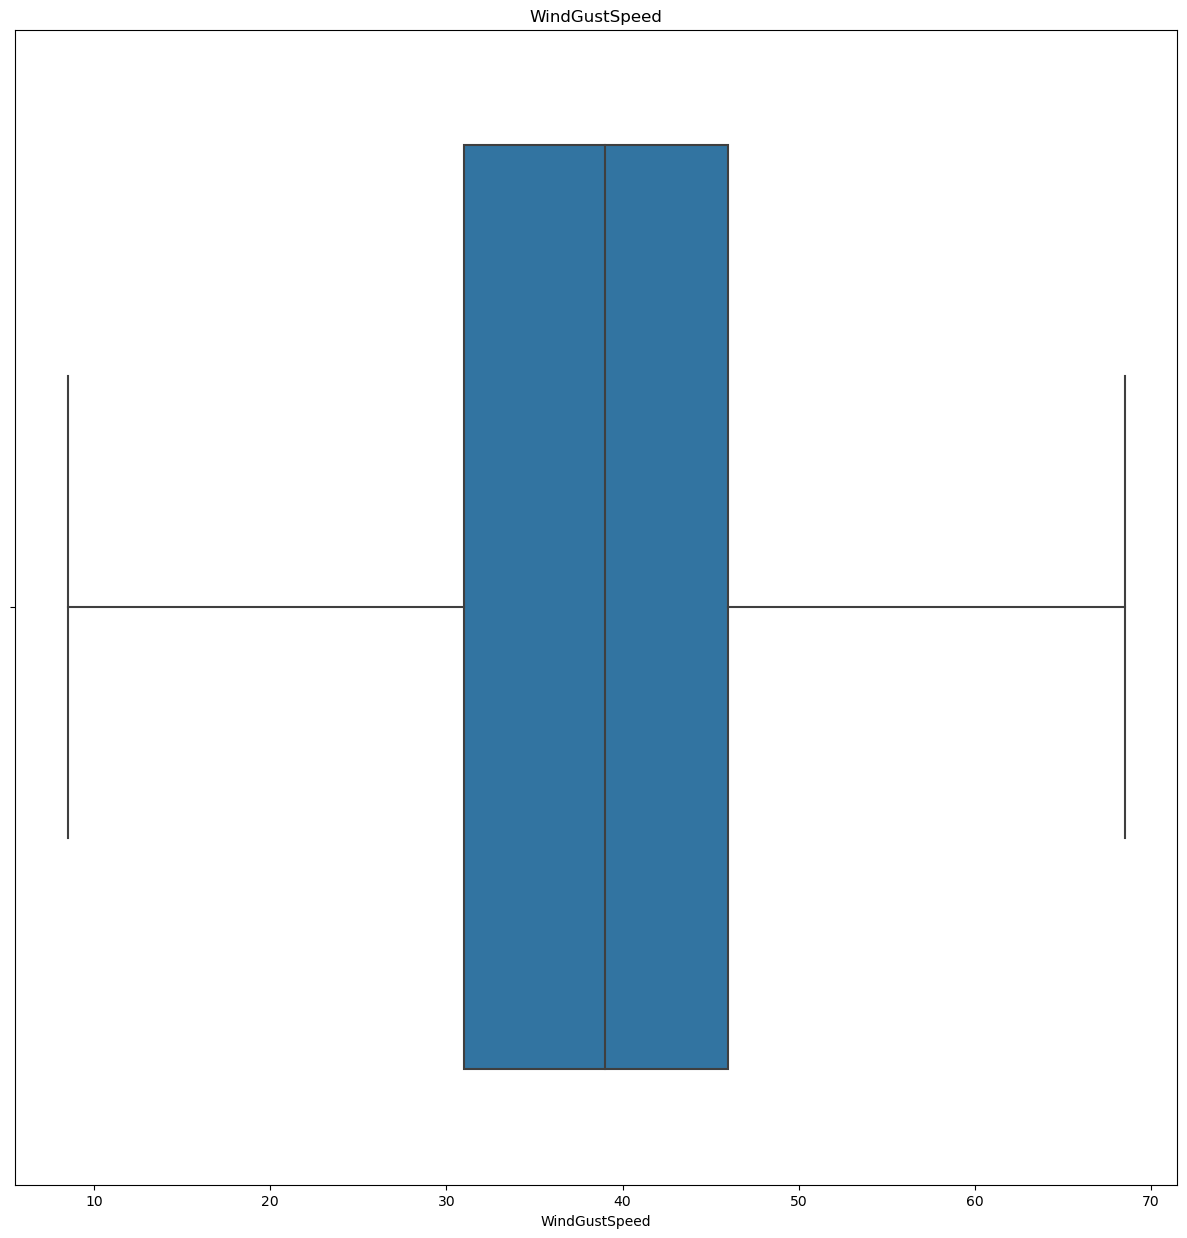

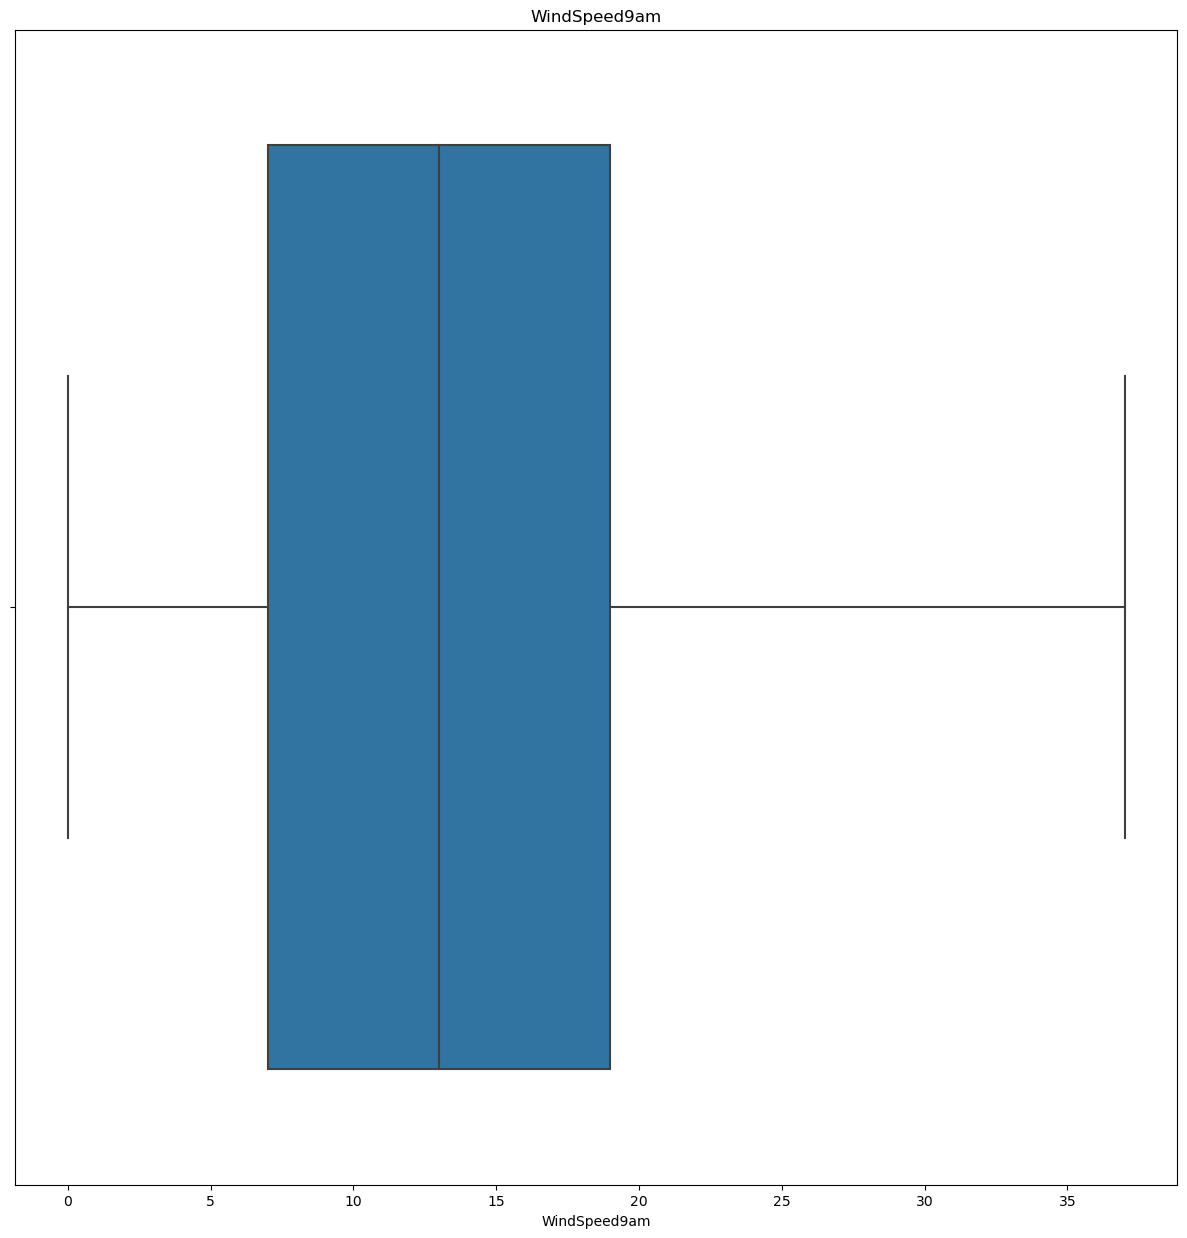

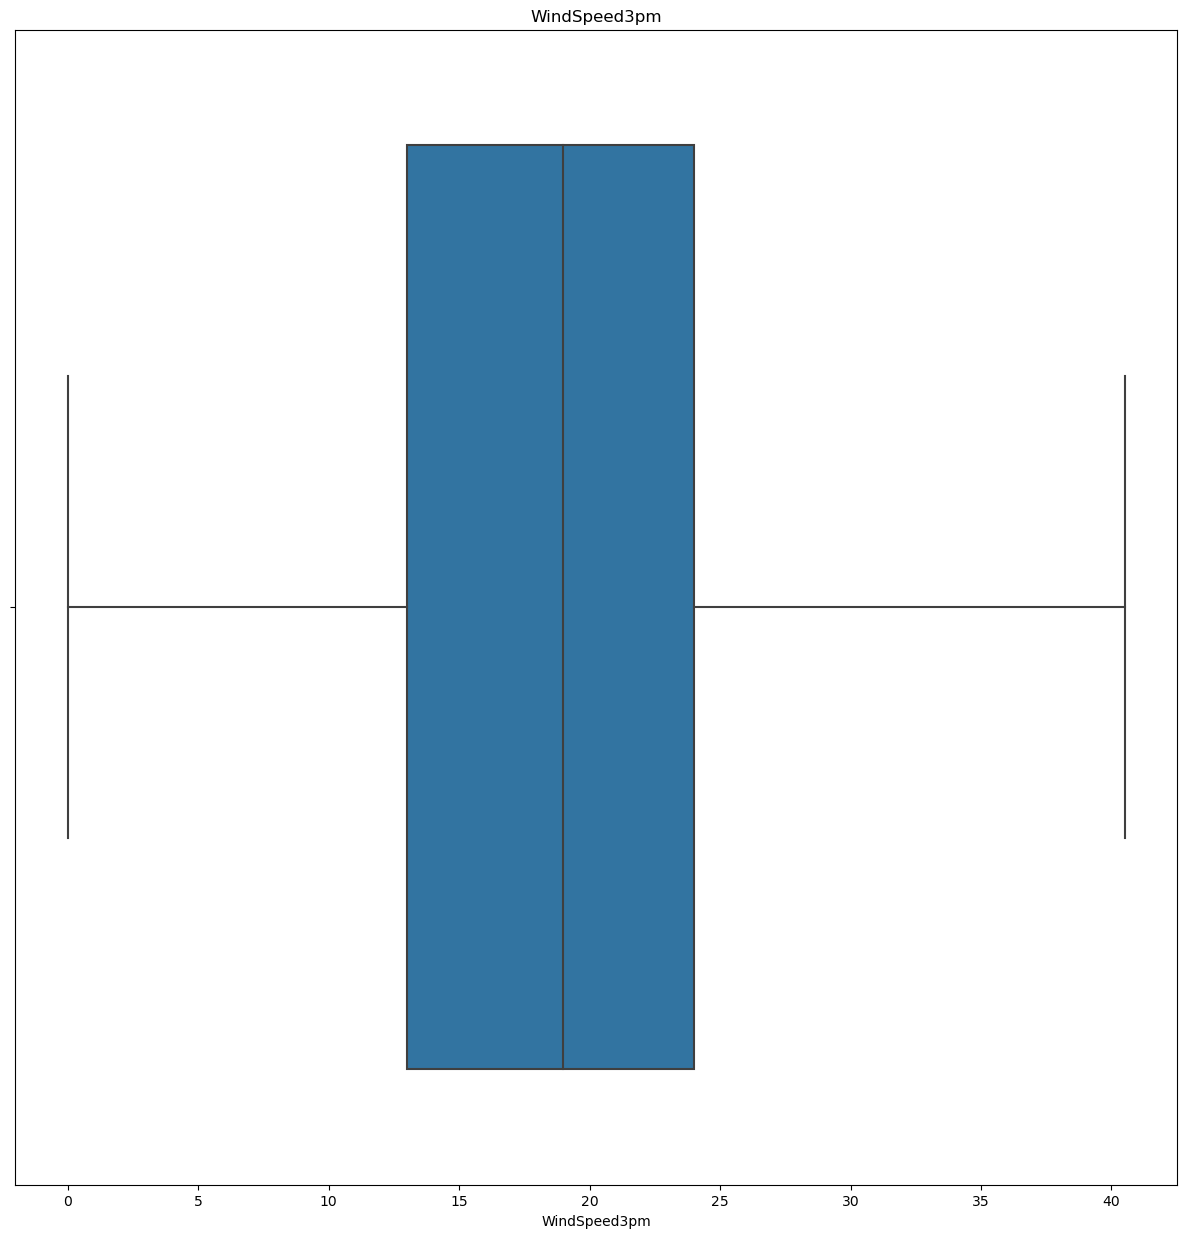

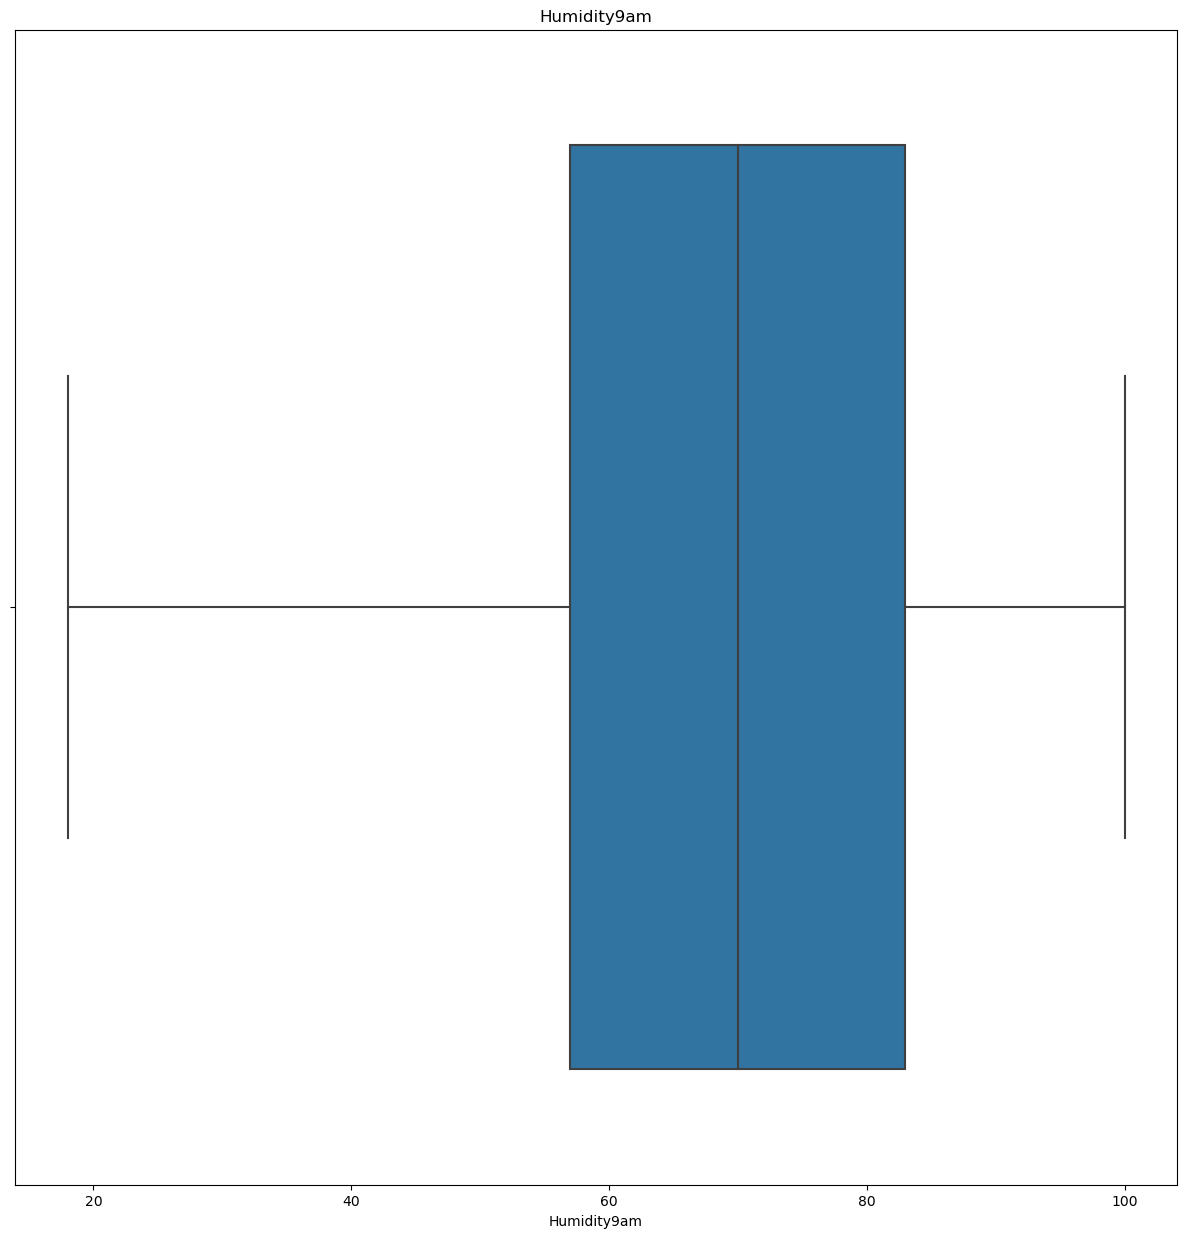

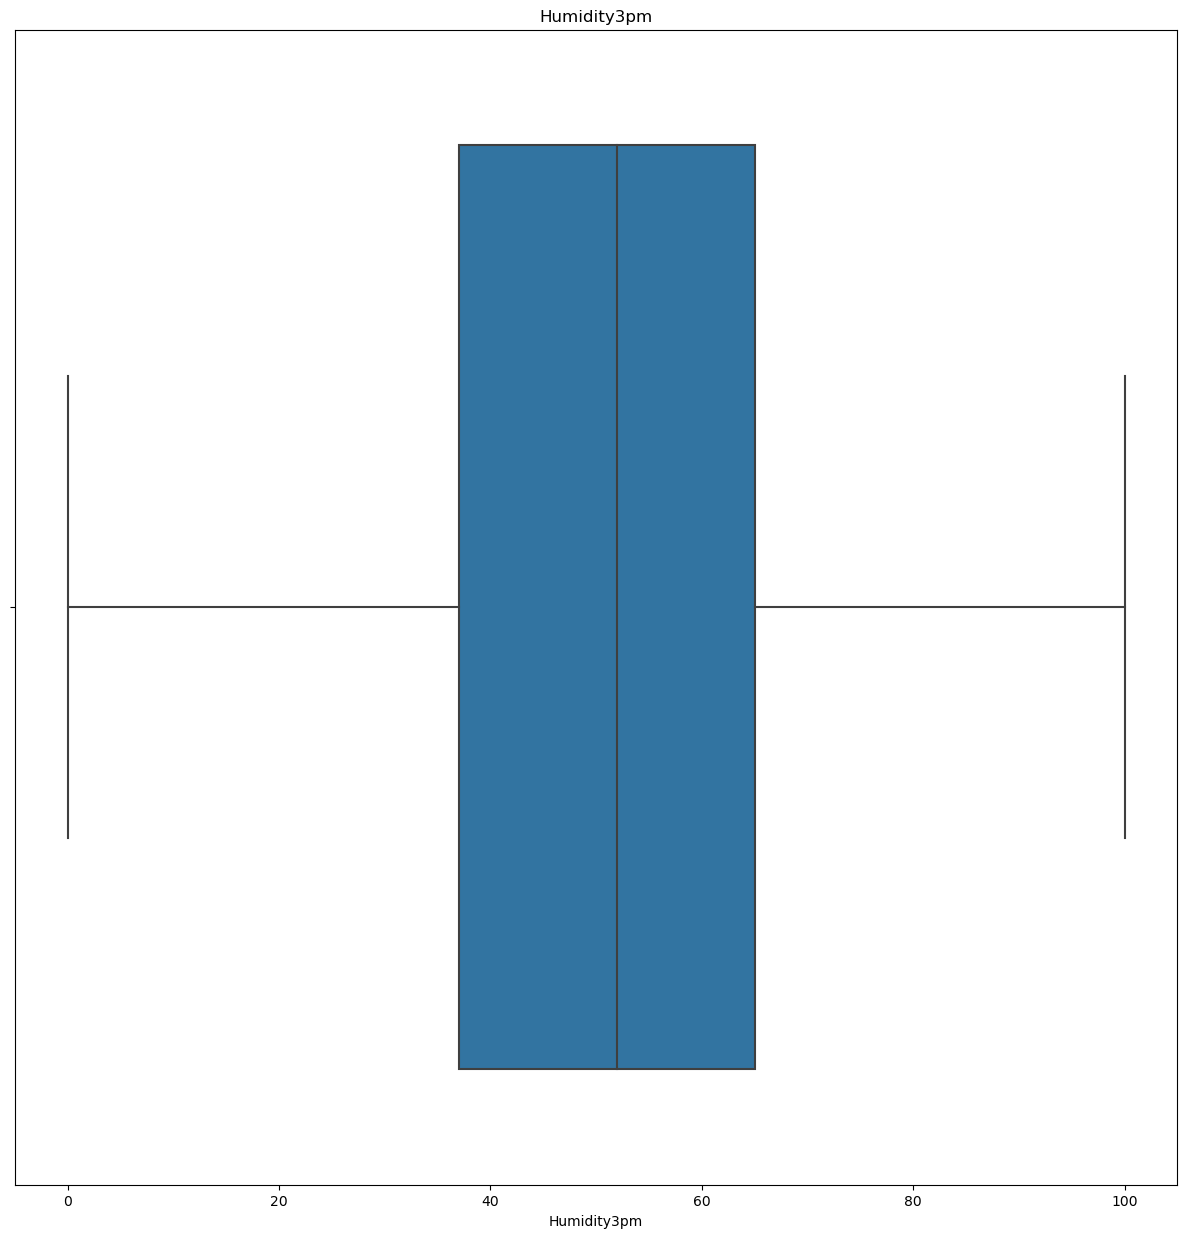

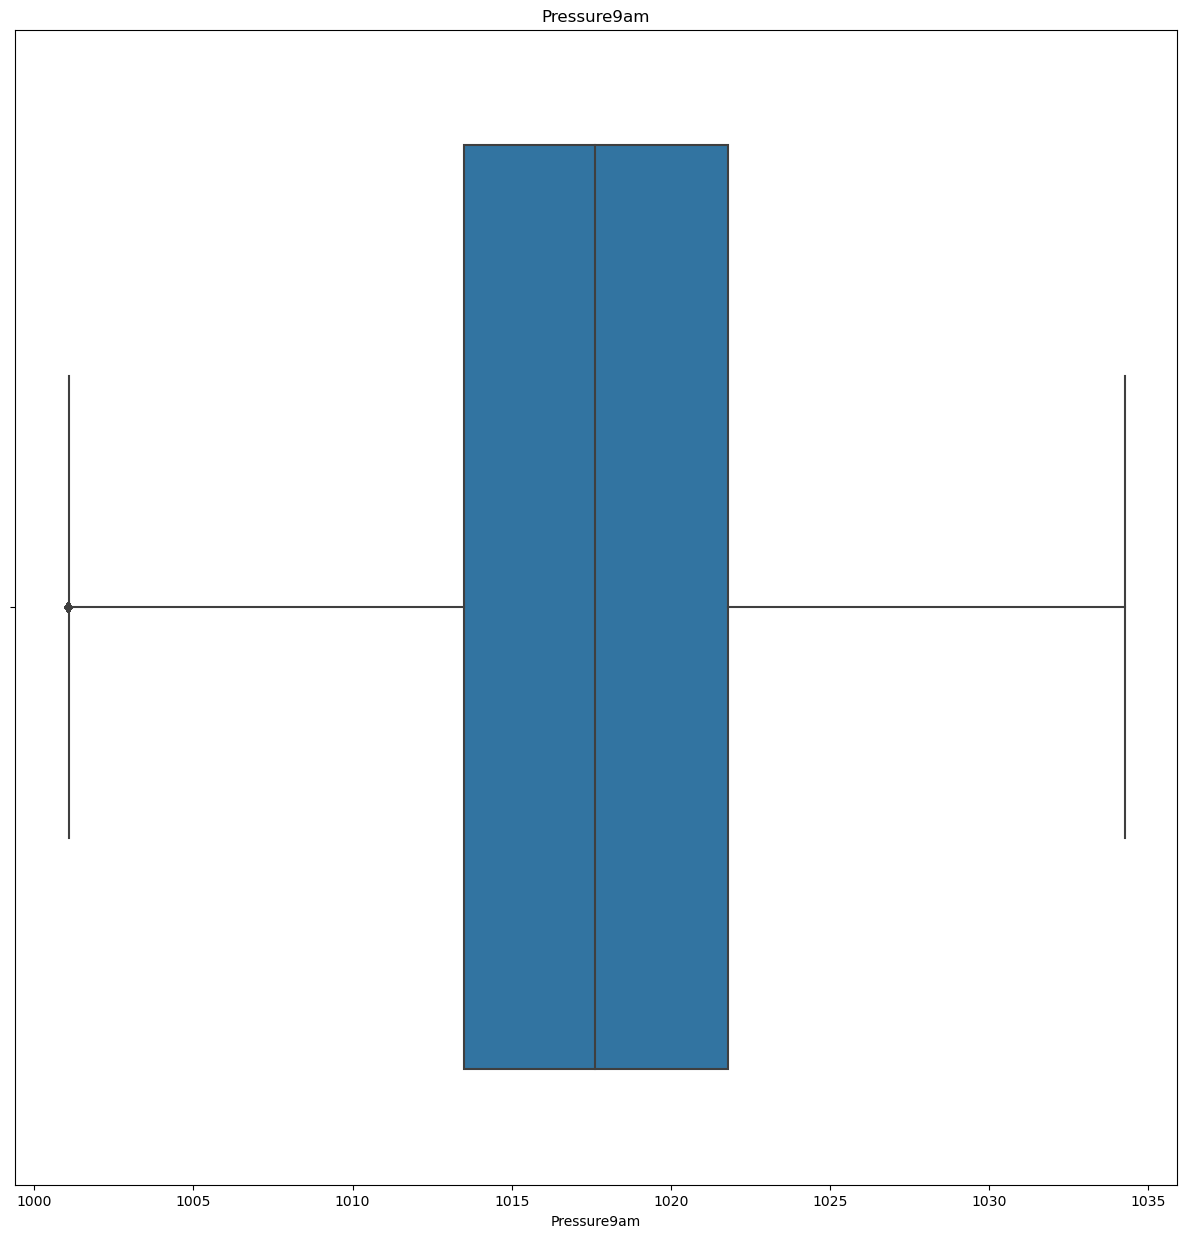

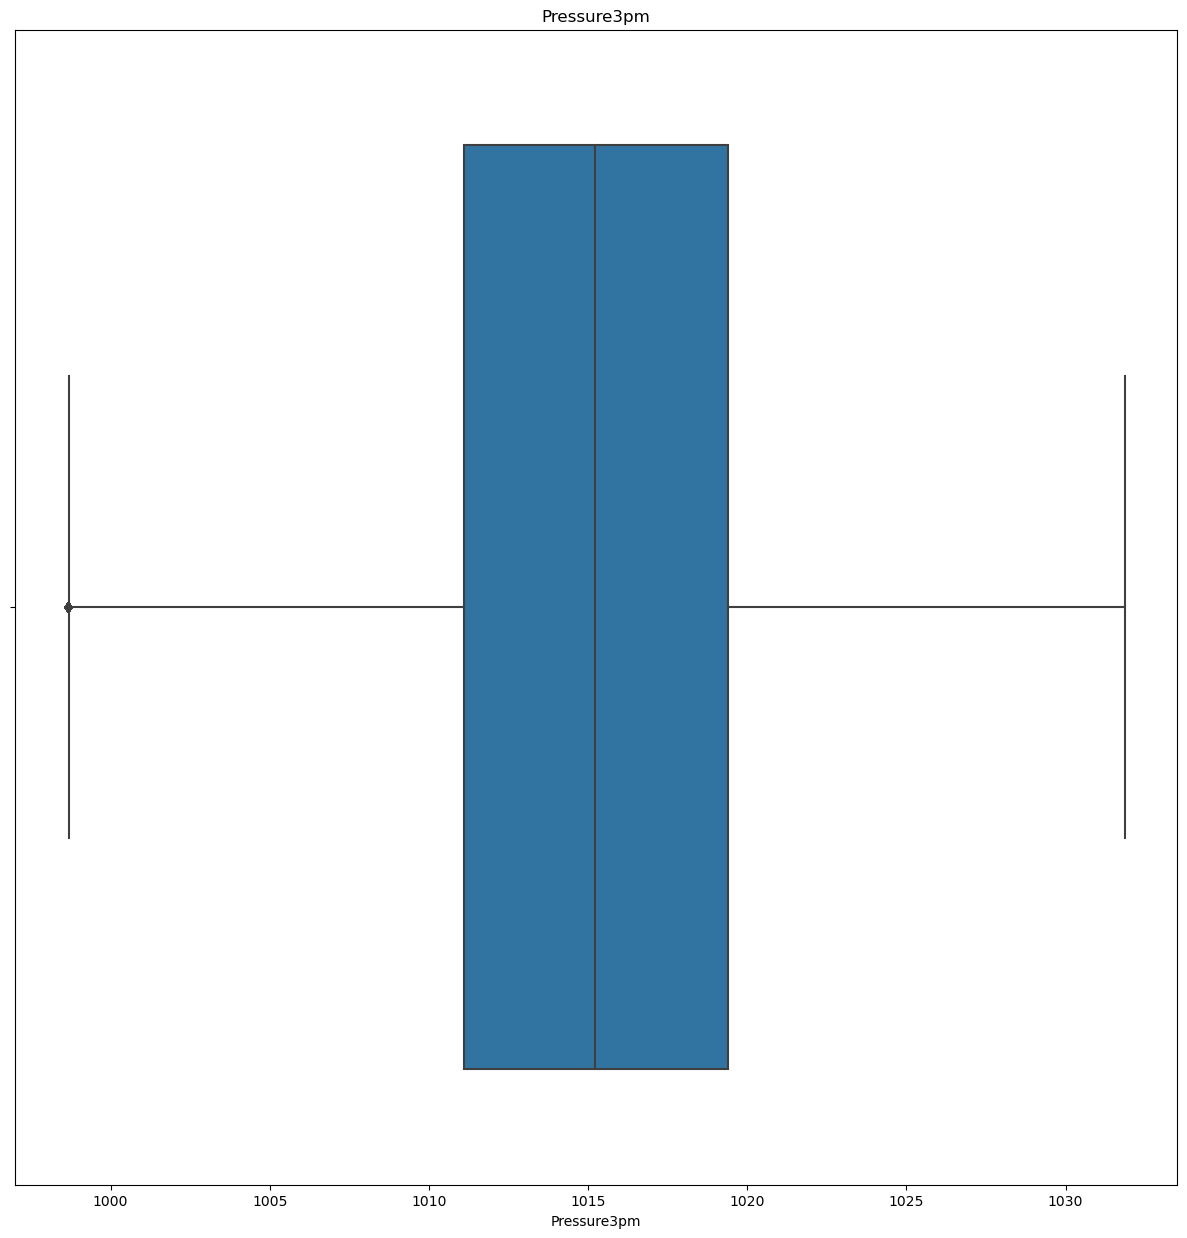

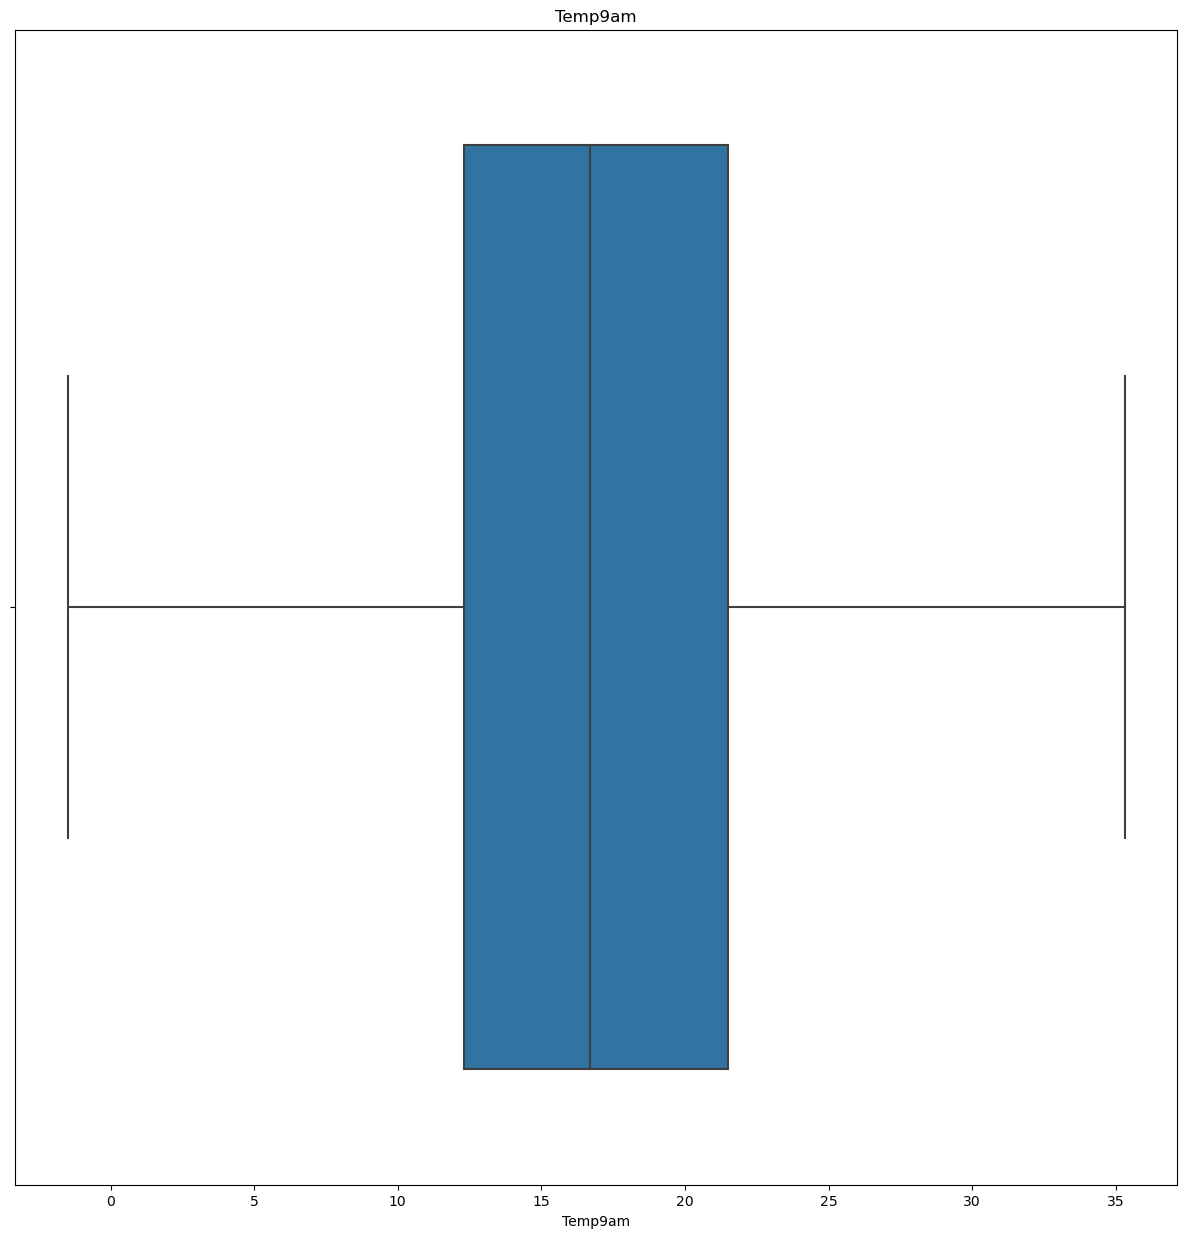

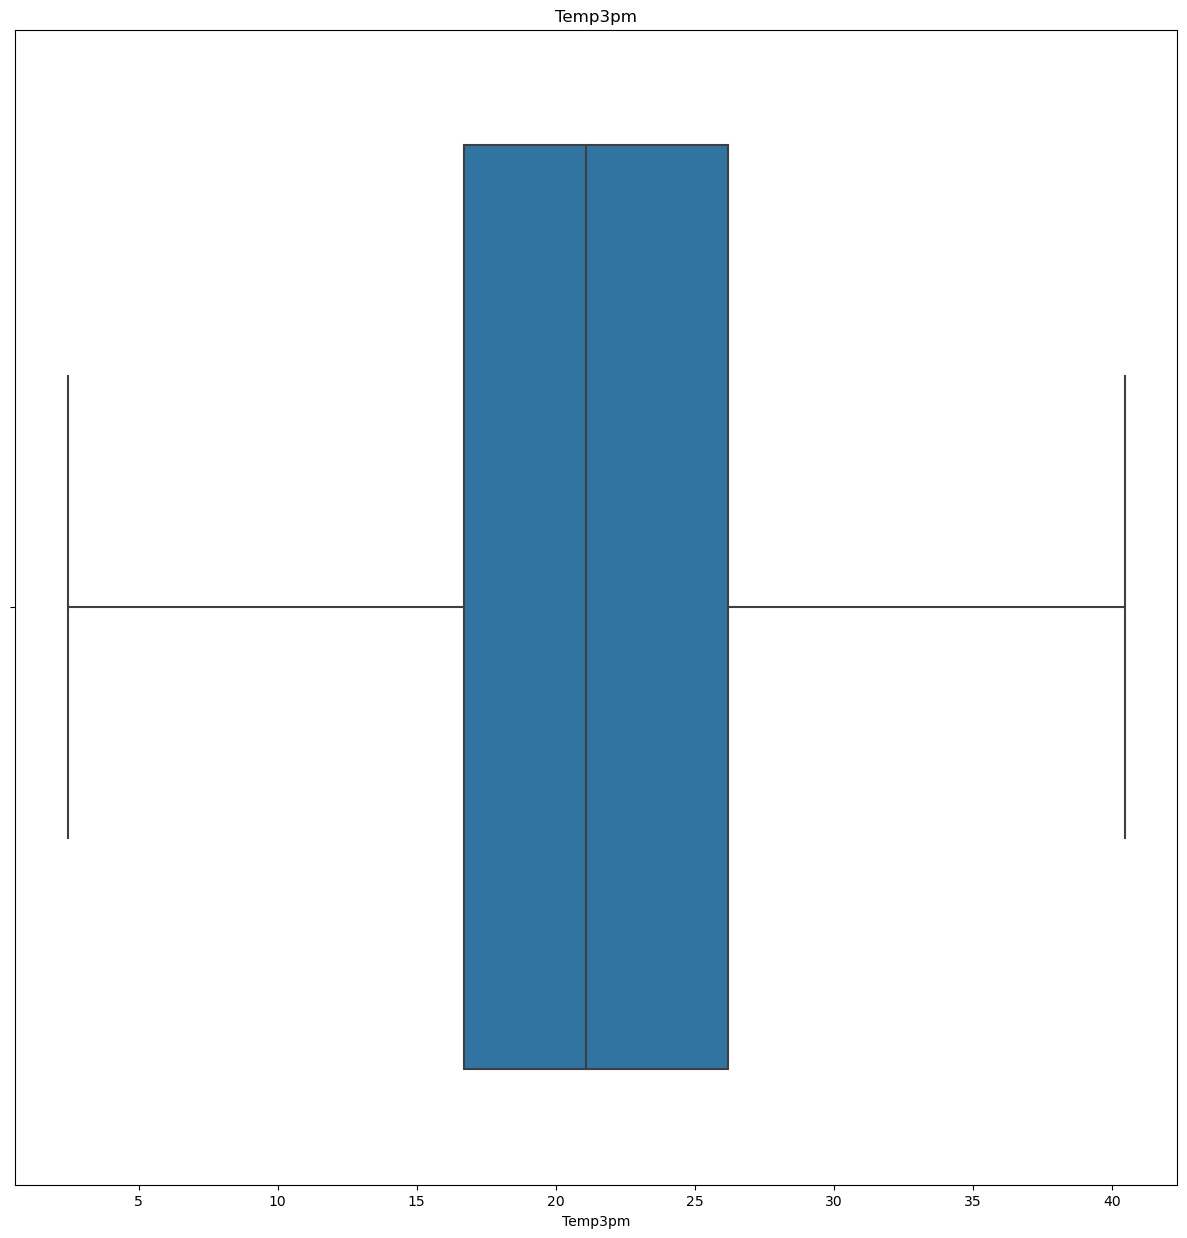

<Figure size 1500x1500 with 0 Axes>

In [63]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [64]:
def qq_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

MinTemp


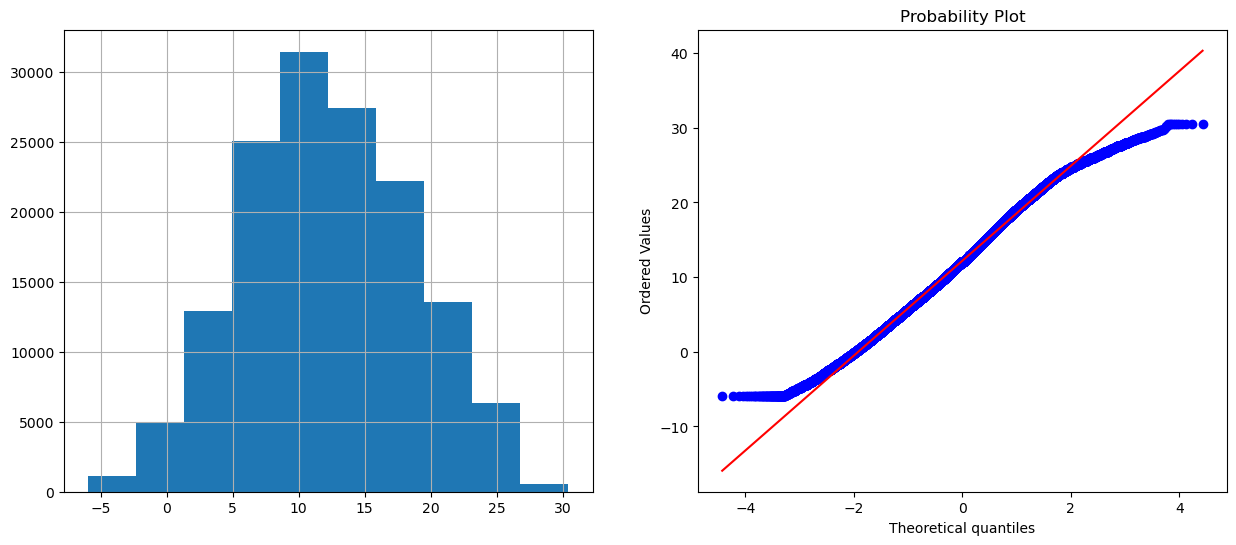

MaxTemp


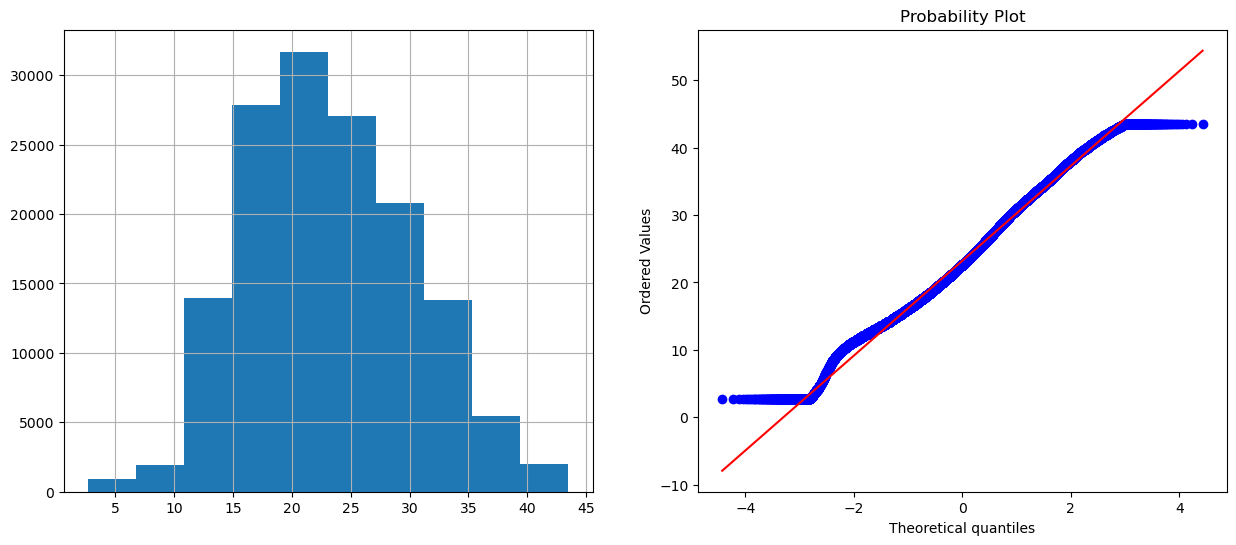

Rainfall


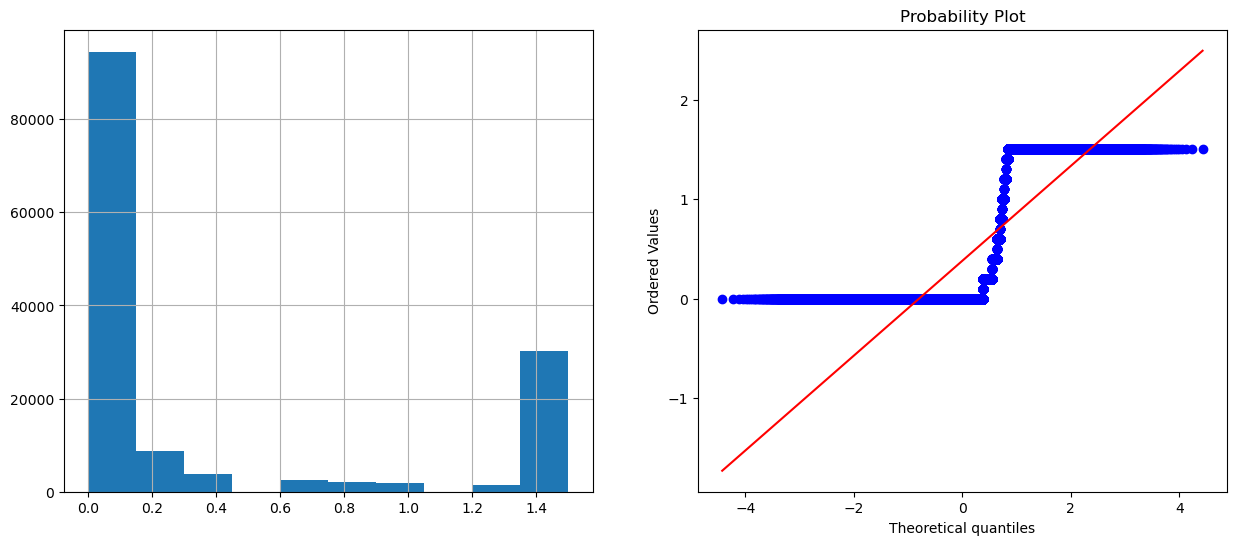

Evaporation


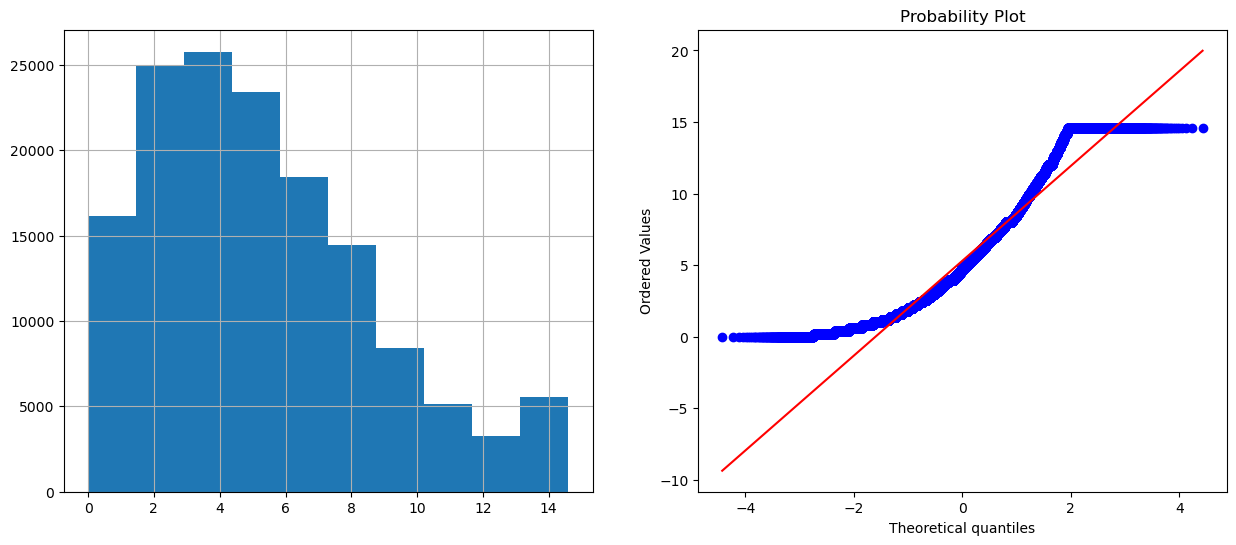

Sunshine


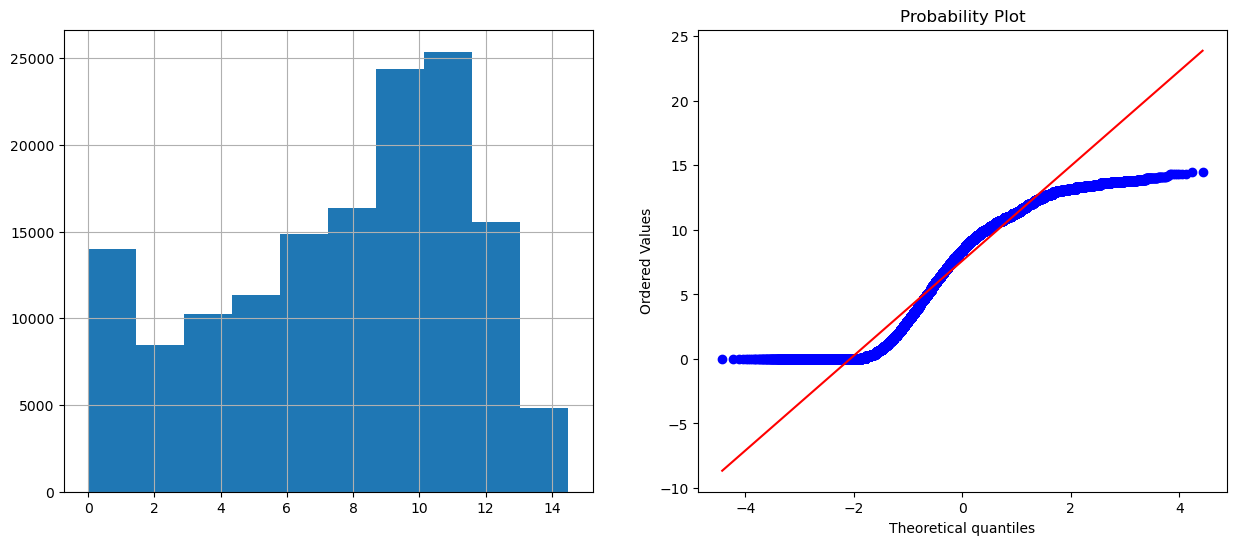

WindGustSpeed


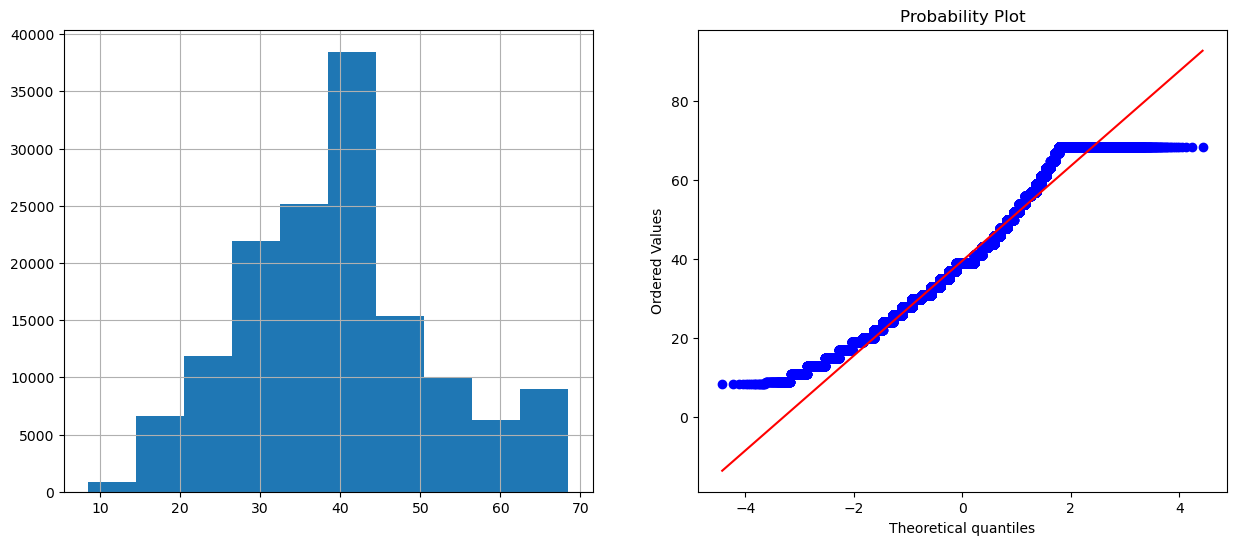

WindSpeed9am


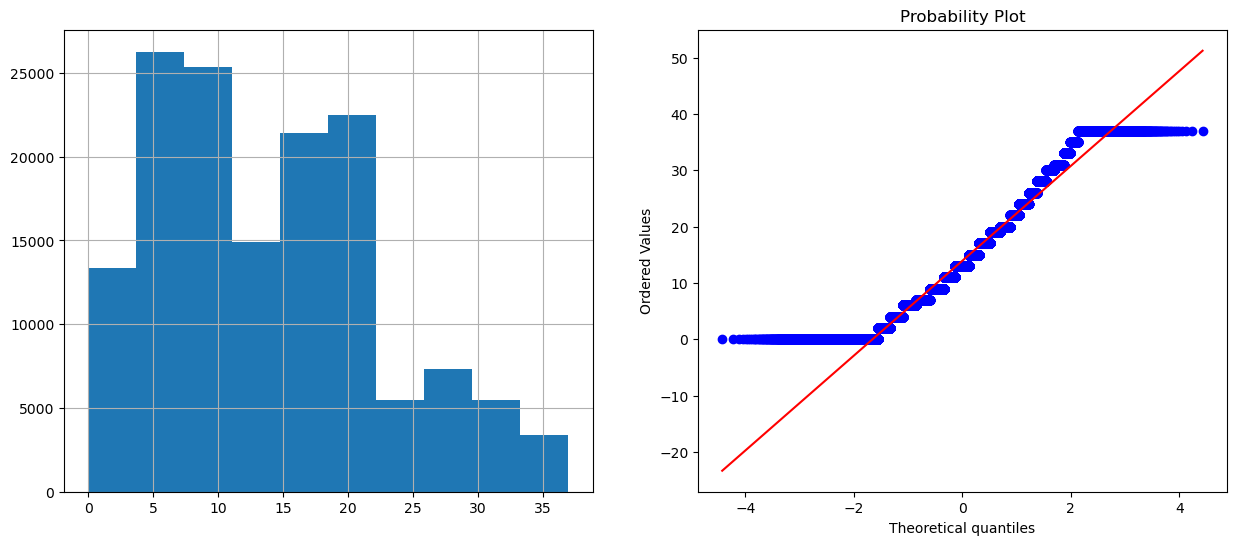

WindSpeed3pm


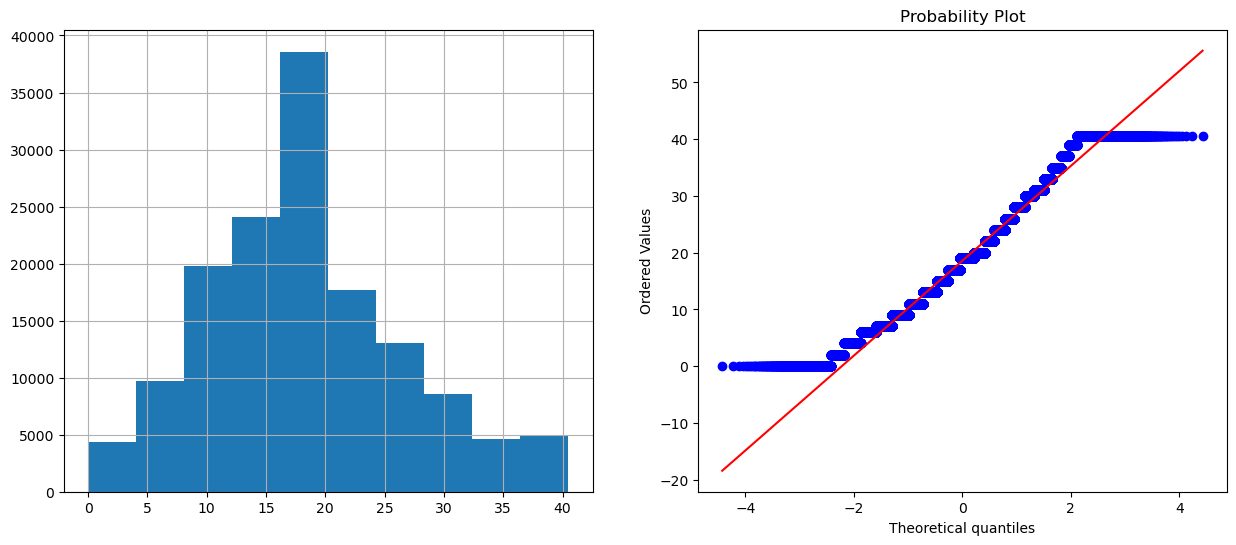

Humidity9am


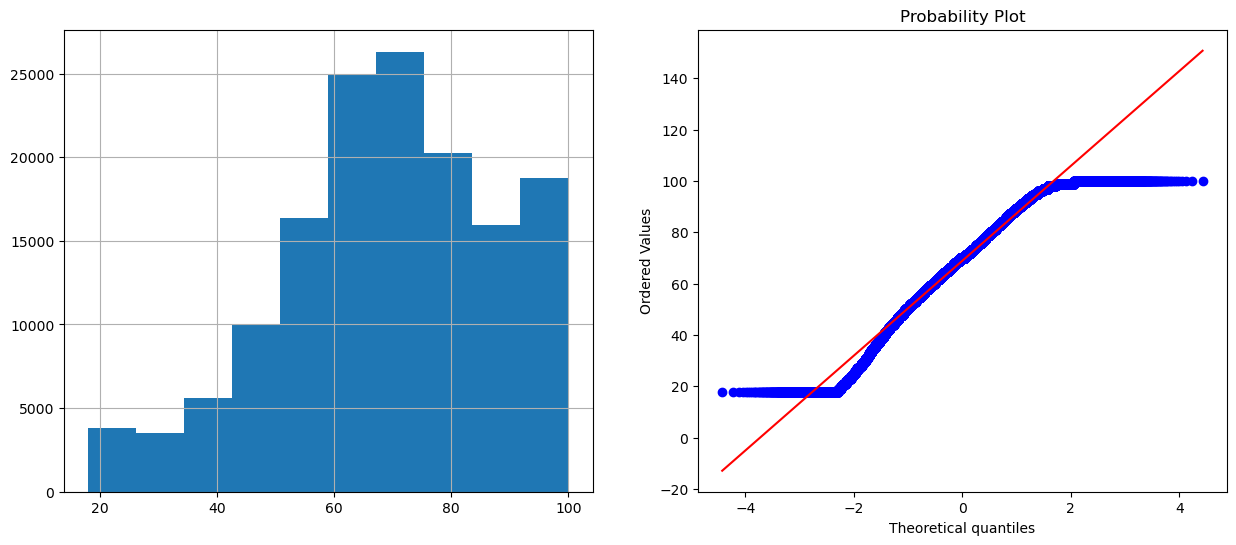

Humidity3pm


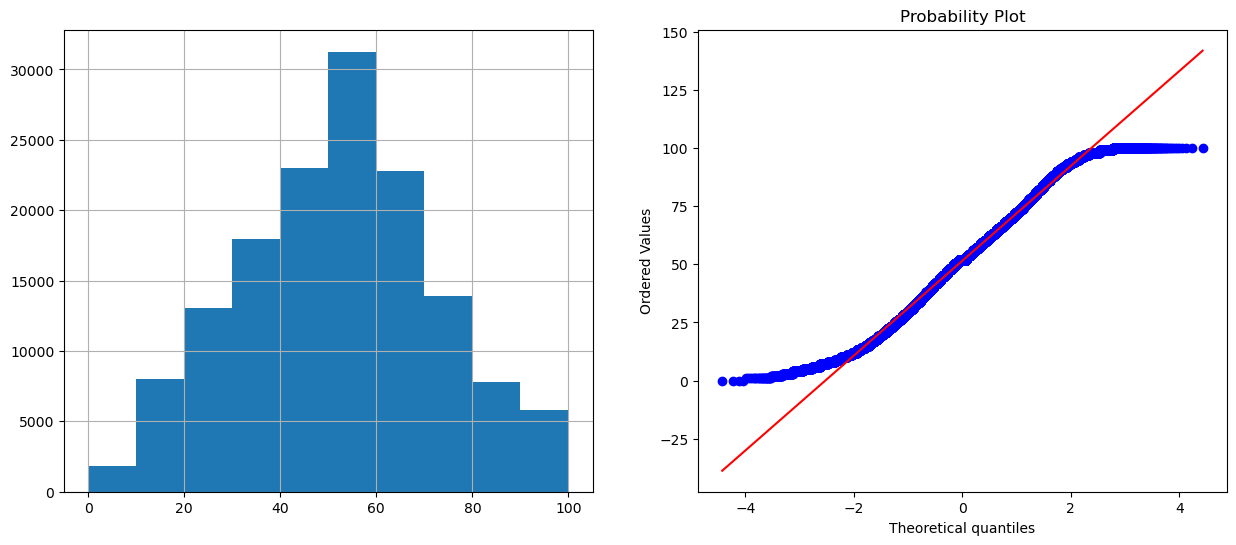

Pressure9am


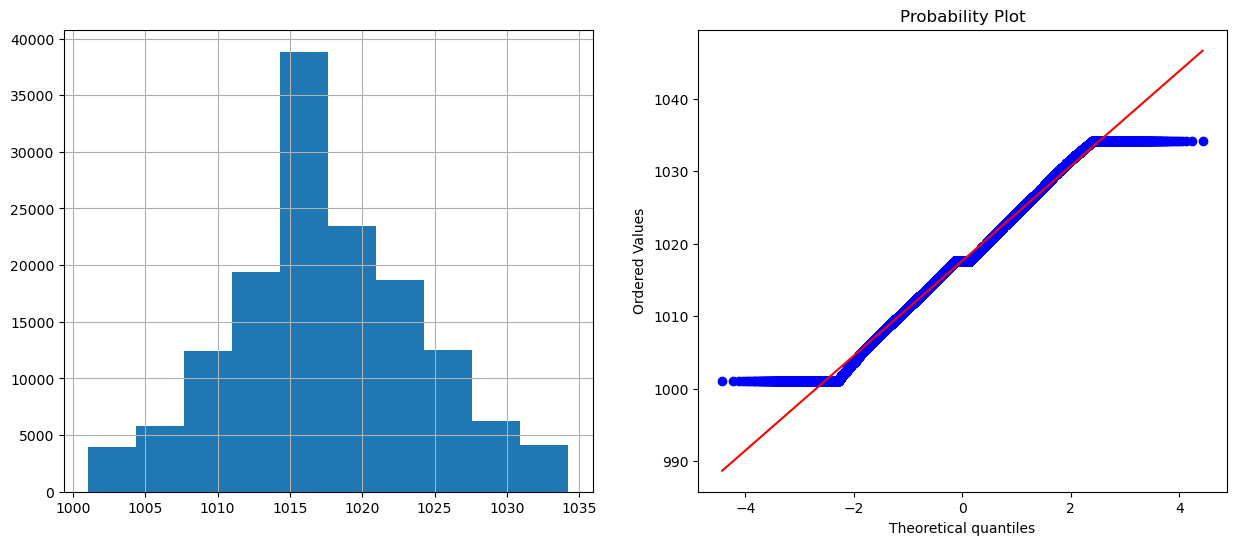

Pressure3pm


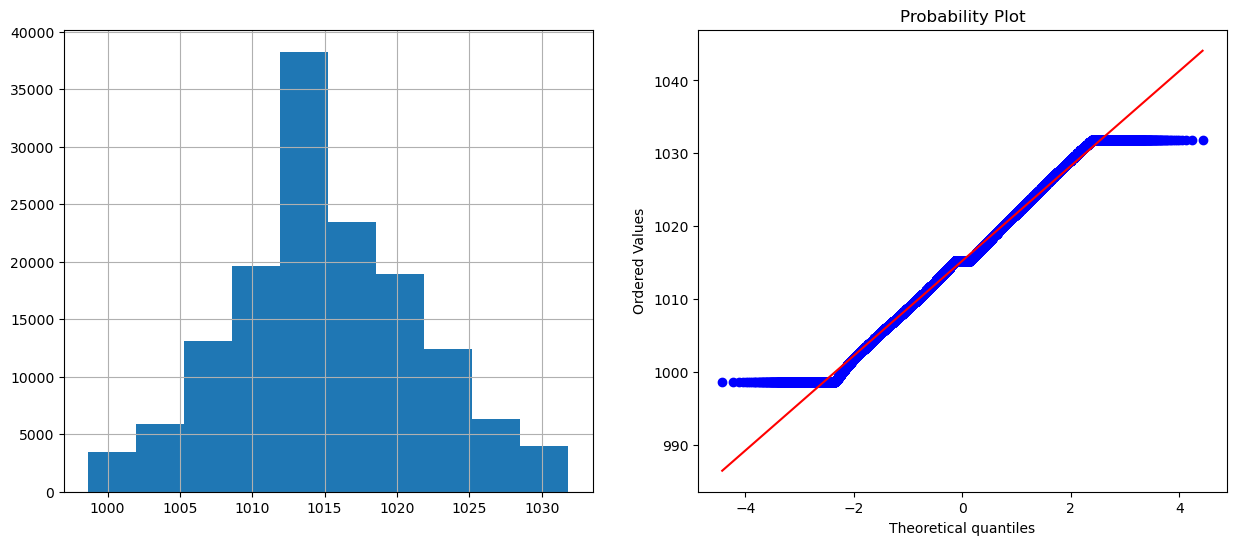

Temp9am


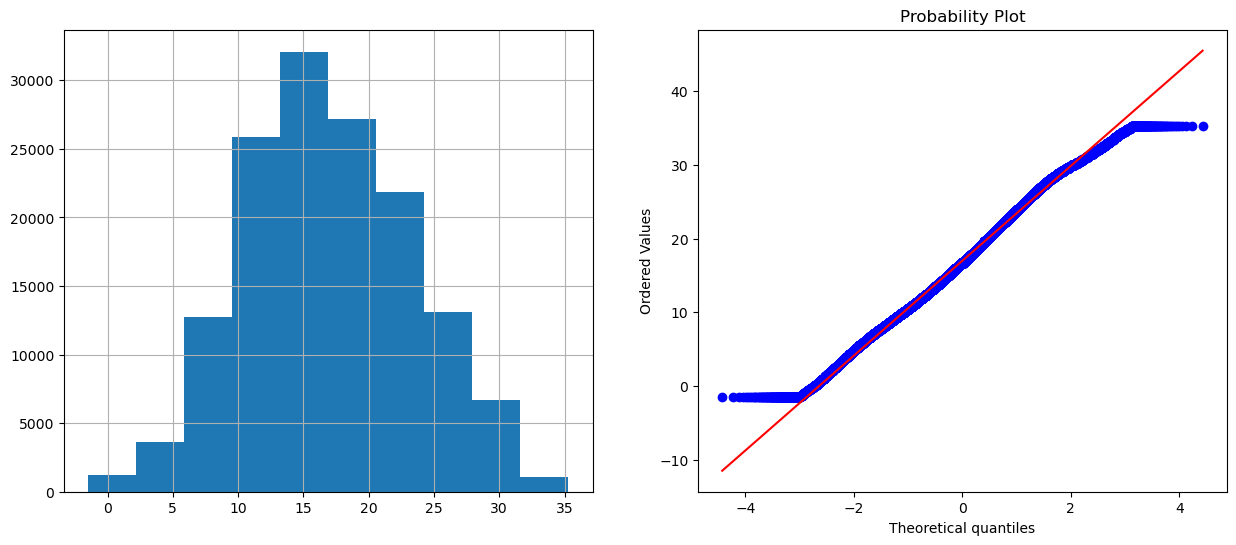

Temp3pm


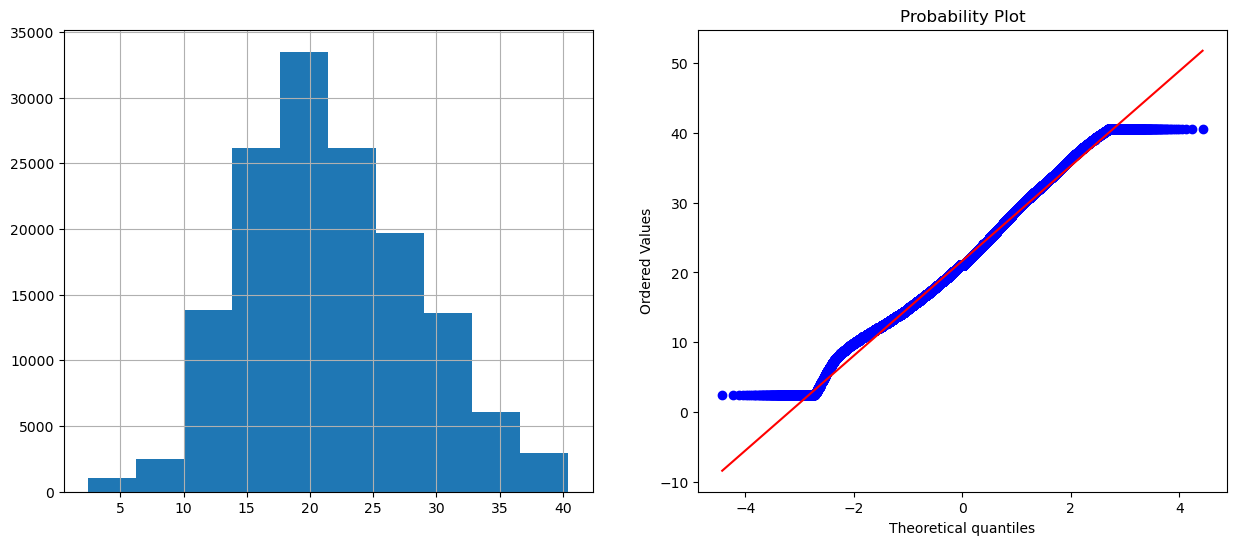

In [65]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.show()

In [83]:
df.to_csv("preprocessed_1.csv", index=False)

In [84]:
X = df.drop(["CloudBurstTomorrow", "Date"], axis=1)
Y = df["CloudBurstTomorrow"]

In [72]:
 #scaler = RobustScaler()
#X_scaled = scaler.fit_transform(X)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [98]:
y_train

43447     0
140904    0
54615     0
109793    0
74462     0
         ..
106567    0
52791     1
56339     0
82299     1
115175    0
Name: CloudBurstTomorrow, Length: 116368, dtype: uint8

In [99]:
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 90866, 1: 25502})
The number of classes after fit Counter({0: 90866, 1: 90866})


In [100]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_res, y_train_res)

Learning rate set to 0.050311
0:	total: 33.8ms	remaining: 1m 7s
1:	total: 71ms	remaining: 1m 10s
2:	total: 112ms	remaining: 1m 14s
3:	total: 150ms	remaining: 1m 14s
4:	total: 178ms	remaining: 1m 10s
5:	total: 211ms	remaining: 1m 9s
6:	total: 251ms	remaining: 1m 11s
7:	total: 281ms	remaining: 1m 9s
8:	total: 314ms	remaining: 1m 9s
9:	total: 353ms	remaining: 1m 10s
10:	total: 382ms	remaining: 1m 9s
11:	total: 410ms	remaining: 1m 7s
12:	total: 446ms	remaining: 1m 8s
13:	total: 484ms	remaining: 1m 8s
14:	total: 511ms	remaining: 1m 7s
15:	total: 552ms	remaining: 1m 8s
16:	total: 586ms	remaining: 1m 8s
17:	total: 615ms	remaining: 1m 7s
18:	total: 644ms	remaining: 1m 7s
19:	total: 691ms	remaining: 1m 8s
20:	total: 736ms	remaining: 1m 9s
21:	total: 769ms	remaining: 1m 9s
22:	total: 798ms	remaining: 1m 8s
23:	total: 828ms	remaining: 1m 8s
24:	total: 858ms	remaining: 1m 7s
25:	total: 889ms	remaining: 1m 7s
26:	total: 927ms	remaining: 1m 7s
27:	total: 978ms	remaining: 1m 8s
28:	total: 1.01s	remai

237:	total: 8.54s	remaining: 1m 3s
238:	total: 8.58s	remaining: 1m 3s
239:	total: 8.61s	remaining: 1m 3s
240:	total: 8.64s	remaining: 1m 3s
241:	total: 8.68s	remaining: 1m 3s
242:	total: 8.71s	remaining: 1m 2s
243:	total: 8.75s	remaining: 1m 2s
244:	total: 8.78s	remaining: 1m 2s
245:	total: 8.83s	remaining: 1m 2s
246:	total: 8.86s	remaining: 1m 2s
247:	total: 8.89s	remaining: 1m 2s
248:	total: 8.92s	remaining: 1m 2s
249:	total: 8.95s	remaining: 1m 2s
250:	total: 8.99s	remaining: 1m 2s
251:	total: 9.02s	remaining: 1m 2s
252:	total: 9.05s	remaining: 1m 2s
253:	total: 9.08s	remaining: 1m 2s
254:	total: 9.11s	remaining: 1m 2s
255:	total: 9.14s	remaining: 1m 2s
256:	total: 9.17s	remaining: 1m 2s
257:	total: 9.2s	remaining: 1m 2s
258:	total: 9.23s	remaining: 1m 2s
259:	total: 9.27s	remaining: 1m 2s
260:	total: 9.3s	remaining: 1m 1s
261:	total: 9.34s	remaining: 1m 1s
262:	total: 9.37s	remaining: 1m 1s
263:	total: 9.4s	remaining: 1m 1s
264:	total: 9.43s	remaining: 1m 1s
265:	total: 9.46s	remai

479:	total: 16.3s	remaining: 51.7s
480:	total: 16.4s	remaining: 51.7s
481:	total: 16.4s	remaining: 51.6s
482:	total: 16.4s	remaining: 51.6s
483:	total: 16.5s	remaining: 51.5s
484:	total: 16.5s	remaining: 51.5s
485:	total: 16.5s	remaining: 51.5s
486:	total: 16.6s	remaining: 51.5s
487:	total: 16.6s	remaining: 51.5s
488:	total: 16.7s	remaining: 51.5s
489:	total: 16.7s	remaining: 51.5s
490:	total: 16.7s	remaining: 51.4s
491:	total: 16.8s	remaining: 51.4s
492:	total: 16.8s	remaining: 51.4s
493:	total: 16.9s	remaining: 51.4s
494:	total: 16.9s	remaining: 51.3s
495:	total: 16.9s	remaining: 51.3s
496:	total: 17s	remaining: 51.3s
497:	total: 17s	remaining: 51.3s
498:	total: 17s	remaining: 51.2s
499:	total: 17.1s	remaining: 51.2s
500:	total: 17.1s	remaining: 51.2s
501:	total: 17.2s	remaining: 51.2s
502:	total: 17.2s	remaining: 51.2s
503:	total: 17.2s	remaining: 51.2s
504:	total: 17.3s	remaining: 51.1s
505:	total: 17.3s	remaining: 51.1s
506:	total: 17.3s	remaining: 51.1s
507:	total: 17.4s	remainin

718:	total: 24.6s	remaining: 43.9s
719:	total: 24.7s	remaining: 43.8s
720:	total: 24.7s	remaining: 43.8s
721:	total: 24.7s	remaining: 43.8s
722:	total: 24.8s	remaining: 43.8s
723:	total: 24.8s	remaining: 43.8s
724:	total: 24.9s	remaining: 43.7s
725:	total: 24.9s	remaining: 43.7s
726:	total: 24.9s	remaining: 43.7s
727:	total: 25s	remaining: 43.7s
728:	total: 25s	remaining: 43.6s
729:	total: 25.1s	remaining: 43.6s
730:	total: 25.1s	remaining: 43.6s
731:	total: 25.1s	remaining: 43.5s
732:	total: 25.2s	remaining: 43.5s
733:	total: 25.2s	remaining: 43.5s
734:	total: 25.2s	remaining: 43.4s
735:	total: 25.3s	remaining: 43.4s
736:	total: 25.3s	remaining: 43.3s
737:	total: 25.3s	remaining: 43.3s
738:	total: 25.4s	remaining: 43.3s
739:	total: 25.4s	remaining: 43.3s
740:	total: 25.4s	remaining: 43.2s
741:	total: 25.5s	remaining: 43.2s
742:	total: 25.5s	remaining: 43.1s
743:	total: 25.5s	remaining: 43.1s
744:	total: 25.6s	remaining: 43.1s
745:	total: 25.6s	remaining: 43s
746:	total: 25.6s	remainin

957:	total: 32.3s	remaining: 35.2s
958:	total: 32.4s	remaining: 35.1s
959:	total: 32.4s	remaining: 35.1s
960:	total: 32.4s	remaining: 35.1s
961:	total: 32.5s	remaining: 35s
962:	total: 32.5s	remaining: 35s
963:	total: 32.5s	remaining: 35s
964:	total: 32.6s	remaining: 34.9s
965:	total: 32.6s	remaining: 34.9s
966:	total: 32.6s	remaining: 34.9s
967:	total: 32.7s	remaining: 34.8s
968:	total: 32.7s	remaining: 34.8s
969:	total: 32.7s	remaining: 34.7s
970:	total: 32.8s	remaining: 34.7s
971:	total: 32.8s	remaining: 34.7s
972:	total: 32.8s	remaining: 34.7s
973:	total: 32.9s	remaining: 34.6s
974:	total: 32.9s	remaining: 34.6s
975:	total: 32.9s	remaining: 34.5s
976:	total: 33s	remaining: 34.5s
977:	total: 33s	remaining: 34.5s
978:	total: 33s	remaining: 34.4s
979:	total: 33s	remaining: 34.4s
980:	total: 33.1s	remaining: 34.4s
981:	total: 33.1s	remaining: 34.3s
982:	total: 33.1s	remaining: 34.3s
983:	total: 33.2s	remaining: 34.3s
984:	total: 33.2s	remaining: 34.2s
985:	total: 33.2s	remaining: 34.2s

1192:	total: 39.7s	remaining: 26.9s
1193:	total: 39.8s	remaining: 26.8s
1194:	total: 39.8s	remaining: 26.8s
1195:	total: 39.8s	remaining: 26.8s
1196:	total: 39.9s	remaining: 26.7s
1197:	total: 39.9s	remaining: 26.7s
1198:	total: 39.9s	remaining: 26.7s
1199:	total: 39.9s	remaining: 26.6s
1200:	total: 40s	remaining: 26.6s
1201:	total: 40s	remaining: 26.6s
1202:	total: 40s	remaining: 26.5s
1203:	total: 40.1s	remaining: 26.5s
1204:	total: 40.1s	remaining: 26.5s
1205:	total: 40.1s	remaining: 26.4s
1206:	total: 40.2s	remaining: 26.4s
1207:	total: 40.2s	remaining: 26.4s
1208:	total: 40.2s	remaining: 26.3s
1209:	total: 40.3s	remaining: 26.3s
1210:	total: 40.3s	remaining: 26.3s
1211:	total: 40.3s	remaining: 26.2s
1212:	total: 40.4s	remaining: 26.2s
1213:	total: 40.4s	remaining: 26.2s
1214:	total: 40.4s	remaining: 26.1s
1215:	total: 40.5s	remaining: 26.1s
1216:	total: 40.5s	remaining: 26.1s
1217:	total: 40.5s	remaining: 26s
1218:	total: 40.6s	remaining: 26s
1219:	total: 40.6s	remaining: 25.9s
12

1426:	total: 47.1s	remaining: 18.9s
1427:	total: 47.2s	remaining: 18.9s
1428:	total: 47.2s	remaining: 18.9s
1429:	total: 47.2s	remaining: 18.8s
1430:	total: 47.3s	remaining: 18.8s
1431:	total: 47.3s	remaining: 18.8s
1432:	total: 47.3s	remaining: 18.7s
1433:	total: 47.3s	remaining: 18.7s
1434:	total: 47.4s	remaining: 18.7s
1435:	total: 47.4s	remaining: 18.6s
1436:	total: 47.4s	remaining: 18.6s
1437:	total: 47.5s	remaining: 18.5s
1438:	total: 47.5s	remaining: 18.5s
1439:	total: 47.5s	remaining: 18.5s
1440:	total: 47.6s	remaining: 18.5s
1441:	total: 47.6s	remaining: 18.4s
1442:	total: 47.6s	remaining: 18.4s
1443:	total: 47.7s	remaining: 18.4s
1444:	total: 47.7s	remaining: 18.3s
1445:	total: 47.7s	remaining: 18.3s
1446:	total: 47.8s	remaining: 18.3s
1447:	total: 47.8s	remaining: 18.2s
1448:	total: 47.8s	remaining: 18.2s
1449:	total: 47.9s	remaining: 18.2s
1450:	total: 47.9s	remaining: 18.1s
1451:	total: 47.9s	remaining: 18.1s
1452:	total: 48s	remaining: 18.1s
1453:	total: 48s	remaining: 18

1663:	total: 54.6s	remaining: 11s
1664:	total: 54.7s	remaining: 11s
1665:	total: 54.7s	remaining: 11s
1666:	total: 54.7s	remaining: 10.9s
1667:	total: 54.8s	remaining: 10.9s
1668:	total: 54.8s	remaining: 10.9s
1669:	total: 54.8s	remaining: 10.8s
1670:	total: 54.9s	remaining: 10.8s
1671:	total: 54.9s	remaining: 10.8s
1672:	total: 54.9s	remaining: 10.7s
1673:	total: 54.9s	remaining: 10.7s
1674:	total: 55s	remaining: 10.7s
1675:	total: 55s	remaining: 10.6s
1676:	total: 55s	remaining: 10.6s
1677:	total: 55.1s	remaining: 10.6s
1678:	total: 55.1s	remaining: 10.5s
1679:	total: 55.1s	remaining: 10.5s
1680:	total: 55.2s	remaining: 10.5s
1681:	total: 55.2s	remaining: 10.4s
1682:	total: 55.2s	remaining: 10.4s
1683:	total: 55.3s	remaining: 10.4s
1684:	total: 55.3s	remaining: 10.3s
1685:	total: 55.3s	remaining: 10.3s
1686:	total: 55.3s	remaining: 10.3s
1687:	total: 55.4s	remaining: 10.2s
1688:	total: 55.4s	remaining: 10.2s
1689:	total: 55.4s	remaining: 10.2s
1690:	total: 55.5s	remaining: 10.1s
1691

1896:	total: 1m 2s	remaining: 3.38s
1897:	total: 1m 2s	remaining: 3.35s
1898:	total: 1m 2s	remaining: 3.32s
1899:	total: 1m 2s	remaining: 3.28s
1900:	total: 1m 2s	remaining: 3.25s
1901:	total: 1m 2s	remaining: 3.22s
1902:	total: 1m 2s	remaining: 3.19s
1903:	total: 1m 2s	remaining: 3.15s
1904:	total: 1m 2s	remaining: 3.12s
1905:	total: 1m 2s	remaining: 3.09s
1906:	total: 1m 2s	remaining: 3.05s
1907:	total: 1m 2s	remaining: 3.02s
1908:	total: 1m 2s	remaining: 2.99s
1909:	total: 1m 2s	remaining: 2.96s
1910:	total: 1m 2s	remaining: 2.92s
1911:	total: 1m 2s	remaining: 2.89s
1912:	total: 1m 2s	remaining: 2.86s
1913:	total: 1m 2s	remaining: 2.82s
1914:	total: 1m 2s	remaining: 2.79s
1915:	total: 1m 2s	remaining: 2.76s
1916:	total: 1m 2s	remaining: 2.73s
1917:	total: 1m 3s	remaining: 2.69s
1918:	total: 1m 3s	remaining: 2.66s
1919:	total: 1m 3s	remaining: 2.63s
1920:	total: 1m 3s	remaining: 2.59s
1921:	total: 1m 3s	remaining: 2.56s
1922:	total: 1m 3s	remaining: 2.53s
1923:	total: 1m 3s	remaining

In [101]:
y_pred = cat.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[21520  1197]
 [ 2798  3577]]
0.862677024611577
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     22717
           1       0.75      0.56      0.64      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.75      0.78     29092
weighted avg       0.86      0.86      0.86     29092



In [102]:
rf=RandomForestClassifier()
rf.fit(X_train_res,y_train_res)

RandomForestClassifier()

In [103]:
y_pred1 = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

[[20647  2070]
 [ 2459  3916]]
0.8443214629451395
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     22717
           1       0.65      0.61      0.63      6375

    accuracy                           0.84     29092
   macro avg       0.77      0.76      0.77     29092
weighted avg       0.84      0.84      0.84     29092



In [104]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

C:\Users\zeel sheth\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [105]:
y_pred2 = logreg.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[17511  5206]
 [ 1515  4860]]
0.7689742884641826
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     22717
           1       0.48      0.76      0.59      6375

    accuracy                           0.77     29092
   macro avg       0.70      0.77      0.72     29092
weighted avg       0.82      0.77      0.78     29092



In [107]:
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

GaussianNB()

In [108]:
y_pred3 = gnb.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

[[17057  5660]
 [ 1662  4713]]
0.7483156881616939
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     22717
           1       0.45      0.74      0.56      6375

    accuracy                           0.75     29092
   macro avg       0.68      0.75      0.69     29092
weighted avg       0.81      0.75      0.77     29092



C:\Users\zeel sheth\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7450707503320914

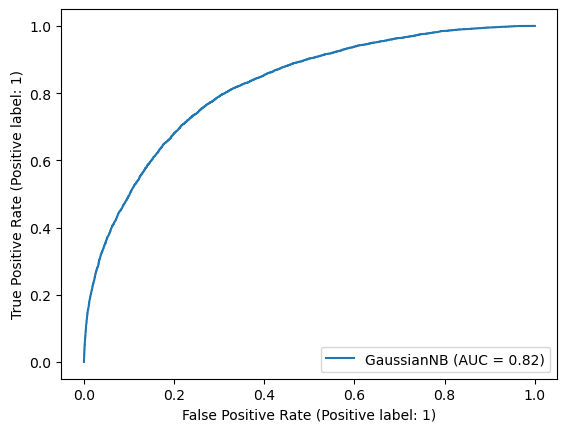

In [109]:
metrics.plot_roc_curve(gnb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred3, average=None) 

In [110]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=3)

In [111]:
y_pred4 = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred4))
print(accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))

C:\Users\zeel sheth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[[17445  5272]
 [ 1844  4531]]
0.7553966726247766
              precision    recall  f1-score   support

           0       0.90      0.77      0.83     22717
           1       0.46      0.71      0.56      6375

    accuracy                           0.76     29092
   macro avg       0.68      0.74      0.70     29092
weighted avg       0.81      0.76      0.77     29092



In [113]:
xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [114]:
y_pred6 = xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred6))
print(accuracy_score(y_test,y_pred6))
print(classification_report(y_test,y_pred6))

[[21361  1356]
 [ 2806  3569]]
0.8569366148769421
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22717
           1       0.72      0.56      0.63      6375

    accuracy                           0.86     29092
   macro avg       0.80      0.75      0.77     29092
weighted avg       0.85      0.86      0.85     29092



In [116]:
svc = SVC()
svc.fit(X_train_res, y_train_res)

SVC()

In [117]:
y_pred5 = svc.predict(X_test)
print(confusion_matrix(y_test,y_pred5))
print(accuracy_score(y_test,y_pred5))
print(classification_report(y_test,y_pred5))

[[17836  4881]
 [ 1597  4778]]
0.7773271002337412
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22717
           1       0.49      0.75      0.60      6375

    accuracy                           0.78     29092
   macro avg       0.71      0.77      0.72     29092
weighted avg       0.83      0.78      0.79     29092



C:\Users\zeel sheth\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7673145394267229

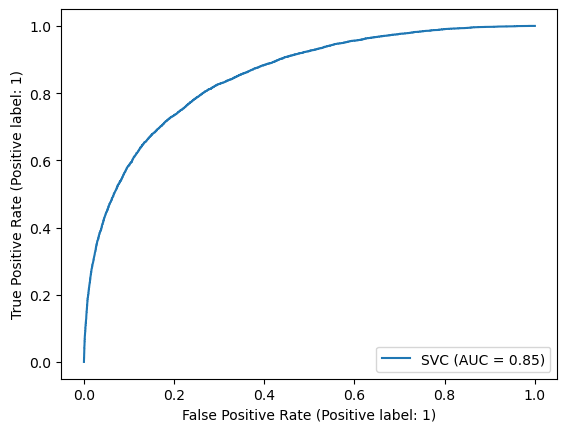

In [118]:
metrics.plot_roc_curve(svc, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred5, average=None) 

In [119]:
# joblib.dump(rf, "rf.pkl")
# joblib.dump(cat, "cat.pkl")
# joblib.dump(logreg, "logreg.pkl")
# joblib.dump(gnb, "gnb.pkl")
# joblib.dump(knn, "knn.pkl")
joblib.dump(svc, "svc.pkl")
joblib.dump(xgb, "xgb.pkl")

['xgb.pkl']